In [2]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

# Visualize some pretrained models.
- See: https://radimrehurek.com/gensim/models/word2vec.html

In [3]:
# Pretrained models!
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [4]:
model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
# This takes the vector for a word and gets the most similar words to this vector.
model.most_similar('banana')

[('bananas', 0.7523775696754456),
 ('pineapple', 0.6587537527084351),
 ('mango', 0.6365211009979248),
 ('pineapples', 0.6313878297805786),
 ('papaya', 0.6063665747642517),
 ('coconut', 0.6035483479499817),
 ('potato', 0.5747568607330322),
 ('melon', 0.5625775456428528),
 ('cashew', 0.562165379524231),
 ('tomato', 0.5590206384658813)]

In [6]:
model.most_similar('obama')

[('mccain', 0.7319012880325317),
 ('hillary', 0.7284600138664246),
 ('obamas', 0.7229632139205933),
 ('george_bush', 0.7205674648284912),
 ('barack_obama', 0.7045838832855225),
 ('palin', 0.7043113708496094),
 ('clinton', 0.6934447884559631),
 ('clintons', 0.6816835403442383),
 ('sarah_palin', 0.6815143823623657),
 ('john_mccain', 0.6800707578659058)]

In [7]:
# x2 - x1 = y2 - y1 ... So y2 = x2 - x1 + y1 ... Consider all neighbors of x2 - x1 + y1, get y2.
def analogy(model, x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [8]:
analogy(model, 'japan', 'japanese', 'australia')

'canada'

In [9]:
analogy(model, 'obama', 'clinton', 'reagan')

'kerry'

In [10]:
analogy(model, 'tall', 'tallest', 'long')


'longest'

In [11]:
# Which word from the given list doesn’t go with the others?
print(model.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


In [12]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

### Let's project to two dimensions and see if thee are any patterns.
We see some clusters:
- Countries are together.
- Drinks are together.
- Foods.
- Etc.

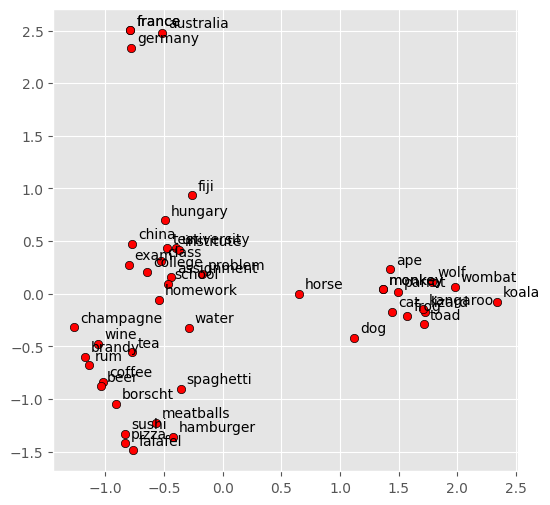

In [13]:
display_pca_scatterplot(
    model,
    [
        'coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
        'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
        'france', 'germany', 'hungary', 'france', 'australia', 'fiji', 'china',
        'homework', 'assignment', 'problem', 'exam', 'test', 'class',
        'school', 'college', 'university', 'institute'
    ]
)

### Information
- torchtext repo: https://github.com/pytorch/text/tree/main/torchtext
- torchtext documentation: https://pytorch.org/text/stable/index.html

In [14]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "cuda" if torch.cuda.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.

# This is *NOT* used. This is "m" in lecture. It is random for each center word. See below.
WINDOW = 1

# Negative samples.
K = 4

In [15]:
print(DEVICE)

cuda


The text8 Wikipedia corpus. 100M characters.

In [16]:
# Put the data in your Google Drive
# You ca get the data here: https://www.kaggle.com/competitions/titanic/data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!du -h text8

du: cannot access 'text8': No such file or directory


In [18]:
f = open('/content/drive/MyDrive/text8/text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [19]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [20]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [21]:
words = TOKENIZER(text)
f = Counter(words)

In [22]:
len(words)

17005207

In [23]:
# Do a very crude filter on the text which remoes all words whuch
text = [word for word in words if f[word] > 5]

In [24]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [25]:
VOCAB = build_vocab_from_iterator([text])

In [26]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos()

In [27]:
stoi['as']

11

In [28]:
# Total number of words.
len(stoi)

63641

In [29]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [30]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [31]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [32]:
len(train_dataset)

7847046

In [33]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos()

In [34]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [35]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [36]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [37]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []

    for i, token in enumerate(dataset):
        # Pick a RANDOM window around the center word.
        m = random.randint(1, 5)

        start = max(0,i-m)

        end = min(i+m,len(dataset)-1)

        target_tokens = dataset[start:i] + dataset[i+1:end+1]

        wc = token

        x_list.extend([
            [wc, wo] for wo in target_tokens
        ])

    return x_list

In [38]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [39]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [40]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [41]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 3083],
 [5233, 11],
 [5233, 5],
 [3083, 5233],
 [3083, 11],
 [3083, 5],
 [3083, 202],
 [3083, 1],
 [11, 3083],
 [11, 5]]

In [42]:
# The number of things of BATCH_SIZE = 512.
len(train_x_list) // BATCH_SIZE

195454

### Set up the dataloader.

In [43]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

### Words we'll use to asses the quality of the model ...

In [44]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model
- See docs for nn.Embedding: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- The same: nn.Embedding (2) = nn.Embedding.weight * oneHot(2)

In [45]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 2)

        # Each of these is (N, 1)
        wc, wo = x[:, 0], x[:, 1]

        # Each of these is (N, 1, D) since each context has 1 word.
        a = self.A(wc)

        # Each of these is (N, 1, D) since each target has 1 word.
        b = self.B(wo)

        # The product between each context and target vector.
        # Each of these is (N, 1, D) since each batch has 1 word.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a * b).sum(axis=-1)

        return logits

In [46]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight

    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [47]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [48]:
model = SkipGramNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [49]:
model

SkipGramNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [50]:
validate_embeddings(model, valid_ids, itos)

money: agglomeration, alchemist, majority, specific, underarm, curtis, daimlerchrysler, nice, mahal, rockets
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, opossums, lugus
africa: jabir, hazzard, lian, squat, pacified, ulam, delius, potty, goggles, peanut
musician: regulators, authorizing, funet, progs, hydrocarbons, checkpoints, despair, fontainebleau, beauchamp, listening
dance: wielder, laban, penelope, accumulation, vader, corky, surgical, opengl, eukaryote, dirkszoon




### Train the model

In [51]:
def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500

    for idx, x_batch in tqdm(enumerate(dataloader)):

        x_batch = x_batch[0]

        batch_size = x_batch.shape[0]

        optimizer.zero_grad()

        logits = model(x_batch)

        # Get the positive samples loss. Notice we use weights here
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())

        # For each batch, get some negative samples
        # We need a total of B * 2 * WINDOW * K samples across a batch
        # We then reshape this batch
        # These are effectively the output words
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)

        # Repeat the center word enough times so we can merge as needed
        # Repeat does not work on MPS apparently
        wc = x_batch[:, 0].to("cpu").repeat(K).sort().values
        wo = negative_samples

        # Get the negative samples
        x_batch_negative = torch.stack([wc, wo], axis=1).to(DEVICE)

        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.

        This is literally the equation in the lecture notes.
        """
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)

        loss = (positive_loss + negative_loss).mean()

        # Get the gradients via back propagation
        loss.backward()

        # Clip the gradients? Generally a good idea
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # Do an optimization step. Update the parameters A and B
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1

        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

![Results.png](attachment:Results.png)

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()

    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way
    scheduler.step()

0it [00:00, ?it/s]

| epoch   1 |     0/195455 batches | loss    4.602 


1it [00:11, 11.46s/it]

money: agglomeration, alchemist, majority, specific, underarm, curtis, daimlerchrysler, nice, mahal, rockets
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, opossums, lugus
africa: hazzard, jabir, lian, squat, ulam, pacified, delius, potty, goggles, peanut
musician: regulators, authorizing, funet, progs, hydrocarbons, checkpoints, despair, fontainebleau, beauchamp, listening
dance: wielder, laban, penelope, accumulation, vader, corky, surgical, opengl, eukaryote, dirkszoon




494it [00:14, 181.95it/s]

| epoch   1 |   500/195455 batches | loss    4.141 


532it [00:15, 124.19it/s]

money: agglomeration, alchemist, majority, underarm, specific, daimlerchrysler, curtis, rockets, nice, mahal
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, huge, opossums
africa: hazzard, jabir, ulam, squat, pacified, lian, delius, potty, goggles, peanut
musician: regulators, authorizing, funet, progs, hydrocarbons, checkpoints, despair, beauchamp, fontainebleau, listening
dance: wielder, laban, accumulation, penelope, vader, surgical, corky, correspondences, imperceptible, eukaryote




985it [00:17, 182.32it/s]

| epoch   1 |  1000/195455 batches | loss    3.878 


1020it [00:18, 120.90it/s]

money: agglomeration, majority, alchemist, specific, underarm, curtis, daimlerchrysler, mahal, rockets, nice
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, opossums, acl
africa: hazzard, jabir, squat, ulam, lian, potty, delius, pacified, vibrating, goggles
musician: regulators, progs, funet, authorizing, despair, hydrocarbons, checkpoints, fontainebleau, beauchamp, listening
dance: wielder, accumulation, laban, penelope, vader, surgical, corky, correspondences, dirkszoon, imperceptible




1494it [00:20, 182.73it/s]

| epoch   1 |  1500/195455 batches | loss    3.667 


1531it [00:21, 122.95it/s]

money: majority, agglomeration, alchemist, underarm, specific, daimlerchrysler, gurion, mahal, cathode, curtis
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, vroma, opossums
africa: hazzard, squat, ulam, jabir, potty, lian, delius, forever, pacified, vibrating
musician: regulators, funet, authorizing, progs, despair, hydrocarbons, beauchamp, fontainebleau, checkpoints, roshan
dance: wielder, accumulation, laban, penelope, vader, surgical, corky, correspondences, dirkszoon, ote




1985it [00:23, 183.05it/s]

| epoch   1 |  2000/195455 batches | loss    3.493 


2020it [00:24, 121.50it/s]

money: majority, agglomeration, specific, alchemist, underarm, gurion, daimlerchrysler, mahal, chief, montagu
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, hillman, vroma, opossums
africa: hazzard, ulam, squat, new, jabir, from, delius, potty, lian, of
musician: regulators, funet, progs, authorizing, despair, beauchamp, fontainebleau, hydrocarbons, checkpoints, roshan
dance: wielder, laban, accumulation, vader, penelope, surgical, imperceptible, correspondences, corky, eukaryote




2494it [00:26, 183.23it/s]

| epoch   1 |  2500/195455 batches | loss    3.329 


2532it [00:27, 123.97it/s]

money: majority, specific, agglomeration, underarm, alchemist, gurion, daimlerchrysler, chief, mahal, montagu
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, vroma, hillman, opossums
africa: from, new, hazzard, to, that, only, are, his, ulam, on
musician: regulators, funet, progs, authorizing, despair, beauchamp, fontainebleau, hydrocarbons, checkpoints, roshan
dance: laban, wielder, accumulation, vader, penelope, imperceptible, dirkszoon, correspondences, surgical, eukaryote




2988it [00:29, 183.02it/s]

| epoch   1 |  3000/195455 batches | loss    3.193 


3024it [00:30, 122.43it/s]

money: specific, majority, agglomeration, chief, underarm, alchemist, gurion, daimlerchrysler, mahal, montagu
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, vroma, hillman, acl
africa: from, new, s, a, his, only, or, also, was, are
musician: regulators, funet, progs, authorizing, beauchamp, despair, fontainebleau, roshan, hydrocarbons, checkpoints
dance: wielder, laban, vader, accumulation, penelope, world, dirkszoon, imperceptible, correspondences, ote




3499it [00:32, 181.16it/s]

| epoch   1 |  3500/195455 batches | loss    3.086 


3518it [00:33, 103.32it/s]

money: majority, specific, chief, see, c, family, agglomeration, gurion, underarm, alchemist
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, vroma, hillman, acl
africa: new, also, was, this, his, only, from, th, which, a
musician: regulators, funet, progs, authorizing, beauchamp, fontainebleau, despair, roshan, hydrocarbons, went
dance: laban, wielder, accumulation, vader, which, set, world, penelope, such, dirkszoon




3990it [00:35, 182.19it/s]

| epoch   1 |  4000/195455 batches | loss    2.996 


4027it [00:36, 122.62it/s]

money: specific, majority, see, c, chief, family, more, popular, cannot, example
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, vroma, hillman, diuretics
africa: new, his, also, or, is, th, only, with, and, a
musician: regulators, funet, progs, authorizing, beauchamp, fontainebleau, roshan, despair, went, hydrocarbons
dance: if, accumulation, common, wielder, with, set, laban, vader, which, such




4500it [00:38, 181.32it/s]

| epoch   1 |  4500/195455 batches | loss    2.910 


4519it [00:39, 108.97it/s]

money: specific, majority, see, c, family, only, chief, more, was, popular
lion: fittings, mithras, objectivist, democratization, blois, callimico, supposes, vroma, trim, hillman
africa: new, his, th, is, from, of, some, only, or, also
musician: regulators, progs, funet, authorizing, beauchamp, fontainebleau, roshan, despair, went, hydrocarbons
dance: if, by, after, common, world, set, into, such, other, which




4990it [00:41, 181.76it/s]

| epoch   1 |  5000/195455 batches | loss    2.836 


5027it [00:42, 122.75it/s]

money: specific, majority, c, more, see, family, they, popular, its, after
lion: fittings, mithras, objectivist, democratization, blois, callimico, supposes, vroma, trim, huge
africa: new, th, from, some, who, his, can, united, their, only
musician: regulators, funet, progs, beauchamp, went, authorizing, fontainebleau, roshan, despair, hydrocarbons
dance: if, world, after, common, other, such, into, life, state, set




5499it [00:44, 182.96it/s]

| epoch   1 |  5500/195455 batches | loss    2.767 


5518it [00:45, 107.31it/s]

money: majority, see, more, specific, c, family, popular, which, a, state
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, trim, huge, vroma
africa: new, th, were, with, their, can, his, and, who, united
musician: regulators, funet, french, went, progs, beauchamp, fontainebleau, authorizing, series, no
dance: if, common, world, after, into, life, including, had, other, south




5989it [00:47, 182.77it/s]

| epoch   1 |  6000/195455 batches | loss    2.714 


6025it [00:48, 122.48it/s]

money: majority, c, see, more, family, specific, example, popular, even, state
lion: fittings, objectivist, mithras, democratization, blois, callimico, supposes, trim, hillman, huge
africa: new, with, their, united, th, who, in, his, by, can
musician: regulators, french, went, funet, progs, series, no, beauchamp, story, out
dance: world, if, common, life, including, their, had, state, last, a




6499it [00:50, 183.34it/s]

| epoch   1 |  6500/195455 batches | loss    2.657 


6518it [00:51, 110.19it/s]

money: more, majority, c, see, family, specific, to, example, if, popular
lion: fittings, objectivist, mithras, democratization, blois, callimico, trim, supposes, vroma, hillman
africa: new, united, their, th, who, other, by, his, have, with
musician: french, went, no, regulators, out, theory, his, series, n, story
dance: if, with, other, life, world, their, had, common, he, such




6993it [00:53, 181.09it/s]

| epoch   1 |  7000/195455 batches | loss    2.610 


7030it [00:54, 123.26it/s]

money: see, more, family, majority, each, c, popular, example, he, specific
lion: fittings, objectivist, mithras, democratization, blois, callimico, huge, trim, vroma, hillman
africa: united, new, th, can, s, their, three, also, is, or
musician: french, no, went, series, first, name, n, out, them, story
dance: other, life, if, with, world, including, from, common, in, written




7485it [00:56, 183.25it/s]

| epoch   1 |  7500/195455 batches | loss    2.562 


7520it [00:57, 120.09it/s]

money: see, family, more, he, majority, c, example, each, popular, specific
lion: fittings, objectivist, mithras, democratization, blois, callimico, huge, trim, supposes, skookum
africa: united, new, in, th, can, their, and, s, is, three
musician: french, no, went, series, them, first, n, same, story, theory
dance: world, if, life, common, modern, had, other, written, with, state




7990it [00:59, 183.00it/s]

| epoch   1 |  8000/195455 batches | loss    2.529 


8027it [01:00, 123.02it/s]

money: see, family, he, more, majority, example, c, popular, each, even
lion: fittings, objectivist, mithras, democratization, blois, callimico, huge, trim, acl, skookum
africa: united, their, new, th, in, with, other, and, both, can
musician: french, went, no, them, series, and, a, n, same, story
dance: world, life, if, common, had, modern, with, state, written, last




8482it [01:02, 182.00it/s]

| epoch   1 |  8500/195455 batches | loss    2.492 


8516it [01:03, 120.02it/s]

money: family, more, see, he, popular, with, majority, example, c, so
lion: fittings, objectivist, mithras, democratization, blois, callimico, huge, trim, skookum, kfar
africa: new, united, th, both, their, with, other, only, which, and
musician: french, them, went, name, series, story, p, no, same, television
dance: world, with, had, life, modern, if, written, last, given, common




8991it [01:05, 182.82it/s]

| epoch   1 |  9000/195455 batches | loss    2.453 


9028it [01:06, 123.30it/s]

money: family, see, more, popular, so, each, majority, example, he, used
lion: fittings, objectivist, mithras, democratization, huge, callimico, blois, trim, skookum, nanotechnology
africa: new, united, both, and, th, other, with, a, of, only
musician: french, went, name, story, p, same, them, no, n, series
dance: world, modern, with, if, life, written, common, given, have, last




9484it [01:08, 182.64it/s]

| epoch   1 |  9500/195455 batches | loss    2.423 


9518it [01:09, 118.60it/s]

money: family, he, more, used, so, example, popular, majority, each, c
lion: fittings, objectivist, mithras, huge, democratization, callimico, blois, trim, skookum, nanotechnology
africa: new, united, both, and, th, with, their, other, may, was
musician: french, went, p, n, name, theory, same, story, series, no
dance: life, world, written, modern, given, common, if, last, such, from




9991it [01:11, 182.11it/s]

| epoch   1 | 10000/195455 batches | loss    2.395 


10028it [01:12, 123.40it/s]

money: more, family, see, example, popular, he, used, each, so, by
lion: fittings, objectivist, mithras, huge, democratization, callimico, blois, trim, jay, skookum
africa: new, united, and, both, th, with, in, which, century, by
musician: french, went, p, no, series, story, n, name, theory, b
dance: written, common, modern, world, given, life, set, last, from, had




10484it [01:14, 183.95it/s]

| epoch   1 | 10500/195455 batches | loss    2.369 


10519it [01:14, 122.33it/s]

money: family, more, see, he, popular, example, used, each, with, majority
lion: fittings, objectivist, mithras, huge, democratization, callimico, trim, blois, merina, jay
africa: new, united, both, th, which, from, century, may, other, between
musician: french, p, went, no, name, n, series, story, theory, same
dance: written, modern, common, set, last, world, had, they, given, life




10994it [01:17, 182.43it/s]

| epoch   1 | 11000/195455 batches | loss    2.340 


11032it [01:18, 124.70it/s]

money: see, would, example, family, with, used, he, popular, more, if
lion: fittings, objectivist, mithras, huge, democratization, callimico, trim, blois, merina, jay
africa: and, new, both, united, th, may, other, which, century, from
musician: french, p, went, no, name, theory, n, series, story, i
dance: written, last, modern, life, through, set, common, given, world, had




11487it [01:20, 182.39it/s]

| epoch   1 | 11500/195455 batches | loss    2.318 


11523it [01:20, 122.15it/s]

money: example, would, he, it, used, family, each, popular, more, see
lion: fittings, objectivist, mithras, huge, democratization, callimico, trim, blois, merina, jay
africa: new, both, may, united, th, other, which, those, on, one
musician: p, french, went, name, theory, b, story, n, series, no
dance: written, world, last, modern, common, life, given, set, through, government




11995it [01:23, 182.63it/s]

| epoch   1 | 12000/195455 batches | loss    2.296 


12033it [01:23, 124.64it/s]

money: used, would, popular, example, see, family, each, more, he, who
lion: fittings, objectivist, mithras, huge, democratization, callimico, trim, blois, park, merina
africa: new, both, th, united, which, other, those, were, may, use
musician: p, french, went, theory, story, b, name, n, same, two
dance: last, with, modern, given, world, common, written, they, while, set




12487it [01:26, 181.37it/s]

| epoch   1 | 12500/195455 batches | loss    2.277 


12522it [01:26, 118.01it/s]

money: example, would, popular, each, he, see, family, that, used, with
lion: fittings, mithras, objectivist, huge, democratization, park, symbols, callimico, trim, blois
africa: new, and, with, both, as, other, th, those, united, may
musician: p, french, went, theory, story, n, two, b, same, series
dance: modern, last, world, written, given, with, common, set, while, south




12996it [01:29, 183.76it/s]

| epoch   1 | 13000/195455 batches | loss    2.264 


13015it [01:29, 110.29it/s]

money: example, would, popular, each, see, more, family, used, well, a
lion: fittings, mithras, objectivist, huge, park, symbols, democratization, jay, concerns, trim
africa: and, other, new, th, both, use, those, united, may, well
musician: p, french, went, theory, story, name, n, series, b, same
dance: modern, world, written, last, while, set, common, given, which, up




13490it [01:32, 182.84it/s]

| epoch   1 | 13500/195455 batches | loss    2.239 


13527it [01:32, 123.40it/s]

money: with, popular, example, would, more, each, if, but, see, he
lion: fittings, mithras, objectivist, huge, symbols, park, concerns, led, jay, callimico
africa: new, th, those, other, both, and, use, well, united, century
musician: french, p, went, one, theory, no, n, series, first, story
dance: modern, written, which, last, set, world, while, given, as, when




14000it [01:35, 182.03it/s]

| epoch   1 | 14000/195455 batches | loss    2.227 


14019it [01:35, 109.08it/s]

money: popular, example, would, more, large, well, each, he, see, death
lion: fittings, mithras, objectivist, huge, park, symbols, concerns, led, officials, jay
africa: those, both, th, other, s, united, new, well, has, states
musician: french, p, went, two, one, nine, five, n, theory, six
dance: modern, written, which, set, as, world, while, last, given, both




14488it [01:38, 179.66it/s]

| epoch   1 | 14500/195455 batches | loss    2.210 


14523it [01:38, 120.59it/s]

money: would, example, popular, large, see, it, all, well, each, where
lion: fittings, mithras, objectivist, huge, symbols, park, concerns, led, executive, right
africa: has, th, those, both, use, as, states, united, s, new
musician: french, p, went, two, nine, five, seven, n, one, six
dance: set, which, modern, written, with, world, and, while, given, last




14997it [01:41, 182.41it/s]

| epoch   1 | 15000/195455 batches | loss    2.195 


15016it [01:41, 110.29it/s]

money: would, it, popular, more, if, all, large, see, even, example
lion: fittings, mithras, objectivist, huge, symbols, park, concerns, right, executive, officials
africa: both, th, those, united, states, were, new, has, use, and
musician: french, p, two, went, seven, one, six, eight, n, nine
dance: world, modern, set, written, law, given, which, as, while, with




15491it [01:44, 181.25it/s]

| epoch   1 | 15500/195455 batches | loss    2.181 


15528it [01:44, 122.97it/s]

money: would, it, will, popular, more, even, see, large, if, each
lion: fittings, mithras, objectivist, huge, symbols, park, concerns, executive, right, led
africa: both, th, united, those, new, states, and, were, century, also
musician: french, p, went, seven, n, one, two, five, eight, actor
dance: and, written, law, modern, as, set, world, while, given, country




15994it [01:47, 179.58it/s]

| epoch   1 | 16000/195455 batches | loss    2.167 


16031it [01:47, 122.38it/s]

money: would, it, will, popular, see, family, each, but, well, more
lion: fittings, huge, mithras, objectivist, symbols, park, concerns, executive, led, january
africa: and, th, both, new, united, states, those, century, in, part
musician: p, eight, french, went, n, five, six, actor, b, c
dance: written, as, modern, country, with, law, given, while, set




16484it [01:50, 180.99it/s]

| epoch   1 | 16500/195455 batches | loss    2.154 


16519it [01:50, 120.91it/s]

money: it, would, popular, but, more, all, so, will, each, family
lion: fittings, mithras, huge, objectivist, symbols, park, january, right, concerns, led
africa: th, both, new, in, those, states, other, united, has, into
musician: p, french, went, eight, six, one, five, c, n, m
dance: written, modern, with, by, country, while, world, as, given, set




16993it [01:53, 180.83it/s]

| epoch   1 | 17000/195455 batches | loss    2.143 


17030it [01:53, 123.58it/s]

money: it, so, would, all, but, even, more, popular, large, family
lion: huge, mithras, fittings, objectivist, symbols, park, right, led, january, executive
africa: both, th, states, new, in, has, those, state, other, part
musician: p, eight, one, five, went, french, seven, c, actor, d
dance: as, which, written, modern, country, given, non, end, law, world




17485it [01:56, 182.55it/s]

| epoch   1 | 17500/195455 batches | loss    2.134 


17520it [01:56, 120.87it/s]

money: more, all, each, it, but, would, even, family, power, death
lion: huge, mithras, fittings, symbols, park, objectivist, right, led, january, executive
africa: th, both, new, states, state, united, those, has, british, east
musician: p, five, eight, went, one, b, c, six, m, actor
dance: as, written, modern, given, which, end, from, with, non, have




17995it [01:59, 182.02it/s]

| epoch   1 | 18000/195455 batches | loss    2.121 


18014it [01:59, 105.87it/s]

money: more, up, each, it, family, even, which, see, will, would
lion: huge, mithras, fittings, symbols, park, led, right, objectivist, executive, january
africa: th, both, united, new, state, states, those, part, east, century
musician: one, p, eight, two, five, c, went, french, seven, m
dance: written, which, world, with, modern, given, have, as, end, and




18486it [02:02, 182.22it/s]

| epoch   1 | 18500/195455 batches | loss    2.116 


18521it [02:02, 121.38it/s]

money: more, up, has, will, it, even, often, death, see, family
lion: huge, symbols, mithras, park, fittings, executive, led, objectivist, right, related
africa: th, both, state, united, states, part, east, new, those, century
musician: one, two, p, c, eight, four, six, went, five, nine
dance: and, written, which, country, modern, end, world, state, its, non




18994it [02:05, 181.47it/s]

| epoch   1 | 19000/195455 batches | loss    2.103 


19032it [02:05, 123.88it/s]

money: more, up, has, see, death, set, only, will, so, that
lion: huge, symbols, park, mithras, fittings, related, led, executive, right, concerns
africa: and, states, th, both, state, east, united, new, century
musician: nine, eight, p, c, four, six, went, three, five, seven
dance: written, modern, state, and, which, given, world, while, its, end




19488it [02:08, 183.65it/s]

| epoch   1 | 19500/195455 batches | loss    2.086 


19523it [02:08, 121.04it/s]

money: more, has, up, from, set, death, see, will, but, only
lion: huge, symbols, park, right, led, mithras, related, executive, concerns, fittings
africa: states, th, both, east, united, part, state, new, century, north
musician: p, six, seven, c, one, nine, three, went, eight, four
dance: and, modern, given, while, non, written, from, end, of, state




19997it [02:11, 181.31it/s]

| epoch   1 | 20000/195455 batches | loss    2.081 


20016it [02:11, 108.81it/s]

money: more, which, up, death, see, set, from, even, only, has
lion: huge, symbols, right, related, park, led, mithras, problem, executive, association
africa: and, th, states, part, east, nine, united, century, state, north
musician: one, six, p, seven, c, nine, went, three, m, b
dance: modern, and, given, end, written, non, country, while, law, between




20488it [02:14, 182.11it/s]

| epoch   1 | 20500/195455 batches | loss    2.075 


20522it [02:14, 118.50it/s]

money: up, more, which, will, set, even, but, death, has, that
lion: huge, symbols, right, led, executive, mithras, related, problem, park, involved
africa: th, east, part, united, and, states, north, century, south, both
musician: one, p, three, seven, nine, six, c, b, actor, went
dance: given, modern, country, with, written, end, same, law, non, old




20996it [02:17, 179.89it/s]

| epoch   1 | 21000/195455 batches | loss    2.064 


21033it [02:17, 123.56it/s]

money: up, more, set, but, even, has, death, will, and, which
lion: huge, symbols, right, led, executive, involved, problem, mithras, park, related
africa: th, east, north, united, south, states, new, part, state, both
musician: seven, one, p, eight, six, three, nine, b, actor, french
dance: given, modern, music, country, end, non, written, north, while, great




21488it [02:20, 181.77it/s]

| epoch   1 | 21500/195455 batches | loss    2.057 


21524it [02:20, 122.07it/s]

money: up, more, which, but, even, set, will, each, death, with
lion: huge, symbols, right, related, executive, park, led, mithras, problem, association
africa: north, east, south, united, th, and, part, both, new
musician: seven, eight, p, one, six, four, actor, french, nine, three
dance: modern, while, country, old, law, given, north, end, made, non




21999it [02:23, 182.62it/s]

| epoch   1 | 22000/195455 batches | loss    2.051 


22018it [02:23, 106.18it/s]

money: more, will, but, even, set, each, which, be, death, could
lion: huge, led, symbols, right, related, executive, park, association, problem, respect
africa: south, united, north, th, east, new, part, both, state, states
musician: seven, p, actor, french, eight, six, nine, four, b, one
dance: modern, with, country, or, end, while, north, old, same, law




22492it [02:26, 181.15it/s]

| epoch   1 | 22500/195455 batches | loss    2.039 


22529it [02:26, 122.94it/s]

money: more, even, but, which, will, have, only, set, being, often
lion: huge, led, symbols, right, related, park, association, executive, respect, problem
africa: united, south, north, east, th, state, part, states, well, new
musician: seven, nine, p, actor, eight, french, one, b, zero, four
dance: with, modern, old, country, end, while, including, north, such, given




22985it [02:29, 181.59it/s]

| epoch   1 | 23000/195455 batches | loss    2.032 


23020it [02:29, 121.42it/s]

money: more, but, even, each, which, be, see, death, only, set
lion: huge, right, led, symbols, related, park, executive, association, respect, involved
africa: united, south, north, east, th, west, state, part, new, british
musician: nine, seven, actor, p, eight, six, zero, four, b, french
dance: with, country, old, such, modern, including, while, their, north, given




23494it [02:32, 181.57it/s]

| epoch   1 | 23500/195455 batches | loss    2.022 


23532it [02:32, 124.37it/s]

money: more, but, even, have, each, see, which, only, death, set
lion: huge, symbols, right, led, executive, park, related, field, association, respect
africa: united, south, north, east, state, th, west, part, british, new
musician: nine, b, actor, p, one, six, seven, four, eight, french
dance: with, country, modern, including, old, given, north, as, their, such




23987it [02:35, 182.88it/s]

| epoch   1 | 24000/195455 batches | loss    2.019 


24023it [02:35, 121.85it/s]

money: more, but, even, each, or, death, only, up, this, set
lion: symbols, right, huge, park, executive, led, field, related, association, respect
africa: united, south, north, in, east, west, state, th, new, part
musician: one, nine, six, eight, actor, p, b, five, four, zero
dance: with, country, from, as, old, modern, including, given, north, such




24494it [02:38, 181.42it/s]

| epoch   1 | 24500/195455 batches | loss    2.014 


24532it [02:38, 123.38it/s]

money: but, more, even, death, each, where, only, up, she, much
lion: huge, symbols, led, right, park, executive, field, association, related, respect
africa: united, south, north, east, in, west, part, state, british, new
musician: nine, b, five, eight, six, one, actor, p, zero, french
dance: and, with, including, country, old, from, modern, such, same, while




24986it [02:41, 183.60it/s]

| epoch   1 | 25000/195455 batches | loss    2.008 


25021it [02:41, 122.19it/s]

money: even, but, each, more, death, only, where, up, he, for
lion: huge, symbols, led, right, park, executive, association, military, field, related
africa: united, south, north, east, west, part, state, new, many, th
musician: nine, b, six, one, eight, four, p, actor, seven, d
dance: with, including, modern, country, old, end, many, same, led, written




25493it [02:44, 182.84it/s]

| epoch   1 | 25500/195455 batches | loss    2.004 


25530it [02:44, 123.38it/s]

money: even, but, death, only, more, each, at, where, family, up
lion: symbols, huge, led, right, park, military, executive, association, field, respect
africa: united, south, north, east, west, part, state, th, british, include
musician: nine, six, b, four, one, p, eight, actor, d, french
dance: including, old, country, in, with, modern, non, written, end, based




25984it [02:46, 181.42it/s]

| epoch   1 | 26000/195455 batches | loss    1.999 


26018it [02:47, 118.20it/s]

money: but, even, more, only, he, at, death, up, set, each
lion: led, symbols, huge, right, field, series, park, executive, association, related
africa: united, south, north, east, west, part, from, th, states, british
musician: one, six, b, nine, seven, eight, p, actor, three, four
dance: and, including, in, such, country, old, which, work, non, with




26490it [02:49, 181.84it/s]

| epoch   1 | 26500/195455 batches | loss    1.990 


26526it [02:50, 122.60it/s]

money: more, but, even, he, death, only, where, set, would, before
lion: led, series, huge, symbols, right, field, park, association, on, executive
africa: united, south, north, west, east, part, states, british, th, central
musician: one, six, nine, b, five, three, seven, p, d, actor
dance: in, old, and, country, such, including, while, during, music, modern




26982it [02:52, 181.82it/s]

| epoch   1 | 27000/195455 batches | loss    1.985 


27016it [02:53, 120.36it/s]

money: even, more, he, up, where, she, it, only, death, but
lion: huge, symbols, led, series, field, right, park, association, respect, military
africa: united, south, north, east, west, part, states, th, british, central
musician: nine, six, three, b, one, seven, four, d, actor, p
dance: in, such, old, while, and, music, modern, including, work, non




27491it [02:55, 181.30it/s]

| epoch   1 | 27500/195455 batches | loss    1.981 


27528it [02:56, 122.78it/s]

money: even, more, but, he, it, only, set, where, up, work
lion: huge, symbols, led, series, field, park, association, right, military, related
africa: united, south, north, west, east, part, in, central, th, states
musician: nine, b, six, one, five, seven, three, d, eight, actor
dance: and, old, modern, such, music, including, in, with, during, sometimes




28000it [02:58, 184.32it/s]

| epoch   1 | 28000/195455 batches | loss    1.972 


28019it [02:59, 108.43it/s]

money: but, even, only, it, more, he, up, himself, she, work
lion: series, huge, led, symbols, field, park, related, association, right, respect
africa: united, south, north, west, east, part, while, central, th, state
musician: b, nine, one, seven, three, six, eight, d, actor, five
dance: with, while, old, during, such, including, modern, common, music, which




28486it [03:01, 180.72it/s]

| epoch   1 | 28500/195455 batches | loss    1.971 


28521it [03:02, 119.54it/s]

money: even, their, more, himself, up, where, only, time, it, but
lion: series, huge, led, symbols, park, field, related, association, relatively, respect
africa: south, united, north, west, part, east, central, america, in, western
musician: nine, b, seven, three, d, six, eight, one, actor, zero
dance: or, with, modern, while, such, old, which, including, and, during




28996it [03:04, 180.68it/s]

| epoch   1 | 29000/195455 batches | loss    1.967 


29033it [03:05, 122.95it/s]

money: even, but, where, it, their, only, set, up, with, himself
lion: huge, symbols, series, led, related, park, relatively, association, field, respect
africa: south, united, north, west, part, east, central, europe, america, western
musician: nine, b, seven, three, eight, d, six, one, actor, four
dance: and, during, music, while, such, modern, with, which, of




29483it [03:07, 180.74it/s]

| epoch   1 | 29500/195455 batches | loss    1.963 


29517it [03:08, 118.01it/s]

money: but, even, it, with, their, have, himself, set, if, could
lion: series, symbols, huge, led, related, park, association, relatively, virginia, respect
africa: south, north, united, west, part, east, western, central, europe, america
musician: nine, b, seven, three, d, eight, one, actor, six, four
dance: while, which, with, music, modern, during, and, given, such, old




29990it [03:10, 181.50it/s]

| epoch   1 | 30000/195455 batches | loss    1.955 


30026it [03:11, 121.96it/s]

money: even, but, with, could, if, have, himself, set, it, them
lion: huge, led, symbols, association, series, park, related, field, relatively, law
africa: south, north, united, west, part, east, europe, western, america, new
musician: b, nine, eight, d, three, one, seven, actor, four, five
dance: while, music, with, which, since, during, modern, of, given, including




30498it [03:13, 181.91it/s]

| epoch   1 | 30500/195455 batches | loss    1.953 


30517it [03:14, 109.37it/s]

money: even, if, them, could, but, work, become, up, himself, where
lion: huge, led, park, symbols, association, series, on, field, related, relatively
africa: south, north, united, part, west, east, europe, western, central, th
musician: b, one, d, nine, three, actor, eight, four, five, seven
dance: while, music, with, modern, since, which, or, given, from, including




30990it [03:16, 183.13it/s]

| epoch   1 | 31000/195455 batches | loss    1.944 


31026it [03:17, 123.05it/s]

money: even, it, if, could, where, himself, set, become, but, them
lion: huge, park, led, series, symbols, while, field, association, space
africa: north, south, united, west, part, east, europe, western, central, country
musician: one, b, d, three, nine, eight, actor, five, four, seven
dance: while, music, modern, from, or, including, often, which, of, old




31498it [03:19, 182.77it/s]

| epoch   1 | 31500/195455 batches | loss    1.941 


31517it [03:20, 109.37it/s]

money: it, even, but, himself, could, where, if, their, become, set
lion: park, huge, led, series, association, symbols, space, speed, becomes, concerns
africa: south, north, united, west, part, europe, east, western, central
musician: three, b, one, nine, d, eight, actor, seven, four, french
dance: and, while, music, which, modern, such, old, including, sometimes, often




31991it [03:22, 180.60it/s]

| epoch   1 | 32000/195455 batches | loss    1.941 


32026it [03:23, 119.86it/s]

money: it, even, but, they, their, if, himself, could, become, out
lion: led, huge, park, symbols, team, speed, series, technology, association, concerns
africa: south, north, west, united, part, east, europe, western, central, city
musician: b, d, three, nine, one, actor, eight, zero, seven, five
dance: and, while, music, which, sometimes, or, modern, as, old, given




32492it [03:25, 177.74it/s]

| epoch   1 | 32500/195455 batches | loss    1.936 


32527it [03:26, 119.30it/s]

money: but, it, even, out, they, could, if, their, more, himself
lion: park, huge, led, team, while, speed, symbols, technology, series, association
africa: south, north, part, west, united, east, europe, western, central, city
musician: b, nine, eight, seven, d, actor, three, zero, four, five
dance: music, while, modern, from, which, old, including, non, sometimes, based




32998it [03:28, 181.17it/s]

| epoch   1 | 33000/195455 batches | loss    1.931 


33017it [03:29, 109.11it/s]

money: even, but, it, their, out, they, which, over, himself, if
lion: park, led, and, huge, association, speed, german, symbols, technology, while
africa: south, north, west, part, united, and, europe, east, western, central
musician: b, nine, seven, d, eight, three, one, actor, four, zero
dance: music, which, modern, and, old, while, based, sometimes, non, from




33491it [03:31, 182.84it/s]

| epoch   1 | 33500/195455 batches | loss    1.927 


33528it [03:32, 123.13it/s]

money: even, but, they, it, which, out, could, their, over, become
lion: park, led, huge, association, while, speed, problem, team, technology, through
africa: south, north, part, west, united, western, east, europe, city, central
musician: b, one, nine, d, seven, eight, four, actor, zero, three
dance: while, which, music, modern, old, based, sometimes, or, often, non




33982it [03:34, 180.81it/s]

| epoch   1 | 34000/195455 batches | loss    1.925 


34016it [03:35, 120.00it/s]

money: it, even, they, could, their, but, become, out, because, himself
lion: led, while, park, association, huge, speed, work, problem, against
africa: south, north, west, part, united, east, western, europe, central, city
musician: nine, b, seven, one, eight, d, zero, actor, four, five
dance: while, music, including, modern, sometimes, old, non, based, often, which




34488it [03:37, 181.10it/s]

| epoch   1 | 34500/195455 batches | loss    1.921 


34524it [03:38, 121.56it/s]

money: they, even, become, over, could, it, up, but, out, which
lion: led, association, park, while, work, huge, problem, technology, german, team
africa: north, south, west, part, united, east, western, europe, america, central
musician: nine, b, one, d, seven, eight, four, actor, five, six
dance: while, which, old, music, sometimes, with, modern, led, based, including




34998it [03:40, 182.89it/s]

| epoch   1 | 35000/195455 batches | loss    1.920 


35017it [03:41, 109.55it/s]

money: they, even, could, over, become, out, so, if, has, up
lion: association, led, was, while, park, problem, team, huge, work, technology
africa: south, north, united, west, europe, east, part, western, america, central
musician: nine, seven, b, d, one, eight, four, actor, five, zero
dance: while, and, which, old, music, modern, sometimes, based, with, led




35487it [03:43, 182.22it/s]

| epoch   1 | 35500/195455 batches | loss    1.914 


35523it [03:44, 121.98it/s]

money: they, even, could, so, only, become, over, up, it, time
lion: association, led, park, was, german, problem, team, huge, while, having
africa: south, north, west, united, europe, western, east, part, america, city
musician: seven, b, one, d, eight, nine, four, actor, zero, five
dance: and, of, while, old, which, with, music, modern, during, led




35995it [03:46, 179.56it/s]

| epoch   1 | 36000/195455 batches | loss    1.910 


36032it [03:47, 122.56it/s]

money: they, could, so, even, become, up, only, over, out, if
lion: association, led, while, park, problem, becomes, huge, symbols, officials, team
africa: north, south, west, europe, united, east, western, part, america, central
musician: b, eight, seven, four, nine, five, d, one, zero, actor
dance: while, old, music, which, during, modern, using, country, led, including




36492it [03:49, 179.06it/s]

| epoch   1 | 36500/195455 batches | loss    1.906 


36528it [03:50, 119.87it/s]

money: they, so, could, even, if, out, over, more, much, set
lion: led, association, problem, becomes, series, park, while, return, officials, symbols
africa: north, south, west, europe, part, western, east, united, america, central
musician: seven, b, eight, d, nine, five, actor, one, four, six
dance: while, music, which, old, including, led, modern, with, country, of




36992it [03:52, 181.75it/s]

| epoch   1 | 37000/195455 batches | loss    1.903 


37029it [03:53, 122.09it/s]

money: they, could, so, even, if, over, become, much, up, out
lion: led, while, problem, series, becomes, association, officials, huge, park, return
africa: north, south, europe, west, western, east, part, united, america, central
musician: eight, seven, b, nine, four, d, one, actor, five, six
dance: while, which, music, old, and, using, modern, including, led, sometimes




37485it [03:55, 182.36it/s]

| epoch   1 | 37500/195455 batches | loss    1.901 


37520it [03:56, 120.41it/s]

money: they, so, over, up, could, more, even, only, much, if
lion: led, while, problem, series, association, respect, brought, soviet, officials, becomes
africa: south, north, europe, part, east, west, western, united, america, central
musician: nine, b, one, seven, four, eight, d, actor, six, zero
dance: while, which, old, music, and, with, in, modern, though, sometimes




37995it [03:58, 182.55it/s]

| epoch   1 | 38000/195455 batches | loss    1.898 


38032it [03:59, 123.20it/s]

money: they, even, more, so, could, if, only, over, become, up
lion: led, problem, while, german, association, series, return, key, symbols, brought
africa: south, north, europe, east, west, western, united, part, america, central
musician: one, seven, nine, b, d, actor, four, eight, five, six
dance: while, old, music, of, with, which, sometimes, based, both, modern




38483it [04:01, 181.13it/s]

| epoch   1 | 38500/195455 batches | loss    1.891 


38517it [04:02, 119.17it/s]

money: they, could, so, if, only, even, up, which, often, much
lion: on, while, and, german, led, nine, power, return, association, respect
africa: south, north, europe, east, western, united, part, west, america, central
musician: one, seven, d, nine, b, eight, four, actor, six, five
dance: while, with, music, old, sometimes, including, which, modern, both, based




38984it [04:04, 181.11it/s]

| epoch   1 | 39000/195455 batches | loss    1.892 


39018it [04:05, 118.02it/s]

money: they, it, if, which, could, even, so, only, well, much
lion: of, while, german, on, problem, led, respect, soviet, case, work
africa: north, south, europe, western, east, west, part, united, america, central
musician: seven, eight, nine, d, b, four, one, six, actor, three
dance: while, music, of, old, and, sometimes, modern, during, including, though




39487it [04:07, 182.93it/s]

| epoch   1 | 39500/195455 batches | loss    1.884 


39522it [04:08, 121.37it/s]

money: only, which, even, could, so, they, much, still, it, if
lion: while, led, german, problem, association, soviet, becomes, return, respect, technology
africa: north, south, europe, east, west, western, part, united, america, southern
musician: nine, seven, four, one, b, d, actor, six, eight, three
dance: while, music, and, including, old, modern, sometimes, during, based, part




39996it [04:10, 182.83it/s]

| epoch   1 | 40000/195455 batches | loss    1.887 


40015it [04:11, 109.70it/s]

money: only, even, much, they, so, still, could, which, up, if
lion: while, german, problem, led, association, nine, becomes, soviet, on, respect
africa: south, north, europe, west, east, part, western, united, america, southern
musician: nine, b, d, seven, actor, one, four, six, eight, three
dance: music, and, while, including, with, during, old, modern, sometimes




40490it [04:13, 180.96it/s]

| epoch   1 | 40500/195455 batches | loss    1.882 


40526it [04:14, 121.45it/s]

money: so, but, much, only, even, they, still, use, could, because
lion: german, while, led, problem, association, soviet, ships, technology, of, return
africa: north, south, europe, east, west, western, part, united, america, southern
musician: nine, one, b, d, seven, actor, eight, four, six, three
dance: while, including, music, old, and, with, during, part, led, sometimes




40993it [04:16, 181.38it/s]

| epoch   1 | 41000/195455 batches | loss    1.887 


41030it [04:17, 123.07it/s]

money: they, but, so, only, much, could, use, number, still, even
lion: german, on, while, led, of, soviet, problem, supported, force, technology
africa: north, south, europe, east, west, western, america, united, part, southern
musician: nine, one, b, d, actor, seven, eight, four, six, five
dance: while, during, including, old, music, part, star, led, original




41484it [04:19, 182.80it/s]

| epoch   1 | 41500/195455 batches | loss    1.877 


41518it [04:20, 120.22it/s]

money: so, much, if, even, number, they, only, could, use, still
lion: through, german, soviet, led, on, force, technology, respect, becomes, ships
africa: north, south, europe, east, west, western, america, united, part, southern
musician: b, nine, d, actor, one, eight, seven, six, four, three
dance: during, and, while, old, including, modern, various, music, in, european




41991it [04:22, 181.25it/s]

| epoch   1 | 42000/195455 batches | loss    1.873 


42028it [04:23, 122.97it/s]

money: but, much, use, even, so, they, could, set, time, because
lion: german, of, led, through, soviet, respect, force, return, case, war
africa: north, europe, south, east, west, america, western, united, part, southern
musician: b, nine, actor, d, eight, one, seven, four, six, three
dance: during, in, while, including, various, old, modern, music, from, european




42496it [04:25, 179.77it/s]

| epoch   1 | 42500/195455 batches | loss    1.872 


42533it [04:26, 121.84it/s]

money: which, even, time, it, only, much, they, set, because, but
lion: led, german, becomes, war, soviet, respect, force, return, power, began
africa: north, south, europe, america, west, east, western, part, united, central
musician: nine, one, b, seven, actor, eight, d, four, six, five
dance: during, while, including, music, modern, which, various, based, in, sometimes




42996it [04:28, 180.82it/s]

| epoch   1 | 43000/195455 batches | loss    1.868 


43015it [04:29, 108.83it/s]

money: which, but, much, time, they, could, even, so, further, it
lion: led, becomes, german, of, respect, soviet, case, park, return, through
africa: north, south, europe, east, america, west, western, part, southern, united
musician: nine, b, eight, seven, d, actor, one, six, four, five
dance: and, during, including, modern, various, while, music, such, european, as




43485it [04:31, 181.41it/s]

| epoch   1 | 43500/195455 batches | loss    1.864 


43520it [04:32, 120.59it/s]

money: time, much, could, but, number, which, even, only, because, so
lion: of, led, german, respect, becomes, on, soviet, return, power, created
africa: north, europe, south, america, east, west, western, southern, part, central
musician: nine, seven, b, one, d, eight, actor, six, four, five
dance: including, various, during, other, modern, such, music, while, original, with




43990it [04:34, 181.48it/s]

| epoch   1 | 44000/195455 batches | loss    1.861 


44026it [04:35, 120.89it/s]

money: time, but, which, could, because, much, they, number, even, further
lion: german, on, led, return, respect, case, becomes, soviet, park, association
africa: north, europe, south, east, america, west, western, southern, part, region
musician: nine, seven, b, d, actor, four, eight, six, one, two
dance: various, including, during, however, modern, music, while, which, sometimes




44500it [04:37, 180.15it/s]

| epoch   1 | 44500/195455 batches | loss    1.860 


44519it [04:38, 107.64it/s]

money: which, but, much, time, because, so, only, could, number, they
lion: and, led, case, respect, return, began, german, support, park, soviet
africa: north, europe, south, east, america, western, west, southern, region, united
musician: nine, d, actor, b, seven, eight, one, four, three, six
dance: various, music, including, however, during, modern, original, while, among, all




44990it [04:40, 180.19it/s]

| epoch   1 | 45000/195455 batches | loss    1.856 


45027it [04:41, 122.73it/s]

money: which, time, much, but, could, because, number, they, only, further
lion: led, return, case, german, respect, through, association, war, park, support
africa: north, europe, south, western, america, west, east, southern, part, united
musician: d, actor, nine, b, eight, seven, three, five, six, one
dance: including, in, various, music, during, while, old, modern, original, sometimes




45493it [04:43, 180.08it/s]

| epoch   1 | 45500/195455 batches | loss    1.856 


45530it [04:44, 122.39it/s]

money: time, which, could, further, but, much, they, because, number, however
lion: led, german, through, return, case, park, respect, began, soviet, ships
africa: north, europe, south, america, western, east, west, southern, part, region
musician: d, actor, seven, eight, b, nine, six, five, one, three
dance: during, modern, including, various, music, and, old, however, original, important




45982it [04:46, 180.39it/s]

| epoch   1 | 46000/195455 batches | loss    1.856 


46016it [04:47, 119.36it/s]

money: time, but, much, could, they, because, even, majority, which, only
lion: led, german, case, through, return, began, park, becomes, and, respect
africa: north, south, europe, america, east, western, southern, west, region, part
musician: actor, d, seven, nine, b, one, five, six, three, eight
dance: various, modern, and, music, including, old, during, sometimes, original




46488it [04:49, 182.04it/s]

| epoch   1 | 46500/195455 batches | loss    1.853 


46524it [04:50, 122.15it/s]

money: but, much, time, they, only, further, has, because, majority, number
lion: german, led, began, case, work, supported, return, respect, soviet, institute
africa: north, europe, south, america, western, southern, east, west, region, part
musician: seven, actor, eight, d, nine, b, three, six, one, five
dance: modern, various, music, from, including, original, old, and, given, sometimes




46995it [04:52, 180.83it/s]

| epoch   1 | 47000/195455 batches | loss    1.847 


47033it [04:53, 123.11it/s]

money: much, but, further, which, time, because, they, control, if, without
lion: german, and, led, case, return, supported, began, involved, respect, through
africa: north, europe, south, america, western, southern, east, west, region, part
musician: seven, eight, actor, d, nine, b, three, six, one, zero
dance: and, music, modern, various, from, given, original, including, in, sometimes




47499it [04:55, 179.90it/s]

| epoch   1 | 47500/195455 batches | loss    1.844 


47517it [04:56, 106.37it/s]

money: much, but, time, because, which, they, having, without, further, even
lion: began, led, german, return, case, respect, supported, institute, created, involved
africa: north, europe, south, america, southern, east, western, west, region, part
musician: seven, actor, b, eight, d, three, one, nine, four, six
dance: music, modern, given, various, from, original, and, in, a, sometimes




47988it [04:58, 183.40it/s]

| epoch   1 | 48000/195455 batches | loss    1.844 


48024it [04:59, 122.96it/s]

money: but, much, they, if, without, because, having, could, its, become
lion: institute, began, return, led, respect, supported, german, soviet, kingdom
africa: north, south, europe, america, southern, western, east, region, west, part
musician: nine, b, actor, d, seven, eight, four, one, three, six
dance: music, modern, with, given, original, and, important, sometimes, various, style




48497it [05:01, 181.96it/s]

| epoch   1 | 48500/195455 batches | loss    1.846 


48516it [05:02, 108.94it/s]

money: but, they, much, because, having, what, become, could, time, so
lion: institute, led, return, respect, supported, january, soviet, kingdom, eight, society
africa: north, europe, south, southern, america, east, western, west, region, part
musician: nine, seven, b, d, actor, eight, four, one, six, five
dance: and, music, modern, with, original, given, various, including, style, important




48983it [05:04, 179.06it/s]

| epoch   1 | 49000/195455 batches | loss    1.839 


49016it [05:05, 117.31it/s]

money: because, even, much, but, they, what, time, become, could, having
lion: led, of, institute, respect, return, supported, january, began, becomes, with
africa: north, south, europe, southern, east, america, western, west, region, part
musician: d, nine, b, actor, seven, four, one, eight, six, five
dance: music, modern, with, original, various, and, given, in, also, among




49484it [05:07, 179.66it/s]

| epoch   1 | 49500/195455 batches | loss    1.836 


49517it [05:08, 117.77it/s]

money: but, much, if, because, even, could, having, time, what, become
lion: led, through, becomes, return, institute, supported, january, respect, began, ships
africa: north, south, europe, east, america, southern, western, west, region, part
musician: d, actor, b, nine, seven, eight, six, one, four, five
dance: music, modern, original, various, of, given, with, important, including, among




49987it [05:10, 180.31it/s]

| epoch   1 | 50000/195455 batches | loss    1.835 


50022it [05:11, 120.56it/s]

money: but, much, because, become, time, even, could, having, thus, so
lion: and, led, through, supported, institute, return, january, technology, began, respect
africa: north, south, europe, western, america, southern, east, west, region, part
musician: d, actor, b, nine, seven, one, four, six, five, eight
dance: modern, music, various, original, also, and, important, among, with, including




50497it [05:13, 182.79it/s]

| epoch   1 | 50500/195455 batches | loss    1.834 


50516it [05:14, 109.16it/s]

money: which, much, because, its, even, thus, time, become, control, but
lion: led, began, supported, return, institute, through, january, and, becomes
africa: north, south, europe, western, southern, america, east, west, region, part
musician: d, actor, b, nine, seven, four, five, six, one, eight
dance: music, modern, and, various, original, also, among, including, given, popular




50984it [05:16, 180.59it/s]

| epoch   1 | 51000/195455 batches | loss    1.834 


51019it [05:17, 119.99it/s]

money: even, but, time, thus, because, they, its, control, become, much
lion: led, began, return, supported, january, through, institute, technology, soviet, respect
africa: south, north, europe, western, southern, america, east, west, region, and
musician: nine, b, d, actor, one, seven, four, eight, five, six
dance: music, modern, various, original, classical, given, making, among, european, including




51491it [05:19, 181.90it/s]

| epoch   1 | 51500/195455 batches | loss    1.827 


51528it [05:20, 122.56it/s]

money: but, even, because, thus, become, could, much, time, control, its
lion: led, january, began, institute, soviet, respect, supported, return, through, british
africa: south, north, europe, western, southern, east, america, west, region, northern
musician: b, d, actor, one, nine, six, three, eight, four, seven
dance: music, modern, various, making, popular, original, european, including, classical, and




51984it [05:22, 183.16it/s]

| epoch   1 | 52000/195455 batches | loss    1.829 


52018it [05:23, 120.60it/s]

money: but, even, could, thus, because, become, control, much, time, so
lion: led, and, british, january, began, soviet, institute, supported, respect, ships
africa: south, north, europe, southern, western, east, america, west, region, northern
musician: b, d, actor, eight, one, six, nine, seven, three, four
dance: music, modern, various, while, original, including, european, star, making, classical




52490it [05:25, 182.15it/s]

| epoch   1 | 52500/195455 batches | loss    1.822 


52526it [05:26, 122.44it/s]

money: but, even, time, control, thus, could, much, they, become, its
lion: led, began, january, supported, respect, soviet, institute, technology, british
africa: south, north, southern, europe, america, western, east, region, west, united
musician: b, eight, d, actor, nine, one, six, four, five, seven
dance: music, various, modern, also, form, european, style, classical, popular, in




52996it [05:28, 180.66it/s]

| epoch   1 | 53000/195455 batches | loss    1.828 


53015it [05:29, 107.50it/s]

money: even, thus, but, time, much, having, could, control, only, become
lion: led, supported, began, january, technology, soviet, respect, institute, return, british
africa: south, north, southern, europe, western, west, united, east, america, region
musician: b, eight, actor, nine, d, six, one, three, seven, four
dance: music, modern, various, original, while, style, classical, given, practice, chinese




53488it [05:31, 181.51it/s]

| epoch   1 | 53500/195455 batches | loss    1.823 


53524it [05:32, 122.73it/s]

money: but, even, much, they, thus, so, could, time, having, will
lion: led, began, supported, british, soviet, january, technology, institute, respect, return
africa: south, north, europe, southern, western, america, east, west, united, region
musician: b, nine, actor, eight, one, d, six, seven, four, three
dance: music, various, with, modern, also, and, original, while, popular




53999it [05:34, 182.14it/s]

| epoch   1 | 54000/195455 batches | loss    1.818 


54018it [05:35, 110.02it/s]

money: even, thus, but, time, much, having, could, it, just, they
lion: led, began, soviet, of, technology, supported, nine, return, respect, british
africa: south, north, southern, europe, america, east, western, west, region, united
musician: b, actor, nine, d, one, eight, six, seven, four, three
dance: music, various, modern, with, original, popular, while, practice, star, style




54490it [05:37, 179.86it/s]

| epoch   1 | 54500/195455 batches | loss    1.819 


54525it [05:38, 120.24it/s]

money: even, but, thus, having, time, much, it, over, will, could
lion: led, began, british, soviet, supported, to, technology, in, kingdom, respect
africa: south, north, southern, europe, america, west, east, western, region, northern
musician: b, actor, d, nine, eight, four, three, six, one, seven
dance: music, various, modern, and, star, popular, original, style, practice, chinese




54995it [05:40, 181.46it/s]

| epoch   1 | 55000/195455 batches | loss    1.817 


55033it [05:41, 123.80it/s]

money: even, it, thus, but, having, time, much, so, could, over
lion: led, began, british, supported, soviet, return, kingdom, technology, respect, park
africa: south, north, europe, southern, america, west, western, east, region, germany
musician: b, actor, nine, d, seven, four, three, eight, six, one
dance: music, modern, various, style, practice, which, star, original, given, with




55488it [05:43, 181.63it/s]

| epoch   1 | 55500/195455 batches | loss    1.816 


55524it [05:44, 121.22it/s]

money: it, even, thus, could, but, so, having, they, time, should
lion: led, british, soviet, began, technology, supported, kingdom, park, return, respect
africa: south, north, southern, europe, america, western, west, east, region, united
musician: b, actor, nine, d, four, eight, seven, six, three, two
dance: music, and, original, which, various, modern, style, practice, with, star




55995it [05:46, 179.36it/s]

| epoch   1 | 56000/195455 batches | loss    1.814 


56032it [05:47, 122.15it/s]

money: even, thus, time, having, it, but, could, much, so, just
lion: led, began, soviet, british, supported, technology, kingdom, return, and, park
africa: south, north, southern, europe, america, east, western, west, northern, region
musician: b, actor, nine, d, seven, four, one, eight, six, two
dance: music, original, which, various, modern, style, star, practice, with, of




56484it [05:49, 182.10it/s]

| epoch   1 | 56500/195455 batches | loss    1.816 


56519it [05:50, 120.32it/s]

money: even, but, thus, so, they, much, time, having, because, control
lion: led, began, british, supported, soviet, kingdom, and, technology, mary, return
africa: south, north, southern, europe, east, west, america, western, northern, region
musician: b, actor, nine, d, seven, one, four, six, eight, three
dance: music, various, which, original, of, star, style, practice, and, with




56991it [05:52, 180.36it/s]

| epoch   1 | 57000/195455 batches | loss    1.813 


57028it [05:53, 121.87it/s]

money: even, but, so, much, having, could, thus, time, just, because
lion: led, began, supported, soviet, british, technology, kingdom, return, mary, january
africa: south, north, southern, europe, west, america, western, east, northern, region
musician: b, actor, nine, d, seven, one, six, eight, four, singer
dance: and, music, various, style, original, star, practice, modern, another, with




57495it [05:55, 182.12it/s]

| epoch   1 | 57500/195455 batches | loss    1.804 


57514it [05:56, 109.42it/s]

money: even, thus, could, but, they, time, much, just, having, control
lion: led, soviet, began, british, supported, return, kingdom, mary, technology
africa: south, north, southern, europe, west, east, western, america, northern, region
musician: b, actor, d, nine, seven, one, six, eight, four, singer
dance: music, style, and, star, original, another, practice, various, popular, modern




57982it [05:58, 181.67it/s]

| epoch   1 | 58000/195455 batches | loss    1.809 


58016it [05:59, 119.55it/s]

money: even, thus, could, just, much, control, but, their, they, should
lion: led, began, soviet, supported, british, return, kingdom, mary, peace, brought
africa: south, north, southern, europe, west, america, western, northern, east, region
musician: b, actor, one, nine, seven, d, eight, singer, j, actress
dance: music, style, practice, star, another, various, original, and, popular, saw




58492it [06:01, 179.11it/s]

| epoch   1 | 58500/195455 batches | loss    1.809 


58528it [06:02, 119.99it/s]

money: even, just, their, but, thus, they, time, much, come, could
lion: led, soviet, began, supported, return, british, eventually, mary, kingdom, brought
africa: south, southern, europe, north, america, northern, east, western, west, region
musician: b, actor, seven, nine, d, one, eight, singer, six, j
dance: music, star, practice, popular, original, various, modern, games, saw, culture




58993it [06:04, 181.35it/s]

| epoch   1 | 59000/195455 batches | loss    1.801 


59030it [06:05, 120.80it/s]

money: even, just, their, thus, so, they, come, could, time, much
lion: soviet, mary, british, supported, led, began, eventually, park, created, kingdom
africa: south, southern, europe, north, america, northern, east, western, west, region
musician: b, actor, d, seven, one, nine, eight, three, six, j
dance: music, and, culture, original, practice, modern, games, another, style, video




59495it [06:07, 181.05it/s]

| epoch   1 | 59500/195455 batches | loss    1.802 


59533it [06:08, 123.88it/s]

money: even, just, they, their, come, could, thus, having, much, time
lion: mary, soviet, british, led, supported, began, park, brought, eventually, peace
africa: south, southern, europe, america, north, northern, east, western, west, region
musician: b, actor, d, one, seven, nine, eight, zero, five, six
dance: music, culture, original, modern, games, style, saw, popular, practice




59989it [06:10, 181.27it/s]

| epoch   1 | 60000/195455 batches | loss    1.802 


60025it [06:11, 121.34it/s]

money: even, they, just, their, come, so, thus, having, time, because
lion: led, mary, soviet, british, supported, began, park, brought, eventually, created
africa: south, europe, southern, america, north, northern, east, west, region, western
musician: b, actor, d, one, nine, seven, eight, j, four, singer
dance: music, culture, style, and, original, another, various, modern, games, classical




60491it [06:13, 178.05it/s]

| epoch   1 | 60500/195455 batches | loss    1.801 


60526it [06:14, 118.94it/s]

money: even, they, just, come, their, time, thus, however, number, having
lion: and, began, mary, british, soviet, led, supported, kingdom, brought
africa: south, america, southern, europe, north, northern, east, west, region, western
musician: actor, nine, b, one, seven, d, eight, singer, four, j
dance: music, culture, style, original, which, another, classical, various, games, saw




60994it [06:16, 177.98it/s]

| epoch   1 | 61000/195455 batches | loss    1.797 


61029it [06:17, 119.15it/s]

money: even, they, just, time, their, thus, could, come, having, but
lion: began, kingdom, mary, led, british, soviet, brought, park, return
africa: south, america, europe, southern, north, northern, east, west, region, western
musician: actor, b, seven, one, d, nine, eight, singer, five, six
dance: music, culture, which, original, style, another, classical, saw, star, various




61496it [06:19, 180.78it/s]

| epoch   1 | 61500/195455 batches | loss    1.798 


61515it [06:20, 108.47it/s]

money: even, just, they, but, come, could, their, thus, time, much
lion: british, led, soviet, kingdom, brought, began, return, mary, ships, january
africa: south, southern, america, europe, north, east, west, northern, region, western
musician: actor, nine, b, d, seven, one, eight, singer, six, five
dance: music, culture, which, style, original, classical, another, games, saw, early




61982it [06:22, 180.58it/s]

| epoch   1 | 62000/195455 batches | loss    1.794 


62016it [06:23, 118.34it/s]

money: even, just, come, some, could, they, so, but, time, thus
lion: british, led, began, soviet, kingdom, mary, brought, return, supported, ships
africa: south, southern, europe, america, north, east, northern, west, region, western
musician: actor, nine, d, b, seven, one, eight, singer, six, five
dance: music, culture, original, which, classical, saw, style, another, games, popular




62489it [06:25, 180.29it/s]

| epoch   1 | 62500/195455 batches | loss    1.796 


62525it [06:26, 120.11it/s]

money: even, just, come, their, but, they, could, time, thus, its
lion: led, british, kingdom, began, soviet, brought, return, ships, mary, peace
africa: south, southern, europe, america, north, northern, east, west, region, western
musician: nine, actor, seven, one, d, b, eight, four, singer, six
dance: music, which, culture, original, classical, popular, saw, style, another, practice




62994it [06:28, 179.04it/s]

| epoch   1 | 63000/195455 batches | loss    1.794 


63030it [06:29, 119.70it/s]

money: even, just, come, could, their, however, they, because, much, it
lion: led, british, kingdom, soviet, mary, began, brought, and, peace, ships
africa: south, southern, europe, america, northern, east, west, north, region, western
musician: actor, nine, seven, d, eight, b, one, singer, writer, six
dance: which, music, culture, of, classical, original, and, style, another, saw




63491it [06:31, 181.59it/s]

| epoch   1 | 63500/195455 batches | loss    1.791 


63527it [06:32, 121.50it/s]

money: just, even, it, could, come, their, they, because, time, this
lion: british, led, kingdom, began, mary, peace, brought, soviet, ships, january
africa: south, europe, southern, america, northern, east, west, north, region, germany
musician: actor, nine, b, d, seven, eight, singer, one, six, four
dance: music, which, culture, another, original, style, classical, star, saw, video




63992it [06:34, 181.20it/s]

| epoch   1 | 64000/195455 batches | loss    1.792 


64029it [06:35, 122.30it/s]

money: it, just, even, they, come, this, because, much, to, could
lion: led, british, kingdom, mary, brought, peace, began, return, soviet, january
africa: southern, south, europe, america, east, northern, north, west, region, united
musician: actor, b, d, nine, eight, seven, one, singer, six, actress
dance: music, which, culture, another, original, classical, saw, style, star, other




64484it [06:37, 182.72it/s]

| epoch   1 | 64500/195455 batches | loss    1.786 


64518it [06:38, 119.95it/s]

money: it, just, even, could, because, much, come, time, thus, so
lion: led, british, german, began, kingdom, mary, return, peace, soviet, brought
africa: south, southern, europe, america, northern, east, north, west, region, united
musician: actor, nine, b, d, eight, seven, singer, four, one, actress
dance: music, culture, classical, another, original, style, star, saw, video, modern




64989it [06:40, 181.51it/s]

| epoch   1 | 65000/195455 batches | loss    1.788 


65026it [06:41, 117.71it/s]

money: even, could, just, come, so, much, because, time, it, they
lion: british, led, began, return, kingdom, brought, mary, soviet, german, one
africa: southern, europe, america, south, northern, north, east, west, region, western
musician: actor, eight, d, b, four, nine, one, seven, singer, actress
dance: music, culture, another, original, classical, star, style, and, early, video




65485it [06:43, 180.96it/s]

| epoch   1 | 65500/195455 batches | loss    1.787 


65520it [06:44, 120.68it/s]

money: it, even, come, could, just, much, they, so, time, because
lion: led, british, return, brought, kingdom, of, began, mary, german, soviet
africa: southern, europe, america, south, northern, east, north, west, region, united
musician: actor, nine, b, d, eight, singer, one, seven, four, actress
dance: music, culture, original, classical, another, early, style, star, while, video




65993it [06:46, 182.55it/s]

| epoch   1 | 66000/195455 batches | loss    1.782 


66030it [06:47, 123.43it/s]

money: it, even, come, just, could, much, they, so, time, their
lion: british, led, brought, mary, kingdom, return, began, german, soviet, one
africa: southern, europe, america, northern, south, east, north, west, region, western
musician: actor, b, d, nine, eight, singer, one, seven, actress, writer
dance: music, culture, original, classical, another, modern, early, style, star, while




66498it [06:49, 180.25it/s]

| epoch   1 | 66500/195455 batches | loss    1.786 


66517it [06:50, 108.62it/s]

money: it, much, come, could, just, even, time, them, only, away
lion: british, led, brought, kingdom, mary, supported, began, soviet, return, german
africa: southern, europe, america, south, northern, east, north, west, region, united
musician: actor, b, d, seven, singer, eight, nine, one, four, actress
dance: music, culture, original, another, classical, of, while, song, video, games




67000it [06:52, 180.56it/s]

| epoch   1 | 67000/195455 batches | loss    1.787 


67019it [06:53, 107.59it/s]

money: much, even, just, could, come, time, it, work, them, because
lion: british, led, brought, mary, began, kingdom, soviet, return, fire, january
africa: southern, europe, america, northern, south, east, north, region, west, western
musician: actor, nine, d, b, one, seven, singer, actress, four, eight
dance: music, culture, original, classical, modern, early, song, another, while




67497it [06:55, 179.78it/s]

| epoch   1 | 67500/195455 batches | loss    1.786 


67515it [06:56, 102.34it/s]

money: much, even, come, it, just, so, could, work, time, because
lion: british, led, mary, brought, return, kingdom, began, soviet, fire, january
africa: southern, europe, america, northern, south, east, north, region, west, western
musician: actor, nine, d, b, seven, singer, one, actress, eight, four
dance: music, culture, modern, of, original, classical, while, early, games, another




67983it [06:58, 181.86it/s]

| epoch   1 | 68000/195455 batches | loss    1.780 


68017it [06:59, 119.54it/s]

money: even, much, just, come, it, could, so, work, time, will
lion: british, led, mary, eight, kingdom, return, brought, began, january, soviet
africa: europe, southern, northern, south, america, east, north, region, western, west
musician: actor, d, b, nine, singer, seven, actress, eight, one, robert
dance: music, culture, modern, original, which, classical, while, games, early




68489it [07:01, 181.31it/s]

| epoch   1 | 68500/195455 batches | loss    1.783 


68525it [07:02, 121.48it/s]

money: it, come, much, even, just, could, work, so, because, if
lion: british, led, mary, eight, brought, kingdom, return, began, war, soviet
africa: southern, europe, northern, america, south, east, region, north, western, west
musician: actor, b, d, singer, actress, eight, seven, nine, one, writer
dance: music, modern, culture, from, early, original, classical, while, games, another




68994it [07:05, 179.93it/s]

| epoch   1 | 69000/195455 batches | loss    1.776 


69029it [07:05, 119.45it/s]

money: come, much, even, work, just, it, could, any, so, continued
lion: british, led, eight, died, kingdom, brought, january, mary, soviet
africa: europe, southern, northern, south, america, east, region, north, western, west
musician: actor, d, b, singer, nine, seven, actress, writer, eight, one
dance: music, culture, modern, classical, original, of, another, early, star, games




69486it [07:08, 179.76it/s]

| epoch   1 | 69500/195455 batches | loss    1.779 


69520it [07:08, 118.49it/s]

money: much, come, work, just, even, could, so, away, will, continued
lion: british, led, brought, kingdom, january, mary, return, supported, virginia, began
africa: europe, southern, northern, south, east, america, north, region, western, west
musician: actor, d, b, nine, singer, seven, actress, eight, writer, american
dance: music, culture, classical, which, original, modern, games, early, song, star




69988it [07:11, 180.72it/s]

| epoch   1 | 70000/195455 batches | loss    1.770 


70023it [07:11, 120.70it/s]

money: come, much, even, work, just, so, way, if, could, them
lion: british, kingdom, led, brought, mary, january, work, return, soviet, virginia
africa: europe, southern, northern, south, east, america, region, north, west, western
musician: actor, b, d, eight, nine, singer, seven, actress, writer, one
dance: music, culture, original, classical, song, modern, games, star, which




70486it [07:14, 178.81it/s]

| epoch   1 | 70500/195455 batches | loss    1.777 


70520it [07:14, 118.43it/s]

money: come, much, work, just, if, their, way, they, continued, which
lion: british, kingdom, led, brought, return, mary, january, work, supported, german
africa: europe, southern, northern, south, east, america, region, north, west, asia
musician: actor, b, eight, d, singer, seven, actress, nine, writer, robert
dance: music, culture, original, classical, song, modern, star, games, which, video




70991it [07:17, 179.52it/s]

| epoch   1 | 71000/195455 batches | loss    1.775 


71026it [07:17, 121.09it/s]

money: come, much, only, they, them, their, so, if, will, work
lion: british, led, brought, of, german, soviet, kingdom, january, supported
africa: europe, southern, northern, east, south, america, north, region, west, asia
musician: actor, b, eight, d, singer, nine, actress, seven, writer, robert
dance: music, original, classical, modern, culture, style, song, games, video, media




71489it [07:20, 176.85it/s]

| epoch   1 | 71500/195455 batches | loss    1.776 


71524it [07:20, 119.29it/s]

money: come, they, much, their, it, will, them, so, only, time
lion: british, mary, kingdom, supported, led, brought, began, return, died, german
africa: europe, southern, northern, east, south, north, america, region, west, india
musician: actor, d, nine, b, singer, seven, actress, eight, writer, robert
dance: music, classical, culture, original, modern, style, star, song, video, media




71993it [07:23, 177.86it/s]

| epoch   1 | 72000/195455 batches | loss    1.767 


72029it [07:23, 121.03it/s]

money: they, only, it, come, their, much, just, to, so, way
lion: british, led, mary, kingdom, supported, soviet, brought, return, began
africa: europe, southern, northern, east, south, america, north, region, west, asia
musician: actor, nine, d, b, eight, seven, singer, actress, one, writer
dance: music, culture, classical, star, song, modern, style, original, video, but




72498it [07:26, 175.87it/s]

| epoch   1 | 72500/195455 batches | loss    1.772 


72516it [07:26, 103.22it/s]

money: only, come, much, they, it, their, just, even, them, time
lion: british, led, mary, kingdom, supported, german, began, january, war, return
africa: europe, southern, northern, south, east, north, america, region, west, asia
musician: actor, eight, b, d, seven, singer, actress, one, writer, nine
dance: music, style, classical, culture, original, song, star, modern, games, video




72995it [07:29, 180.41it/s]

| epoch   1 | 73000/195455 batches | loss    1.768 


73033it [07:29, 123.35it/s]

money: it, only, come, much, time, them, they, their, just, even
lion: british, of, mary, led, kingdom, return, supported, began, german, war
africa: europe, southern, northern, south, east, america, north, region, west, india
musician: actor, d, b, singer, eight, actress, nine, writer, seven, american
dance: music, style, original, classical, culture, star, song, modern, games, media




73498it [07:32, 179.68it/s]

| epoch   1 | 73500/195455 batches | loss    1.766 


73516it [07:32, 107.68it/s]

money: only, it, come, much, they, just, time, them, will, even
lion: british, led, mary, kingdom, brought, return, supported, began, january, soviet
africa: europe, southern, northern, south, east, america, north, region, india, asia
musician: actor, b, d, singer, actress, nine, seven, writer, one, american
dance: music, original, classical, culture, style, song, star, games, modern, video




73987it [07:35, 180.18it/s]

| epoch   1 | 74000/195455 batches | loss    1.766 


74022it [07:35, 120.24it/s]

money: only, it, come, much, them, even, work, before, just, make
lion: british, was, mary, led, soviet, brought, return, kingdom, supported, german
africa: europe, southern, northern, south, east, north, america, region, india, west
musician: actor, b, seven, d, singer, actress, nine, one, writer, american
dance: music, original, classical, song, style, star, culture, games, video, created




74492it [07:38, 181.66it/s]

| epoch   1 | 74500/195455 batches | loss    1.764 


74529it [07:38, 122.73it/s]

money: only, come, much, them, it, even, before, work, without, could
lion: british, mary, led, soviet, return, supported, brought, kingdom, january, peace
africa: europe, southern, northern, south, east, north, region, america, west, india
musician: actor, nine, b, seven, singer, d, writer, actress, american, eight
dance: music, original, classical, with, star, song, style, culture, while, modern




74982it [07:41, 182.68it/s]

| epoch   1 | 75000/195455 batches | loss    1.768 


75016it [07:41, 120.13it/s]

money: only, come, much, them, it, work, could, even, their, just
lion: british, mary, led, soviet, queen, war, ships, brought, january
africa: europe, southern, south, northern, east, north, region, america, india, west
musician: actor, b, nine, seven, d, writer, singer, actress, american, robert
dance: music, original, classical, video, modern, star, from, culture, song, style




75496it [07:44, 179.49it/s]

| epoch   1 | 75500/195455 batches | loss    1.761 


75533it [07:44, 121.49it/s]

money: only, come, them, it, much, time, work, before, will, just
lion: british, mary, led, work, queen, peace, began, war, january, soviet
africa: europe, southern, northern, south, east, north, america, india, region, asia
musician: actor, nine, b, writer, d, seven, actress, singer, american, robert
dance: music, original, video, classical, star, from, modern, culture, games, style




75988it [07:47, 181.29it/s]

| epoch   1 | 76000/195455 batches | loss    1.757 


76024it [07:47, 121.29it/s]

money: come, only, them, even, will, much, time, continued, could, it
lion: mary, british, led, peace, queen, work, january, brought, kingdom, soviet
africa: europe, southern, northern, south, north, east, region, america, india, asia
musician: actor, writer, nine, d, american, b, actress, singer, seven, one
dance: music, original, and, video, culture, classical, song, star, modern, games




76498it [07:50, 180.18it/s]

| epoch   1 | 76500/195455 batches | loss    1.762 


76517it [07:50, 108.26it/s]

money: come, only, much, them, will, could, even, continued, so, it
lion: mary, british, led, eight, queen, kingdom, peace, soviet, work
africa: europe, southern, south, northern, east, north, india, region, america, asia
musician: actor, nine, writer, b, american, d, actress, singer, seven, robert
dance: music, original, video, culture, games, modern, classical, star, another, song




76991it [07:53, 181.26it/s]

| epoch   1 | 77000/195455 batches | loss    1.761 


77028it [07:53, 123.10it/s]

money: come, only, even, much, them, could, continued, it, they, will
lion: british, mary, led, queen, kingdom, soviet, brought, supported, january
africa: europe, southern, south, northern, east, north, india, region, asia, america
musician: actor, nine, writer, b, d, singer, actress, american, eight, robert
dance: music, original, culture, video, games, song, classical, writing, style




77496it [07:56, 178.60it/s]

| epoch   1 | 77500/195455 batches | loss    1.761 


77514it [07:56, 102.75it/s]

money: come, only, it, them, even, they, much, continued, so, before
lion: british, mary, led, queen, soviet, kingdom, supported, brought, january, ships
africa: europe, south, southern, northern, east, north, india, region, asia, america
musician: actor, nine, writer, b, d, singer, actress, american, eight, robert
dance: music, original, culture, video, song, style, writing, star, games, classical




77988it [07:59, 181.18it/s]

| epoch   1 | 78000/195455 batches | loss    1.758 


78024it [07:59, 121.26it/s]

money: only, come, them, it, even, much, so, continued, they, your
lion: british, mary, queen, kingdom, led, return, january, brought, supported, ships
africa: europe, southern, south, northern, east, india, north, region, asia, western
musician: actor, writer, d, nine, b, singer, actress, eight, american, one
dance: music, culture, video, original, star, song, classical, writing, games, style




78495it [08:02, 181.98it/s]

| epoch   1 | 78500/195455 batches | loss    1.753 


78533it [08:02, 123.55it/s]

money: it, come, even, only, them, much, so, they, continued, make
lion: british, mary, kingdom, queen, return, brought, january, led, after, german
africa: europe, southern, south, northern, east, india, region, north, asia, western
musician: actor, writer, nine, d, b, actress, singer, seven, american, eight
dance: music, culture, video, song, original, writing, games, classical, media, star




78985it [08:05, 180.40it/s]

| epoch   1 | 79000/195455 batches | loss    1.754 


79020it [08:05, 120.23it/s]

money: even, come, only, it, much, them, they, continued, to, either
lion: british, mary, kingdom, led, queen, brought, return, german, one, after
africa: europe, southern, south, northern, east, india, north, region, western, asia
musician: actor, writer, b, nine, d, actress, singer, seven, american, six
dance: music, culture, video, while, in, original, games, song, star, writing




79494it [08:08, 180.36it/s]

| epoch   1 | 79500/195455 batches | loss    1.755 


79532it [08:08, 123.49it/s]

money: it, come, even, only, much, them, so, they, your, continued
lion: british, mary, queen, led, return, kingdom, brought, german, supported, virginia
africa: europe, southern, northern, south, east, india, north, region, asia, western
musician: actor, writer, nine, b, actress, d, singer, seven, american, born
dance: music, culture, original, video, while, writing, another, song, and, games




79982it [08:11, 180.88it/s]

| epoch   1 | 80000/195455 batches | loss    1.758 


80016it [08:11, 119.11it/s]

money: come, even, them, much, it, only, your, so, continued, they
lion: british, mary, german, queen, kingdom, led, brought, return, virginia, supported
africa: europe, southern, northern, south, east, india, region, western, asia, north
musician: actor, nine, writer, actress, d, b, singer, american, seven, born
dance: music, culture, video, writing, original, song, star, late, best, from




80488it [08:14, 181.08it/s]

| epoch   1 | 80500/195455 batches | loss    1.756 


80524it [08:14, 122.11it/s]

money: come, even, them, it, your, much, so, continued, just, could
lion: british, german, kingdom, mary, queen, led, brought, after, return, supported
africa: europe, southern, south, northern, east, india, asia, western, region, north
musician: actor, nine, writer, actress, singer, d, b, american, born, seven
dance: music, culture, writing, video, song, original, from, early, media, games




80997it [08:17, 182.45it/s]

| epoch   1 | 81000/195455 batches | loss    1.752 


81016it [08:17, 108.24it/s]

money: come, even, much, them, your, it, so, just, continued, before
lion: british, mary, kingdom, led, german, return, queen, after, brought, january
africa: europe, southern, south, northern, india, east, western, asia, region, west
musician: actor, writer, actress, singer, d, b, american, seven, born, nine
dance: music, culture, song, writing, video, original, playing, games, early, saw




81488it [08:20, 181.22it/s]

| epoch   1 | 81500/195455 batches | loss    1.753 


81526it [08:20, 115.15it/s]

money: even, come, it, so, them, much, just, your, continued, you
lion: british, mary, german, kingdom, after, led, queen, park, brought, return
africa: europe, southern, northern, south, india, region, western, east, asia, america
musician: actor, writer, d, b, singer, actress, nine, american, seven, born
dance: music, song, culture, writing, video, original, playing, saw, star, early




81995it [08:23, 180.86it/s]

| epoch   1 | 82000/195455 batches | loss    1.749 


82033it [08:23, 123.93it/s]

money: even, come, much, it, them, just, so, your, continued, could
lion: british, mary, german, kingdom, park, queen, brought, virginia, supported, began
africa: europe, southern, south, northern, india, east, western, region, asia, america
musician: actor, b, d, writer, singer, nine, actress, american, seven, born
dance: music, culture, original, song, video, writing, playing, saw, star, early




82488it [08:26, 181.96it/s]

| epoch   1 | 82500/195455 batches | loss    1.750 


82524it [08:26, 121.60it/s]

money: even, come, it, just, them, much, continued, your, you, away
lion: british, mary, german, his, kingdom, queen, virginia, brought, soviet, return
africa: europe, southern, south, northern, india, east, western, asia, america, region
musician: actor, nine, b, writer, singer, d, actress, american, seven, robert
dance: music, culture, video, song, original, writing, playing, saw, early




82999it [08:43, 178.44it/s]

| epoch   1 | 83000/195455 batches | loss    1.750 


83018it [08:43, 108.18it/s]

money: come, it, even, just, them, much, continued, your, you, away
lion: british, mary, his, queen, of, soviet, virginia, kingdom, park
africa: europe, southern, south, northern, india, east, western, america, asia, north
musician: actor, nine, writer, singer, actress, american, d, b, robert, seven
dance: music, culture, video, original, song, writing, playing, classical, saw, games




83491it [08:46, 182.52it/s]

| epoch   1 | 83500/195455 batches | loss    1.749 


83528it [08:46, 123.90it/s]

money: come, them, it, even, much, just, your, they, continued, away
lion: british, mary, queen, soviet, return, one, would, virginia, kingdom, supported
africa: europe, southern, south, india, northern, east, america, western, asia, region
musician: actor, nine, d, writer, singer, actress, b, american, seven, one
dance: music, video, original, culture, song, writing, playing, saw, classical, games




83983it [08:49, 182.23it/s]

| epoch   1 | 84000/195455 batches | loss    1.748 


84017it [08:49, 120.58it/s]

money: even, come, much, them, continued, just, they, your, it, away
lion: british, mary, german, queen, kingdom, return, soviet, virginia, after, brought
africa: europe, southern, northern, south, india, east, america, asia, western, region
musician: actor, writer, d, singer, actress, b, american, nine, born, one
dance: music, video, original, culture, song, writing, playing, classical, saw, with




84491it [08:52, 181.10it/s]

| epoch   1 | 84500/195455 batches | loss    1.746 


84528it [08:52, 123.49it/s]

money: come, even, it, much, them, continued, just, your, that, away
lion: british, mary, german, queen, brought, return, created, kingdom, soviet, supported
africa: europe, southern, northern, east, south, india, asia, region, america, western
musician: actor, writer, singer, d, b, actress, nine, american, born, robert
dance: music, song, video, culture, original, writing, playing, classical, saw, typically




84997it [08:55, 180.31it/s]

| epoch   1 | 85000/195455 batches | loss    1.746 


85016it [08:55, 108.29it/s]

money: even, come, much, them, it, they, continued, just, your, away
lion: british, mary, queen, german, and, after, virginia, brought, soviet, kingdom
africa: europe, southern, south, east, northern, india, asia, north, region, america
musician: actor, writer, singer, actress, b, d, nine, american, born, composer
dance: music, song, video, culture, original, writing, playing, classical, rock, musical




85497it [08:58, 179.59it/s]

| epoch   1 | 85500/195455 batches | loss    1.744 


85515it [08:58, 106.34it/s]

money: even, come, much, them, they, your, just, continued, away, amount
lion: british, queen, german, mary, kingdom, soviet, virginia, supported, created
africa: europe, southern, east, south, northern, asia, western, region, india, america
musician: actor, writer, singer, actress, b, nine, d, composer, born, robert
dance: music, song, culture, video, original, writing, playing, rock, star, saw




85988it [09:01, 181.75it/s]

| epoch   1 | 86000/195455 batches | loss    1.747 


86024it [09:01, 121.01it/s]

money: even, come, much, them, continued, only, your, just, amount, away
lion: british, queen, mary, created, virginia, declared, soviet, return, supported, german
africa: europe, southern, south, east, northern, india, asia, region, western, america
musician: actor, singer, writer, nine, actress, b, composer, d, robert, one
dance: music, video, culture, song, and, original, playing, writing, star, classical




86499it [09:04, 182.87it/s]

| epoch   1 | 86500/195455 batches | loss    1.741 


86518it [09:04, 108.97it/s]

money: even, come, them, continued, much, your, it, amount, only, away
lion: british, of, mary, queen, german, virginia, declared, supported, created, kingdom
africa: europe, southern, south, east, northern, asia, india, region, western, north
musician: actor, writer, singer, b, nine, actress, d, one, author, composer
dance: music, video, culture, writing, song, original, playing, musical, games, star




86991it [09:07, 181.48it/s]

| epoch   1 | 87000/195455 batches | loss    1.747 


87028it [09:07, 122.96it/s]

money: even, come, your, continued, much, them, amount, it, only, still
lion: british, mary, queen, german, virginia, was, declared, supported, soviet, kingdom
africa: europe, southern, south, east, northern, asia, region, india, western, north
musician: actor, writer, singer, b, actress, nine, d, author, robert, one
dance: music, video, culture, original, song, writing, playing, musical, often, which




87489it [09:10, 177.45it/s]

| epoch   1 | 87500/195455 batches | loss    1.745 


87524it [09:10, 117.62it/s]

money: even, come, continued, your, it, them, much, amount, just, only
lion: british, mary, german, queen, virginia, declared, supported, park, return, created
africa: europe, southern, south, east, northern, asia, region, north, western, india
musician: actor, writer, singer, b, actress, d, born, nine, author, composer
dance: music, video, song, original, culture, writing, musical, playing, typically, rock




87996it [09:13, 181.29it/s]

| epoch   1 | 88000/195455 batches | loss    1.742 


88015it [09:13, 109.39it/s]

money: come, even, continued, your, them, but, amount, much, further, away
lion: british, mary, german, queen, supported, virginia, one, declared, return, park
africa: southern, europe, east, south, northern, asia, region, north, india, western
musician: actor, writer, singer, b, nine, actress, d, seven, composer, born
dance: music, video, song, writing, culture, playing, original, saw, typically, rock




88489it [09:16, 181.38it/s]

| epoch   1 | 88500/195455 batches | loss    1.741 


88525it [09:16, 121.80it/s]

money: come, continued, even, your, them, amount, much, but, further, it
lion: british, mary, german, supported, queen, was, virginia, return, declared, created
africa: europe, southern, south, northern, east, asia, north, region, western, india
musician: actor, writer, singer, actress, b, seven, nine, composer, author, d
dance: music, video, song, writing, culture, playing, original, musical, rock, typically




88996it [09:19, 180.42it/s]

| epoch   1 | 89000/195455 batches | loss    1.741 


89015it [09:19, 108.83it/s]

money: come, continued, your, them, even, but, much, amount, just, out
lion: mary, british, german, queen, was, supported, virginia, return, soviet, on
africa: europe, southern, northern, south, east, asia, region, north, west, western
musician: actor, writer, singer, actress, b, seven, artist, nine, author, d
dance: music, video, writing, song, culture, original, playing, musical, rock, which




89499it [09:22, 179.52it/s]

| epoch   1 | 89500/195455 batches | loss    1.737 


89517it [09:22, 98.90it/s] 

money: come, continued, them, your, even, much, amount, just, government, personal
lion: mary, british, german, queen, virginia, declared, supported, return, soviet, was
africa: southern, europe, northern, south, east, asia, north, region, west, western
musician: actor, writer, singer, actress, b, nine, author, artist, seven, composer
dance: music, video, writing, song, original, culture, playing, musical, rock, typically




89998it [09:25, 179.60it/s]

| epoch   1 | 90000/195455 batches | loss    1.737 


90016it [09:25, 106.89it/s]

money: continued, come, them, much, your, amount, making, just, personal, further
lion: mary, german, queen, was, virginia, british, return, supported, declared, park
africa: southern, europe, northern, south, east, asia, north, region, west, western
musician: actor, writer, singer, b, actress, seven, one, nine, artist, author
dance: music, video, song, writing, culture, playing, musical, original, typically, games




90498it [09:28, 179.90it/s]

| epoch   1 | 90500/195455 batches | loss    1.738 


90516it [09:28, 107.50it/s]

money: continued, come, them, much, just, your, they, making, amount, out
lion: mary, queen, german, on, was, virginia, british, return, declared, created
africa: southern, europe, northern, east, south, asia, north, region, west, western
musician: actor, writer, singer, actress, b, nine, author, michael, artist, poet
dance: music, video, writing, song, culture, original, musical, playing, typically, games




90986it [09:31, 179.95it/s]

| epoch   1 | 91000/195455 batches | loss    1.734 


91020it [09:31, 120.06it/s]

money: come, continued, much, them, just, your, time, amount, personal, further
lion: mary, british, queen, virginia, german, park, on, return, declared
africa: southern, europe, east, northern, south, asia, region, north, western, west
musician: actor, writer, singer, actress, b, michael, artist, poet, born, composer
dance: music, video, writing, song, culture, playing, musical, original, typically, saw




91484it [09:34, 178.58it/s]

| epoch   1 | 91500/195455 batches | loss    1.731 


91517it [09:34, 117.87it/s]

money: continued, come, just, much, your, amount, them, time, personal, they
lion: mary, british, queen, german, virginia, return, kingdom, park, declared, supported
africa: southern, south, east, northern, europe, asia, region, western, north, west
musician: actor, writer, singer, actress, b, michael, nine, seven, artist, born
dance: music, video, song, writing, playing, culture, musical, typically, saw, games




91987it [09:37, 181.95it/s]

| epoch   1 | 92000/195455 batches | loss    1.736 


92022it [09:37, 120.94it/s]

money: continued, come, much, your, just, personal, amount, them, time, away
lion: mary, british, german, virginia, queen, return, park, kingdom, declared, supported
africa: southern, south, east, europe, northern, north, asia, region, western, india
musician: actor, writer, singer, actress, one, b, nine, michael, poet, artist
dance: music, video, writing, song, culture, playing, musical, original, games, typically




92496it [09:40, 182.66it/s]

| epoch   1 | 92500/195455 batches | loss    1.737 


92515it [09:40, 109.77it/s]

money: continued, come, much, your, just, personal, amount, away, them, time
lion: mary, on, british, queen, park, german, virginia, supported, ships, return
africa: southern, south, europe, east, northern, north, asia, region, western, india
musician: actor, writer, singer, actress, nine, b, seven, born, author, poet
dance: music, video, writing, song, culture, playing, musical, including, original, classical




92989it [09:43, 182.04it/s]

| epoch   1 | 93000/195455 batches | loss    1.732 


93025it [09:43, 122.15it/s]

money: continued, your, come, personal, much, just, away, but, amount, time
lion: mary, on, return, queen, kingdom, supported, german, virginia, park, ships
africa: southern, south, east, north, europe, northern, region, asia, western, west
musician: actor, writer, singer, actress, nine, seven, born, d, poet, author
dance: music, writing, video, song, culture, musical, including, playing, modern, classical




93496it [09:46, 180.50it/s]

| epoch   1 | 93500/195455 batches | loss    1.730 


93533it [09:46, 119.97it/s]

money: continued, your, come, personal, much, them, time, just, put, amount
lion: mary, kingdom, british, park, virginia, german, return, and, supported, queen
africa: southern, south, north, east, europe, northern, asia, region, western, india
musician: actor, writer, singer, actress, nine, poet, author, artist, peter, michael
dance: music, video, writing, song, musical, culture, playing, including, classical, folk




93986it [09:49, 182.21it/s]

| epoch   1 | 94000/195455 batches | loss    1.731 


94021it [09:49, 120.49it/s]

money: continued, your, personal, much, come, time, but, them, put, even
lion: mary, british, created, return, virginia, kingdom, german, park, paris, nine
africa: southern, south, europe, north, east, northern, asia, western, india, region
musician: actor, writer, singer, actress, poet, michael, author, artist, nine, peter
dance: music, video, song, writing, culture, musical, original, playing, folk, classical




94494it [09:52, 181.60it/s]

| epoch   1 | 94500/195455 batches | loss    1.730 


94532it [09:52, 123.99it/s]

money: continued, your, time, personal, come, much, but, them, amount, should
lion: mary, created, british, nine, virginia, return, park, kingdom, paris, queen
africa: southern, south, europe, east, north, asia, northern, region, western, india
musician: actor, singer, writer, actress, michael, poet, author, artist, d, one
dance: music, video, writing, song, culture, musical, playing, classical, rock, original




94987it [09:55, 182.35it/s]

| epoch   1 | 95000/195455 batches | loss    1.731 


95022it [09:55, 120.58it/s]

money: continued, your, personal, them, come, time, much, even, it, amount
lion: british, created, mary, virginia, queen, paris, kingdom, nine, park, return
africa: southern, south, europe, east, northern, region, north, asia, western, india
musician: actor, singer, writer, actress, michael, poet, artist, author, peter, eight
dance: music, video, writing, song, musical, culture, playing, rock, original, folk




95492it [09:58, 180.40it/s]

| epoch   1 | 95500/195455 batches | loss    1.726 


95529it [09:58, 122.95it/s]

money: continued, your, personal, come, even, amount, much, business, his, time
lion: nine, british, mary, created, virginia, queen, paris, kingdom, background, return
africa: southern, south, europe, east, northern, north, asia, region, western, india
musician: actor, singer, writer, actress, michael, poet, author, eight, artist, b
dance: music, video, writing, musical, culture, song, rock, playing, modern, folk




96000it [10:01, 182.13it/s]

| epoch   1 | 96000/195455 batches | loss    1.731 


96019it [10:01, 109.05it/s]

money: continued, your, come, personal, amount, much, even, business, should, required
lion: mary, british, created, queen, nine, paris, virginia, return, supported, despite
africa: southern, europe, south, northern, east, north, asia, region, western, india
musician: actor, singer, writer, actress, michael, author, poet, artist, peter, american
dance: music, video, musical, writing, song, culture, rock, playing, folk, original




96493it [10:04, 181.14it/s]

| epoch   1 | 96500/195455 batches | loss    1.725 


96530it [10:04, 123.42it/s]

money: continued, your, personal, much, come, business, they, amount, even, put
lion: british, mary, created, return, virginia, queen, one, paris, ships
africa: southern, europe, south, northern, region, east, asia, north, western, india
musician: actor, singer, writer, actress, michael, poet, author, artist, american, peter
dance: music, video, musical, writing, song, rock, culture, playing, original, classical




96983it [10:07, 181.35it/s]

| epoch   1 | 97000/195455 batches | loss    1.729 


97017it [10:07, 119.24it/s]

money: continued, personal, your, come, business, should, they, much, out, put
lion: british, mary, created, virginia, queen, return, paris, ships, background, kingdom
africa: europe, southern, south, region, northern, asia, east, north, western, india
musician: actor, singer, writer, actress, michael, author, poet, american, artist, b
dance: music, musical, video, writing, song, original, culture, classical, playing, folk




97492it [10:10, 179.46it/s]

| epoch   1 | 97500/195455 batches | loss    1.724 


97528it [10:10, 121.20it/s]

money: continued, they, come, your, business, amount, personal, time, much, should
lion: british, mary, queen, virginia, paris, return, created, ships, park, alexander
africa: europe, southern, south, northern, east, asia, region, north, western, india
musician: actor, singer, writer, actress, michael, author, american, b, poet, artist
dance: music, musical, video, writing, song, culture, original, playing, folk, classical




97999it [10:13, 178.95it/s]

| epoch   1 | 98000/195455 batches | loss    1.726 
money: continued, time, they, your, business, come, must, amount, own, personal
lion: british, mary, queen, virginia, paris, one, kingdom, return, ships, russian
africa: southern, europe, east, south, northern, region, asia, western, north, india
musician: actor, singer, writer, actress, michael, american, author, poet, b, artist
dance: music, musical, video, writing, song, culture, playing, original, classical, folk




98492it [10:16, 180.68it/s]

| epoch   1 | 98500/195455 batches | loss    1.725 


98529it [10:16, 122.60it/s]

money: continued, they, business, your, time, come, amount, must, required, out
lion: mary, british, queen, virginia, paris, created, return, ships, russian, kingdom
africa: southern, europe, east, south, region, northern, north, asia, western, india
musician: actor, singer, writer, actress, michael, author, poet, artist, b, american
dance: music, musical, video, writing, culture, classical, song, playing, folk, original




98984it [10:19, 182.31it/s]

| epoch   1 | 99000/195455 batches | loss    1.725 


99019it [10:19, 120.79it/s]

money: continued, they, business, amount, your, time, come, market, difficult, it
lion: mary, british, created, paris, queen, virginia, return, one, ships, russian
africa: southern, europe, east, region, northern, south, asia, north, western, india
musician: actor, singer, writer, actress, author, poet, artist, american, michael, b
dance: music, musical, video, writing, song, culture, classical, folk, playing, early




99492it [10:22, 179.94it/s]

| epoch   1 | 99500/195455 batches | loss    1.721 


99528it [10:22, 120.96it/s]

money: continued, your, they, business, amount, it, must, time, market, difficult
lion: british, mary, queen, created, paris, virginia, return, founded, ii, ships
africa: southern, europe, east, region, northern, asia, south, north, western, india
musician: actor, singer, nine, writer, american, actress, b, author, poet, michael
dance: music, video, musical, writing, song, culture, classical, playing, early, rock




99982it [10:24, 181.62it/s]

| epoch   1 | 100000/195455 batches | loss    1.724 


100016it [10:25, 119.87it/s]

money: continued, amount, it, business, difficult, must, your, he, required, put
lion: british, mary, created, queen, virginia, paris, return, four, a
africa: southern, europe, east, northern, south, asia, region, western, north, india
musician: actor, singer, writer, american, actress, nine, author, b, poet, michael
dance: music, musical, writing, video, song, playing, culture, classical, folk, modern




100489it [10:28, 182.55it/s]

| epoch   1 | 100500/195455 batches | loss    1.721 


100525it [10:28, 122.30it/s]

money: continued, difficult, must, business, they, required, able, amount, move, make
lion: mary, created, british, paris, queen, virginia, of, return, supported, was
africa: southern, europe, east, region, south, northern, asia, india, western, north
musician: actor, singer, american, writer, actress, michael, poet, author, nine, artist
dance: music, musical, writing, video, song, playing, classical, culture, folk, early




101000it [10:31, 182.30it/s]

| epoch   1 | 101000/195455 batches | loss    1.723 


101019it [10:31, 109.25it/s]

money: continued, business, amount, difficult, must, market, move, making, own, required
lion: created, mary, british, queen, paris, four, virginia, return, fire, supported
africa: southern, europe, east, region, northern, south, asia, india, north, western
musician: actor, singer, writer, american, actress, poet, michael, author, b, artist
dance: music, musical, video, song, writing, playing, classical, folk, culture, style




101492it [10:33, 180.64it/s]

| epoch   1 | 101500/195455 batches | loss    1.724 


101529it [10:34, 122.42it/s]

money: continued, must, amount, business, difficult, move, much, just, them, able
lion: mary, british, queen, created, paris, four, virginia, return, supported, fire
africa: southern, europe, east, south, region, northern, asia, india, north, western
musician: actor, singer, writer, actress, b, poet, michael, d, american, composer
dance: music, musical, song, writing, video, playing, culture, folk, classical, style




102000it [10:37, 181.13it/s]

| epoch   1 | 102000/195455 batches | loss    1.718 


102019it [10:37, 109.22it/s]

money: continued, it, amount, move, difficult, them, financial, business, personal, must
lion: created, nine, mary, british, queen, return, paris, virginia, supported, began
africa: southern, europe, east, region, south, asia, northern, india, north, western
musician: actor, singer, writer, actress, american, poet, b, michael, composer, author
dance: music, musical, song, writing, video, folk, classical, playing, culture, style




102490it [10:39, 181.60it/s]

| epoch   1 | 102500/195455 batches | loss    1.723 


102526it [10:40, 121.91it/s]

money: it, continued, amount, business, they, difficult, move, much, personal, needed
lion: mary, created, british, queen, return, nine, virginia, paris, four, supported
africa: southern, europe, east, region, asia, south, northern, india, north, western
musician: actor, singer, writer, actress, american, poet, composer, michael, artist, nine
dance: music, musical, song, writing, video, playing, folk, classical, which, style




103000it [10:43, 181.93it/s]

| epoch   1 | 103000/195455 batches | loss    1.717 


103019it [10:43, 109.65it/s]

money: continued, business, amount, they, move, able, personal, them, financial, market
lion: mary, created, british, queen, return, virginia, paris, at, kingdom, ships
africa: southern, europe, east, region, asia, south, northern, north, india, western
musician: actor, singer, writer, american, six, actress, nine, composer, poet, author
dance: music, musical, song, writing, video, playing, rock, folk, culture, cover




103492it [10:45, 182.44it/s]

| epoch   1 | 103500/195455 batches | loss    1.722 


103529it [10:46, 123.11it/s]

money: continued, amount, they, business, must, need, move, able, difficult, him
lion: mary, british, queen, created, return, virginia, at, ships, paris, canterbury
africa: southern, europe, east, region, south, asia, northern, india, north, western
musician: actor, singer, writer, american, actress, poet, composer, author, nine, richard
dance: music, musical, song, writing, playing, video, classical, rock, cover, folk




103996it [10:48, 180.20it/s]

| epoch   1 | 104000/195455 batches | loss    1.721 


104033it [10:49, 122.16it/s]

money: continued, they, amount, move, him, need, must, business, required, difficult
lion: mary, british, queen, return, created, virginia, nine, paris, then
africa: europe, southern, east, region, south, asia, northern, north, india, western
musician: actor, singer, writer, nine, american, actress, poet, composer, author, artist
dance: music, musical, song, writing, playing, classical, video, rock, folk, cover




104488it [10:51, 182.40it/s]

| epoch   1 | 104500/195455 batches | loss    1.718 


104522it [10:52, 118.18it/s]

money: amount, continued, must, move, business, own, need, they, difficult, required
lion: mary, queen, return, british, created, of, virginia, was, then, died
africa: europe, southern, east, northern, region, south, asia, north, india, west
musician: actor, singer, writer, actress, american, poet, composer, d, nine, artist
dance: music, musical, song, classical, writing, playing, video, rock, cover, folk




104996it [10:54, 179.39it/s]

| epoch   1 | 105000/195455 batches | loss    1.717 


105032it [10:55, 122.27it/s]

money: continued, must, amount, business, him, they, move, need, difficult, required
lion: mary, british, queen, created, return, virginia, one, died, ships, paris
africa: southern, europe, east, south, region, northern, asia, north, india, west
musician: actor, singer, writer, actress, american, poet, d, composer, nine, seven
dance: music, musical, song, writing, playing, classical, video, rock, cover, folk




105487it [10:57, 183.28it/s]

| epoch   1 | 105500/195455 batches | loss    1.716 


105522it [10:58, 121.29it/s]

money: continued, must, amount, move, business, him, required, difficult, able, need
lion: british, nine, mary, created, return, queen, virginia, seven, ships, one
africa: southern, europe, east, south, region, northern, asia, north, india, west
musician: actor, singer, writer, actress, american, poet, nine, composer, b, richard
dance: music, musical, song, playing, video, writing, classical, cover, folk, rock




105994it [11:00, 181.61it/s]

| epoch   1 | 106000/195455 batches | loss    1.718 


106031it [11:01, 122.88it/s]

money: continued, must, amount, move, they, business, required, him, difficult, need
lion: british, mary, created, nine, return, queen, virginia, paris, ships
africa: southern, europe, east, region, south, northern, asia, north, india, west
musician: actor, singer, writer, american, actress, nine, poet, composer, richard, born
dance: music, musical, song, and, playing, writing, video, classical, cover, folk




106486it [11:03, 182.70it/s]

| epoch   1 | 106500/195455 batches | loss    1.720 


106521it [11:04, 121.85it/s]

money: they, continued, move, must, amount, him, required, need, business, make
lion: british, created, mary, queen, return, one, virginia, nine, paris, four
africa: southern, europe, east, south, region, northern, asia, north, india, west
musician: actor, singer, writer, nine, actress, american, poet, b, seven, composer
dance: music, musical, song, playing, video, writing, best, folk, songs, style




106991it [11:06, 181.30it/s]

| epoch   1 | 107000/195455 batches | loss    1.718 


107027it [11:07, 120.91it/s]

money: continued, they, move, required, need, must, amount, him, business, able
lion: british, created, mary, queen, return, virginia, ships, four, supported, paris
africa: southern, europe, east, south, region, asia, northern, north, india, west
musician: actor, singer, writer, american, actress, poet, composer, b, richard, author
dance: music, musical, song, playing, video, best, songs, style, writing, folk




107499it [11:09, 182.57it/s]

| epoch   1 | 107500/195455 batches | loss    1.720 


107518it [11:10, 109.70it/s]

money: continued, they, move, it, need, required, amount, must, business, financial
lion: of, british, created, mary, queen, virginia, return, however, four, institute
africa: southern, east, south, europe, region, asia, northern, north, india, west
musician: actor, singer, writer, actress, nine, american, poet, composer, b, author
dance: music, musical, song, playing, video, best, writing, songs, style, rock




107989it [11:12, 182.26it/s]

| epoch   1 | 108000/195455 batches | loss    1.717 


108025it [11:13, 121.05it/s]

money: continued, move, need, must, they, amount, required, your, able, financial
lion: british, mary, created, queen, virginia, return, ships, supported, paris, four
africa: southern, south, east, europe, asia, region, northern, north, india, western
musician: actor, singer, writer, actress, american, composer, b, nine, poet, author
dance: music, musical, song, playing, video, best, writing, songs, rock, style




108496it [11:15, 182.75it/s]

| epoch   1 | 108500/195455 batches | loss    1.715 


108515it [11:16, 109.96it/s]

money: continued, amount, move, need, required, must, support, without, would, they
lion: british, mary, created, queen, virginia, return, nine, ships, however, paris
africa: southern, south, east, europe, asia, region, north, northern, india, west
musician: actor, singer, writer, actress, nine, american, b, composer, poet, author
dance: music, musical, song, playing, video, best, writing, songs, folk, modern




108987it [11:18, 182.02it/s]

| epoch   1 | 109000/195455 batches | loss    1.713 


109023it [11:19, 122.28it/s]

money: continued, amount, it, need, move, their, without, they, financial, required
lion: british, mary, created, queen, virginia, return, at, nine, supported, ships
africa: southern, south, east, europe, asia, north, region, northern, india, western
musician: actor, singer, writer, actress, american, composer, poet, nine, b, d
dance: music, musical, song, playing, video, best, writing, songs, folk, style




109497it [11:21, 180.97it/s]

| epoch   1 | 109500/195455 batches | loss    1.715 


109516it [11:22, 109.43it/s]

money: continued, him, amount, financial, move, need, required, get, they, able
lion: british, mary, nine, created, queen, virginia, return, paris, supported
africa: southern, south, europe, east, asia, north, northern, region, western, india
musician: actor, singer, writer, actress, nine, composer, d, american, poet, author
dance: music, musical, song, video, playing, writing, songs, best, folk, style




109987it [11:24, 181.11it/s]

| epoch   1 | 110000/195455 batches | loss    1.709 


110023it [11:25, 120.69it/s]

money: continued, him, amount, your, move, financial, making, it, need, able
lion: nine, british, mary, queen, created, return, virginia, paris, at, ii
africa: southern, south, europe, east, asia, northern, north, region, india, west
musician: actor, singer, writer, actress, nine, american, composer, d, author, michael
dance: music, musical, song, video, songs, best, playing, writing, folk, style




110495it [11:27, 181.33it/s]

| epoch   1 | 110500/195455 batches | loss    1.714 


110533it [11:28, 123.93it/s]

money: continued, amount, him, move, financial, they, your, get, make, need
lion: british, mary, queen, created, nine, return, virginia, paris, at, and
africa: southern, south, europe, asia, region, east, northern, north, india, west
musician: actor, singer, writer, actress, nine, michael, american, poet, composer, d
dance: music, musical, song, songs, video, best, writing, folk, playing, style




110989it [11:30, 180.46it/s]

| epoch   1 | 111000/195455 batches | loss    1.710 


111025it [11:31, 121.72it/s]

money: continued, him, move, amount, get, your, need, making, just, required
lion: british, mary, created, queen, nine, virginia, one, fire, return, paris
africa: southern, europe, south, asia, east, region, northern, north, west, india
musician: actor, singer, writer, actress, michael, author, poet, composer, d, artist
dance: music, song, musical, songs, video, best, writing, folk, playing, artists




111496it [11:33, 181.55it/s]

| epoch   1 | 111500/195455 batches | loss    1.711 


111515it [11:34, 109.15it/s]

money: continued, him, they, move, it, your, get, amount, financial, difficult
lion: british, mary, nine, of, created, queen, virginia, return, fire, supported
africa: southern, europe, south, asia, region, north, east, northern, west, india
musician: actor, singer, writer, actress, michael, author, composer, b, poet, d
dance: music, song, musical, songs, best, video, writing, playing, folk, artists




111989it [11:36, 183.18it/s]

| epoch   1 | 112000/195455 batches | loss    1.712 


112025it [11:37, 122.02it/s]

money: continued, they, him, move, get, your, amount, because, possible, difficult
lion: british, mary, nine, created, queen, of, virginia, return, supported, canterbury
africa: southern, europe, south, asia, east, north, region, west, northern, india
musician: actor, singer, writer, actress, composer, michael, author, poet, b, d
dance: music, musical, song, video, songs, best, playing, writing, folk, artists




112496it [11:39, 182.48it/s]

| epoch   1 | 112500/195455 batches | loss    1.709 


112515it [11:40, 108.45it/s]

money: continued, him, get, possible, your, move, amount, because, without, financial
lion: british, mary, queen, created, virginia, four, nine, supported, canterbury
africa: southern, europe, south, asia, east, north, region, india, northern, west
musician: actor, singer, writer, actress, nine, michael, composer, b, poet, author
dance: music, song, musical, songs, writing, video, playing, folk, best, style




112988it [11:42, 181.50it/s]

| epoch   1 | 113000/195455 batches | loss    1.707 


113024it [11:43, 121.34it/s]

money: him, continued, without, must, so, they, amount, need, get, your
lion: mary, queen, british, virginia, created, canterbury, supported, return, four, paris
africa: southern, europe, south, asia, east, north, region, northern, west, india
musician: actor, singer, writer, actress, b, michael, composer, poet, author, comedian
dance: music, song, musical, songs, writing, best, folk, video, style, playing




113497it [11:45, 183.35it/s]

| epoch   1 | 113500/195455 batches | loss    1.707 


113516it [11:46, 109.67it/s]

money: so, get, making, must, amount, continued, need, move, because, your
lion: mary, british, queen, virginia, created, canterbury, return, supported, was, nine
africa: southern, south, europe, asia, east, north, region, west, india, northern
musician: actor, singer, writer, actress, b, michael, nine, composer, poet, author
dance: music, musical, song, writing, songs, folk, playing, best, artists, video




113989it [11:48, 180.55it/s]

| epoch   1 | 114000/195455 batches | loss    1.705 


114024it [11:49, 117.96it/s]

money: continued, get, must, making, need, amount, without, required, them, they
lion: mary, queen, british, one, virginia, a, nine, created, canterbury, was
africa: southern, asia, europe, south, east, north, region, northern, india, western
musician: actor, singer, writer, actress, michael, nine, b, composer, author, poet
dance: music, musical, song, writing, songs, artists, rock, folk, video, playing




114495it [11:51, 181.59it/s]

| epoch   1 | 114500/195455 batches | loss    1.709 


114533it [11:52, 124.83it/s]

money: amount, need, continued, them, they, without, get, making, him, move
lion: mary, queen, british, virginia, created, return, canterbury, nine, park
africa: southern, europe, asia, south, north, east, region, northern, india, west
musician: actor, singer, actress, writer, b, michael, composer, author, poet, comedian
dance: music, song, musical, writing, songs, artists, video, folk, best, playing




114988it [11:54, 182.20it/s]

| epoch   1 | 115000/195455 batches | loss    1.702 


115024it [11:55, 121.99it/s]

money: continued, amount, them, need, making, required, without, him, financial, support
lion: mary, british, queen, virginia, one, created, return, canterbury, nine
africa: southern, europe, asia, south, north, east, region, northern, india, western
musician: actor, singer, actress, writer, michael, b, composer, author, poet, comedian
dance: music, song, musical, writing, songs, artists, video, style, rock, folk




115495it [11:57, 181.67it/s]

| epoch   1 | 115500/195455 batches | loss    1.707 


115532it [11:58, 123.32it/s]

money: continued, need, amount, required, without, get, him, difficult, just, financial
lion: mary, british, queen, of, created, virginia, on, canterbury, one, russian
africa: southern, europe, asia, south, east, north, region, northern, western, india
musician: actor, singer, actress, writer, michael, nine, composer, b, d, poet
dance: music, song, musical, including, writing, rock, video, songs, artists, folk




115985it [12:00, 180.98it/s]

| epoch   1 | 116000/195455 batches | loss    1.703 


116022it [12:01, 115.10it/s]

money: need, amount, them, without, required, difficult, him, should, continued, just
lion: british, mary, queen, created, virginia, canterbury, return, park, russian, one
africa: southern, europe, asia, north, region, east, south, northern, western, india
musician: actor, singer, actress, writer, michael, composer, b, poet, comedian, american
dance: music, song, musical, including, writing, artists, songs, rock, folk, video




116493it [12:03, 182.63it/s]

| epoch   1 | 116500/195455 batches | loss    1.703 


116531it [12:04, 124.64it/s]

money: amount, required, without, need, it, them, just, him, possible, get
lion: mary, british, queen, one, canterbury, created, virginia, on, return
africa: southern, europe, asia, south, region, east, north, northern, western, india
musician: actor, singer, actress, writer, michael, composer, b, poet, nine, comedian
dance: music, song, musical, including, artists, songs, video, rock, folk, playing




116986it [12:06, 180.10it/s]

| epoch   1 | 117000/195455 batches | loss    1.708 


117021it [12:07, 120.74it/s]

money: it, amount, them, required, need, him, without, get, because, possible
lion: mary, queen, british, created, canterbury, virginia, on, return, park, arthur
africa: southern, europe, asia, region, north, south, east, northern, india, western
musician: actor, singer, actress, writer, michael, composer, d, b, poet, comedian
dance: music, song, musical, artists, songs, folk, rock, including, playing, video




117492it [12:09, 181.26it/s]

| epoch   1 | 117500/195455 batches | loss    1.707 


117529it [12:10, 122.68it/s]

money: them, need, because, required, get, amount, it, him, move, difficult
lion: mary, queen, one, created, british, virginia, canterbury, of, return, nine
africa: southern, europe, asia, region, north, east, south, northern, india, western
musician: actor, singer, actress, writer, composer, michael, poet, comedian, d, b
dance: music, song, musical, rock, artists, songs, folk, playing, video, writing




117983it [12:12, 182.19it/s]

| epoch   1 | 118000/195455 batches | loss    1.704 


118018it [12:13, 120.81it/s]

money: need, them, get, required, amount, because, move, difficult, possible, without
lion: mary, queen, created, one, british, return, canterbury, virginia, german, park
africa: southern, asia, europe, region, north, east, south, northern, india, western
musician: actor, singer, actress, writer, composer, d, poet, comedian, michael, b
dance: music, song, musical, rock, folk, songs, artists, playing, style, including




118485it [12:15, 181.65it/s]

| epoch   1 | 118500/195455 batches | loss    1.698 


118520it [12:16, 120.27it/s]

money: them, need, get, required, without, but, possible, it, amount, move
lion: mary, queen, of, created, return, nine, canterbury, virginia, arthur, and
africa: southern, europe, asia, north, region, east, south, northern, india, central
musician: actor, singer, actress, writer, nine, composer, poet, d, comedian, b
dance: music, song, musical, rock, artists, songs, folk, playing, style, video




118994it [12:18, 182.33it/s]

| epoch   1 | 119000/195455 batches | loss    1.703 


119032it [12:19, 123.80it/s]

money: need, it, without, get, them, required, amount, just, because, move
lion: mary, queen, created, return, canterbury, virginia, british, nine, arthur, one
africa: southern, asia, europe, north, east, south, region, india, northern, west
musician: actor, singer, actress, writer, nine, composer, poet, d, comedian, artist
dance: music, song, musical, rock, songs, artists, folk, style, playing, video




119487it [12:21, 182.54it/s]

| epoch   1 | 119500/195455 batches | loss    1.705 


119523it [12:22, 122.35it/s]

money: need, without, it, get, required, them, amount, just, move, possible
lion: mary, queen, created, return, virginia, canterbury, arthur, russian, nine, park
africa: southern, asia, europe, north, south, east, region, india, northern, west
musician: actor, singer, actress, writer, composer, poet, nine, comedian, artist, american
dance: music, song, musical, songs, artists, rock, folk, style, playing, best




119995it [12:24, 182.77it/s]

| epoch   1 | 120000/195455 batches | loss    1.702 


120014it [12:25, 109.52it/s]

money: without, required, need, get, just, them, should, amount, move, because
lion: queen, mary, created, virginia, canterbury, british, return, arthur, begins, awarded
africa: southern, asia, europe, north, south, east, region, northern, india, west
musician: actor, singer, actress, writer, composer, comedian, poet, nine, artist, american
dance: music, song, musical, songs, rock, artists, folk, style, playing, best




120498it [12:27, 179.05it/s]

| epoch   1 | 120500/195455 batches | loss    1.700 


120516it [12:28, 104.14it/s]

money: need, required, without, it, just, amount, them, get, could, move
lion: one, queen, mary, created, virginia, british, canterbury, eight, arthur, return
africa: southern, asia, europe, north, east, region, south, india, northern, west
musician: actor, singer, actress, writer, composer, american, comedian, poet, artist, nine
dance: music, song, musical, songs, artists, rock, folk, style, video, playing




120983it [12:30, 182.90it/s]

| epoch   1 | 121000/195455 batches | loss    1.702 


121018it [12:31, 121.25it/s]

money: need, them, required, without, just, amount, get, move, making, needed
lion: one, queen, mary, created, virginia, british, canterbury, return, henry, arthur
africa: southern, asia, europe, east, region, north, south, northern, west, india
musician: actor, singer, actress, writer, composer, nine, american, d, comedian, poet
dance: music, musical, song, songs, artists, folk, best, rock, style, playing




121490it [12:33, 180.42it/s]

| epoch   1 | 121500/195455 batches | loss    1.704 


121526it [12:34, 120.77it/s]

money: need, without, them, required, move, could, amount, so, get, just
lion: queen, mary, one, created, return, virginia, canterbury, of, eight
africa: southern, asia, europe, east, region, south, north, northern, west, india
musician: actor, singer, actress, nine, writer, composer, d, comedian, poet, artist
dance: music, musical, song, songs, artists, folk, best, rock, style, video




121999it [12:36, 181.40it/s]

| epoch   1 | 122000/195455 batches | loss    1.701 


122018it [12:37, 108.93it/s]

money: need, without, them, required, move, amount, could, because, get, way
lion: queen, created, mary, british, return, one, canterbury, virginia, fire, eight
africa: southern, asia, europe, north, east, region, south, northern, india, western
musician: actor, singer, actress, composer, writer, nine, d, comedian, poet, artist
dance: music, musical, song, songs, artists, folk, rock, video, best, style




122490it [12:39, 180.37it/s]

| epoch   1 | 122500/195455 batches | loss    1.701 


122526it [12:40, 119.87it/s]

money: need, without, them, move, get, so, because, possible, way, making
lion: queen, mary, created, return, british, virginia, canterbury, arthur, course, a
africa: southern, asia, europe, north, region, east, south, northern, india, western
musician: actor, singer, actress, composer, writer, d, comedian, poet, artist, american
dance: music, musical, song, songs, artists, folk, rock, video, best, style




123000it [12:42, 182.02it/s]

| epoch   1 | 123000/195455 batches | loss    1.699 


123019it [12:43, 108.75it/s]

money: without, need, because, move, them, way, get, required, it, amount
lion: queen, mary, british, created, return, virginia, arthur, course, canterbury
africa: asia, southern, europe, north, region, east, south, india, northern, america
musician: actor, singer, actress, writer, composer, d, comedian, poet, artist, seven
dance: music, musical, song, songs, artists, folk, style, rock, video, best




123490it [12:45, 182.23it/s]

| epoch   1 | 123500/195455 batches | loss    1.700 


123526it [12:46, 122.43it/s]

money: need, without, move, because, way, not, get, could, them, but
lion: queen, mary, created, british, return, nine, fire, virginia, arthur, canterbury
africa: asia, southern, europe, north, east, region, south, india, northern, america
musician: actor, singer, actress, writer, composer, d, comedian, poet, artist, nine
dance: music, musical, song, songs, artists, folk, video, rock, playing, best




123982it [12:48, 180.47it/s]

| epoch   1 | 124000/195455 batches | loss    1.695 


124016it [12:49, 120.02it/s]

money: them, need, without, because, move, required, amount, but, get, business
lion: queen, mary, created, fire, virginia, arthur, return, his, british, canterbury
africa: southern, asia, north, europe, south, region, east, india, northern, west
musician: actor, singer, actress, composer, writer, nine, comedian, poet, d, artist
dance: music, musical, song, songs, artists, folk, playing, rock, writing, video




124490it [12:51, 180.21it/s]

| epoch   1 | 124500/195455 batches | loss    1.699 


124526it [12:52, 111.72it/s]

money: them, need, without, amount, required, because, move, business, financial, get
lion: mary, queen, virginia, created, eight, fire, arthur, nine, begins, british
africa: southern, asia, north, europe, south, east, region, india, northern, west
musician: actor, singer, actress, writer, composer, nine, comedian, poet, d, artist
dance: music, musical, songs, song, artists, folk, rock, hop, style, writing




124996it [12:54, 181.87it/s]

| epoch   1 | 125000/195455 batches | loss    1.698 


125015it [12:55, 109.16it/s]

money: them, need, because, required, amount, without, move, it, financial, but
lion: queen, mary, a, virginia, created, british, fire, of, begins, arthur
africa: southern, north, asia, europe, south, east, region, india, northern, west
musician: actor, singer, actress, writer, composer, comedian, d, poet, artist, nine
dance: music, musical, songs, song, artists, folk, rock, style, hop, writing




125487it [12:57, 180.22it/s]

| epoch   1 | 125500/195455 batches | loss    1.697 


125522it [12:58, 120.10it/s]

money: because, them, it, without, need, required, but, move, amount, financial
lion: queen, of, mary, one, virginia, created, return, a, fire, nine
africa: southern, north, asia, europe, east, south, region, india, west, northern
musician: actor, singer, actress, writer, composer, comedian, poet, d, nine, artist
dance: music, musical, songs, song, artists, rock, style, folk, hop, pop




125994it [13:00, 180.86it/s]

| epoch   1 | 126000/195455 batches | loss    1.694 


126031it [13:01, 122.07it/s]

money: because, them, without, need, it, required, amount, move, financial, but
lion: of, mary, queen, nine, created, one, fire, founded, begins
africa: southern, north, asia, europe, east, south, region, india, west, northern
musician: actor, singer, actress, writer, composer, nine, comedian, d, poet, american
dance: music, musical, songs, song, artists, style, rock, folk, hop, video




126494it [13:03, 178.11it/s]

| epoch   1 | 126500/195455 batches | loss    1.696 


126530it [13:04, 119.43it/s]

money: because, them, need, without, amount, required, it, move, making, get
lion: mary, created, queen, founded, return, nine, fire, virginia, field, course
africa: north, southern, europe, asia, east, south, region, india, west, northern
musician: actor, singer, actress, composer, writer, comedian, poet, d, nine, american
dance: music, musical, songs, song, artists, style, folk, video, hop, rock




126999it [13:06, 181.60it/s]

| epoch   1 | 127000/195455 batches | loss    1.691 


127018it [13:07, 108.80it/s]

money: them, because, need, required, without, move, amount, their, making, get
lion: mary, queen, return, fire, created, founded, ships, one, virginia, field
africa: north, europe, southern, asia, east, south, region, india, west, northern
musician: actor, singer, actress, composer, writer, comedian, american, poet, d, author
dance: music, musical, songs, song, artists, video, style, folk, hop, playing




127490it [13:09, 182.29it/s]

| epoch   1 | 127500/195455 batches | loss    1.694 


127527it [13:10, 122.26it/s]

money: them, need, because, without, required, amount, move, could, making, should
lion: mary, queen, fire, return, six, created, founded, ships, virginia
africa: asia, north, europe, southern, east, south, region, india, west, northern
musician: singer, actor, composer, actress, writer, comedian, poet, nine, american, d
dance: music, musical, songs, song, artists, video, style, folk, rock, hop




127982it [13:12, 181.03it/s]

| epoch   1 | 128000/195455 batches | loss    1.695 


128016it [13:13, 119.10it/s]

money: them, need, because, without, required, amount, their, making, move, financial
lion: mary, queen, created, six, fire, founded, ships, canterbury, virginia, return
africa: asia, north, europe, southern, east, south, region, india, west, northern
musician: singer, actor, composer, actress, writer, poet, nine, comedian, d, seven
dance: music, musical, songs, song, artists, folk, video, style, rock, pop




128488it [13:15, 179.97it/s]

| epoch   1 | 128500/195455 batches | loss    1.691 


128524it [13:16, 120.68it/s]

money: them, need, without, amount, required, financial, because, move, making, their
lion: mary, queen, fire, created, virginia, arthur, canterbury, six, founded, ships
africa: asia, north, europe, southern, east, south, region, india, northern, west
musician: actor, singer, composer, actress, nine, writer, poet, d, comedian, american
dance: music, musical, songs, song, artists, video, folk, pop, style, playing




128994it [13:18, 180.48it/s]

| epoch   1 | 129000/195455 batches | loss    1.691 


129032it [13:19, 123.55it/s]

money: them, need, without, amount, making, financial, required, get, move, could
lion: and, mary, queen, fire, virginia, created, canterbury, arthur, awarded, founded
africa: asia, north, east, europe, southern, south, region, india, northern, west
musician: singer, actor, composer, actress, writer, nine, poet, comedian, d, american
dance: music, musical, songs, song, artists, video, folk, pop, style, playing




129488it [13:21, 182.32it/s]

| epoch   1 | 129500/195455 batches | loss    1.695 


129524it [13:22, 122.72it/s]

money: need, them, without, financial, making, amount, required, could, move, needed
lion: mary, queen, fire, virginia, canterbury, founded, field, arthur, return
africa: asia, north, east, europe, southern, south, region, india, west, northern
musician: singer, actor, composer, actress, writer, poet, comedian, d, nine, artist
dance: music, musical, songs, song, artists, video, pop, playing, folk, hop




129998it [13:24, 182.16it/s]

| epoch   1 | 130000/195455 batches | loss    1.691 


130017it [13:25, 109.15it/s]

money: need, them, financial, without, making, required, amount, needed, move, support
lion: mary, fire, virginia, queen, seven, canterbury, founded, henry, lost
africa: asia, north, europe, east, southern, south, region, india, west, america
musician: singer, actor, composer, actress, writer, comedian, poet, d, american, b
dance: music, musical, song, songs, artists, playing, video, hop, pop, folk




130489it [13:27, 181.25it/s]

| epoch   1 | 130500/195455 batches | loss    1.691 


130524it [13:28, 119.92it/s]

money: them, need, without, financial, making, required, amount, move, support, having
lion: mary, virginia, queen, fire, canterbury, seven, founded, ships, awarded
africa: asia, europe, north, east, southern, south, region, india, west, northern
musician: singer, actor, composer, writer, actress, nine, comedian, american, d, poet
dance: music, musical, songs, song, artists, playing, hop, video, pop, folk




130993it [13:30, 181.74it/s]

| epoch   1 | 131000/195455 batches | loss    1.692 


131030it [13:31, 123.60it/s]

money: them, need, financial, making, without, required, amount, move, support, supply
lion: mary, queen, one, virginia, canterbury, fire, founded, ships, awarded
africa: asia, north, europe, east, southern, south, region, india, west, america
musician: singer, actor, composer, actress, writer, comedian, nine, poet, d, american
dance: music, musical, songs, song, playing, artists, hop, video, folk, style




131484it [13:33, 181.43it/s]

| epoch   1 | 131500/195455 batches | loss    1.691 


131518it [13:34, 118.29it/s]

money: them, financial, need, required, making, continued, supply, amount, move, support
lion: mary, queen, virginia, canterbury, fire, awarded, ships, founded, seven, arthur
africa: asia, europe, north, east, southern, south, india, region, west, america
musician: actor, singer, composer, actress, writer, comedian, d, nine, poet, american
dance: music, musical, songs, song, artists, hop, playing, folk, pop, style




131989it [13:36, 180.17it/s]

| epoch   1 | 132000/195455 batches | loss    1.690 


132025it [13:37, 121.59it/s]

money: them, financial, need, required, making, supply, amount, without, continued, move
lion: mary, queen, virginia, canterbury, nine, awarded, fire, founded, one, arthur
africa: asia, europe, east, southern, north, south, india, region, west, america
musician: actor, singer, composer, actress, writer, d, comedian, nine, poet, american
dance: music, musical, songs, song, hop, artists, playing, pop, folk, style




132497it [13:39, 179.74it/s]

| epoch   1 | 132500/195455 batches | loss    1.689 


132515it [13:40, 106.02it/s]

money: them, financial, need, without, making, amount, continued, supply, required, move
lion: mary, queen, five, canterbury, fire, virginia, awarded, arthur, of, henry
africa: asia, europe, southern, east, north, south, india, region, west, northern
musician: actor, singer, composer, actress, writer, comedian, american, d, poet, nine
dance: music, musical, songs, hop, playing, pop, artists, folk, song, video




132988it [13:42, 182.40it/s]

| epoch   1 | 133000/195455 batches | loss    1.691 


133024it [13:43, 121.51it/s]

money: financial, them, need, making, amount, without, supply, required, continued, move
lion: mary, five, queen, virginia, canterbury, awarded, arthur, henry, nine, fire
africa: asia, europe, east, south, southern, north, india, region, west, northern
musician: actor, singer, composer, actress, writer, nine, comedian, d, american, poet
dance: music, musical, songs, hop, folk, artists, playing, pop, song, classical




133492it [13:45, 180.98it/s]

| epoch   1 | 133500/195455 batches | loss    1.687 


133529it [13:46, 121.63it/s]

money: them, financial, need, making, without, amount, supply, required, continued, having
lion: mary, queen, virginia, five, arthur, canterbury, fire, awarded, henry
africa: asia, east, europe, south, southern, north, india, region, west, northern
musician: actor, singer, composer, actress, comedian, writer, nine, american, d, poet
dance: music, musical, songs, folk, hop, song, artists, playing, pop, rock




133984it [13:48, 180.62it/s]

| epoch   1 | 134000/195455 batches | loss    1.687 


134018it [13:49, 119.58it/s]

money: them, financial, making, need, without, amount, supply, continued, needed, move
lion: five, queen, mary, virginia, arthur, canterbury, fire, awarded, henry
africa: asia, europe, east, south, southern, north, india, region, west, northern
musician: actor, singer, composer, actress, american, comedian, nine, writer, poet, d
dance: music, musical, songs, hop, folk, pop, playing, song, artists, classical




134491it [13:51, 181.69it/s]

| epoch   1 | 134500/195455 batches | loss    1.692 


134528it [13:52, 121.12it/s]

money: them, financial, making, need, get, without, amount, supply, move, having
lion: queen, fire, virginia, mary, canterbury, arthur, awarded, henry, five
africa: asia, south, east, europe, southern, north, india, region, west, northern
musician: singer, actor, composer, actress, poet, comedian, d, writer, american, nine
dance: music, musical, songs, hop, folk, pop, classical, playing, artists, song




134994it [13:54, 180.59it/s]

| epoch   1 | 135000/195455 batches | loss    1.689 


135031it [13:55, 122.75it/s]

money: them, financial, need, making, get, without, amount, having, move, supply
lion: queen, mary, fire, virginia, canterbury, arthur, awarded, henry, william, science
africa: asia, south, east, europe, southern, north, india, region, west, northern
musician: singer, actor, composer, actress, nine, comedian, writer, poet, american, d
dance: music, musical, songs, hop, playing, pop, folk, classical, rock, artists




135486it [13:57, 182.09it/s]

| epoch   1 | 135500/195455 batches | loss    1.691 


135521it [13:58, 120.53it/s]

money: financial, them, need, without, making, get, amount, required, supply, having
lion: queen, mary, fire, canterbury, virginia, arthur, awarded, created, william, henry
africa: asia, south, east, southern, europe, north, region, india, west, northern
musician: singer, actor, composer, nine, actress, comedian, writer, poet, american, artist
dance: music, musical, songs, hop, folk, pop, classical, song, playing, rock




135994it [14:00, 183.03it/s]

| epoch   1 | 136000/195455 batches | loss    1.690 


136032it [14:01, 123.93it/s]

money: them, financial, need, without, making, amount, get, supply, required, him
lion: queen, nine, virginia, canterbury, mary, fire, arthur, awarded, created, henry
africa: asia, south, east, europe, southern, north, region, india, west, northern
musician: singer, actor, composer, actress, writer, comedian, nine, poet, american, b
dance: music, musical, songs, hop, folk, classical, pop, song, artists, playing




136486it [14:03, 181.27it/s]

| epoch   1 | 136500/195455 batches | loss    1.690 


136521it [14:04, 120.26it/s]

money: financial, them, need, making, without, amount, get, required, supply, business
lion: queen, virginia, canterbury, arthur, awarded, mary, fire, nine, created, science
africa: asia, south, europe, southern, east, north, region, west, india, northern
musician: singer, actor, composer, actress, comedian, writer, american, poet, nine, d
dance: music, musical, songs, hop, folk, song, pop, classical, artists, playing




136989it [14:06, 179.43it/s]

| epoch   1 | 137000/195455 batches | loss    1.686 


137024it [14:07, 120.28it/s]

money: financial, need, them, making, amount, without, get, required, supply, business
lion: queen, canterbury, virginia, one, arthur, mary, awarded, fire, henry, england
africa: south, asia, europe, north, east, southern, region, west, india, northern
musician: singer, actor, composer, actress, writer, comedian, poet, b, american, d
dance: music, musical, songs, hop, folk, song, pop, artists, classical, rock




137492it [14:09, 180.75it/s]

| epoch   1 | 137500/195455 batches | loss    1.689 


137529it [14:10, 122.31it/s]

money: them, financial, need, amount, making, without, get, required, supply, continued
lion: queen, canterbury, mary, arthur, one, henry, virginia, awarded, fire, five
africa: south, asia, southern, north, europe, east, region, west, india, northern
musician: singer, actor, composer, actress, comedian, writer, poet, nine, american, artist
dance: music, musical, hop, songs, song, folk, pop, playing, artists, classical




137983it [14:12, 177.00it/s]

| epoch   1 | 138000/195455 batches | loss    1.685 


138016it [14:13, 117.98it/s]

money: financial, need, making, amount, them, without, business, continued, supply, required
lion: queen, canterbury, mary, one, virginia, fire, henry, science, arthur, awarded
africa: asia, south, north, europe, east, southern, region, west, india, northern
musician: singer, actor, composer, actress, comedian, writer, poet, b, joe, d
dance: music, musical, hop, songs, song, folk, classical, pop, playing, artists




138488it [14:15, 180.30it/s]

| epoch   1 | 138500/195455 batches | loss    1.684 


138524it [14:16, 121.49it/s]

money: financial, need, amount, making, without, them, business, continued, required, supply
lion: queen, canterbury, mary, fire, henry, virginia, of, awarded, science, arthur
africa: asia, south, southern, north, east, europe, region, west, india, northern
musician: singer, actor, composer, actress, comedian, writer, poet, nine, joe, artist
dance: music, musical, hop, songs, song, classical, pop, folk, playing, artists




138990it [14:18, 178.75it/s]

| epoch   1 | 139000/195455 batches | loss    1.687 


139025it [14:19, 119.51it/s]

money: amount, need, financial, making, without, them, business, continued, way, supply
lion: queen, canterbury, mary, henry, fire, virginia, arthur, awarded, science, powell
africa: south, asia, north, southern, east, europe, west, region, india, northern
musician: singer, actor, composer, actress, comedian, writer, poet, joe, artist, d
dance: music, musical, hop, song, songs, folk, pop, classical, playing, artists




139495it [14:21, 182.32it/s]

| epoch   1 | 139500/195455 batches | loss    1.684 


139533it [14:22, 124.20it/s]

money: need, financial, amount, business, making, them, without, get, continued, it
lion: queen, canterbury, mary, arthur, henry, fire, virginia, science, awarded, lost
africa: asia, south, europe, north, east, southern, west, india, region, northern
musician: singer, actor, composer, actress, comedian, writer, poet, d, nine, joe
dance: music, musical, hop, songs, song, folk, playing, pop, classical, artists




139989it [14:24, 181.64it/s]

| epoch   1 | 140000/195455 batches | loss    1.686 


140025it [14:25, 121.60it/s]

money: need, amount, financial, business, making, get, without, required, them, supply
lion: of, canterbury, queen, mary, henry, arthur, virginia, science, awarded, fire
africa: asia, south, north, europe, southern, east, region, west, india, northern
musician: singer, actor, composer, actress, comedian, writer, poet, d, joe, artist
dance: music, musical, hop, songs, folk, song, pop, artists, classical, playing




140498it [14:27, 179.26it/s]

| epoch   1 | 140500/195455 batches | loss    1.682 


140516it [14:28, 106.47it/s]

money: need, amount, financial, making, business, get, required, without, supply, even
lion: canterbury, queen, henry, mary, arthur, one, virginia, william, fire, science
africa: asia, south, east, europe, southern, north, region, india, west, northern
musician: singer, actor, composer, actress, comedian, writer, poet, nine, d, joe
dance: music, musical, hop, songs, folk, song, playing, pop, band, artists




140999it [14:30, 179.48it/s]

| epoch   1 | 141000/195455 batches | loss    1.685 


141017it [14:31, 106.35it/s]

money: need, financial, business, amount, making, without, them, get, required, way
lion: canterbury, queen, william, arthur, fire, henry, virginia, mary, science, england
africa: asia, south, east, europe, north, southern, india, region, west, northern
musician: singer, actor, composer, actress, comedian, writer, poet, b, d, joe
dance: music, musical, hop, songs, song, folk, playing, pop, classical, band




141490it [14:33, 180.03it/s]

| epoch   1 | 141500/195455 batches | loss    1.685 


141526it [14:34, 120.59it/s]

money: financial, need, business, making, without, amount, required, get, them, companies
lion: queen, canterbury, henry, arthur, fire, nine, william, mary, of, virginia
africa: asia, south, east, north, europe, southern, region, india, west, western
musician: singer, actor, composer, comedian, actress, writer, poet, d, b, joe
dance: music, musical, songs, hop, song, folk, playing, pop, band, artists




142000it [14:36, 182.51it/s]

| epoch   1 | 142000/195455 batches | loss    1.684 


142019it [14:37, 109.85it/s]

money: financial, need, business, making, amount, without, required, get, them, way
lion: nine, queen, canterbury, henry, arthur, fire, william, mary, virginia, of
africa: asia, south, east, north, europe, southern, region, india, west, northern
musician: singer, actor, composer, comedian, actress, writer, poet, d, b, joe
dance: music, musical, songs, hop, song, playing, pop, folk, artists, band




142491it [14:39, 179.83it/s]

| epoch   1 | 142500/195455 batches | loss    1.683 


142526it [14:40, 120.95it/s]

money: financial, need, without, making, business, required, amount, them, any, get
lion: nine, fire, henry, queen, canterbury, of, arthur, virginia, mary, william
africa: asia, south, europe, east, north, southern, region, india, west, northern
musician: singer, actor, composer, comedian, actress, writer, d, poet, american, joe
dance: music, musical, songs, hop, song, pop, folk, artists, playing, band




142990it [14:42, 180.44it/s]

| epoch   1 | 143000/195455 batches | loss    1.684 


143025it [14:43, 119.06it/s]

money: financial, need, without, business, required, amount, making, any, them, get
lion: fire, queen, canterbury, arthur, william, nine, henry, mary, virginia, lost
africa: asia, europe, east, south, southern, north, region, india, west, northern
musician: singer, actor, composer, comedian, actress, writer, poet, d, nine, american
dance: music, musical, songs, hop, song, folk, artists, pop, classical, band




143495it [14:45, 180.56it/s]

| epoch   1 | 143500/195455 batches | loss    1.682 


143533it [14:46, 123.29it/s]

money: financial, without, need, required, amount, business, any, get, making, them
lion: fire, william, canterbury, queen, mary, henry, seven, virginia, arthur, created
africa: asia, east, south, europe, north, southern, region, india, west, western
musician: singer, actor, composer, comedian, nine, actress, poet, writer, d, joe
dance: music, musical, songs, hop, song, folk, artists, pop, band, jazz




143988it [14:48, 182.23it/s]

| epoch   1 | 144000/195455 batches | loss    1.682 


144024it [14:49, 122.34it/s]

money: financial, need, without, required, business, amount, get, making, continued, labor
lion: william, fire, canterbury, henry, queen, arthur, virginia, seven, mary, british
africa: asia, south, east, europe, north, india, southern, region, west, african
musician: singer, actor, composer, comedian, writer, actress, poet, nine, joe, american
dance: music, musical, songs, song, hop, folk, artists, playing, pop, band




144497it [14:51, 180.55it/s]

| epoch   1 | 144500/195455 batches | loss    1.684 


144516it [14:52, 109.14it/s]

money: financial, need, required, without, amount, business, get, labor, making, continue
lion: william, fire, canterbury, henry, queen, one, virginia, mary, created, background
africa: asia, south, east, europe, india, region, southern, north, west, african
musician: singer, actor, composer, comedian, writer, poet, actress, b, joe, american
dance: music, musical, songs, song, hop, playing, folk, pop, artists, band




144987it [14:54, 178.60it/s]

| epoch   1 | 145000/195455 batches | loss    1.682 


145020it [14:55, 115.21it/s]

money: financial, need, without, business, required, amount, continue, get, labor, but
lion: william, queen, henry, fire, canterbury, background, virginia, created, mary, arthur
africa: asia, south, europe, east, india, region, north, southern, west, african
musician: singer, actor, composer, writer, comedian, poet, actress, b, joe, d
dance: music, musical, songs, hop, folk, song, pop, artists, playing, band




145488it [14:57, 181.53it/s]

| epoch   1 | 145500/195455 batches | loss    1.680 


145523it [14:58, 120.23it/s]

money: financial, without, business, required, amount, need, continue, so, get, labor
lion: of, fire, queen, william, henry, canterbury, background, created, virginia, mary
africa: asia, south, europe, east, india, region, north, southern, west, african
musician: singer, actor, composer, comedian, writer, actress, poet, american, joe, b
dance: music, musical, songs, song, hop, pop, folk, artists, playing, band




145994it [15:00, 180.88it/s]

| epoch   1 | 146000/195455 batches | loss    1.682 


146029it [15:01, 117.77it/s]

money: financial, without, business, required, amount, need, so, continue, get, labor
lion: william, fire, canterbury, henry, created, queen, virginia, background, powell
africa: asia, south, europe, north, india, east, region, southern, african, west
musician: singer, actor, composer, comedian, actress, writer, poet, american, nine, joe
dance: music, musical, songs, hop, song, folk, pop, artists, playing, band




146497it [15:03, 180.86it/s]

| epoch   1 | 146500/195455 batches | loss    1.678 


146516it [15:04, 108.72it/s]

money: financial, required, business, amount, without, need, so, continue, making, get
lion: fire, william, canterbury, one, henry, queen, created, background, science, virginia
africa: asia, south, europe, india, region, north, east, southern, african, west
musician: singer, actor, composer, comedian, writer, actress, poet, american, b, joe
dance: music, musical, songs, folk, hop, artists, pop, playing, band, jazz




147000it [15:06, 180.94it/s]

| epoch   1 | 147000/195455 batches | loss    1.678 


147019it [15:07, 107.00it/s]

money: so, required, financial, without, amount, need, business, making, continue, get
lion: fire, created, william, canterbury, queen, henry, virginia, background, science, six
africa: asia, south, europe, india, region, north, east, southern, african, west
musician: singer, actor, composer, writer, comedian, actress, poet, b, d, joe
dance: music, musical, songs, hop, folk, artists, pop, playing, jazz, song




147489it [15:09, 180.61it/s]

| epoch   1 | 147500/195455 batches | loss    1.682 


147524it [15:10, 118.15it/s]

money: financial, required, without, amount, need, making, so, business, get, continue
lion: william, created, fire, queen, canterbury, henry, virginia, background, british
africa: asia, south, europe, india, region, east, southern, north, african, america
musician: singer, actor, composer, comedian, writer, poet, actress, american, b, joe
dance: music, musical, songs, hop, folk, jazz, pop, artists, playing, band




147996it [15:12, 181.76it/s]

| epoch   1 | 148000/195455 batches | loss    1.682 


148015it [15:13, 108.24it/s]

money: financial, so, required, need, amount, without, get, business, making, maintain
lion: william, created, queen, fire, canterbury, henry, six, powell, virginia, arthur
africa: asia, south, europe, india, region, southern, north, east, african, west
musician: singer, actor, composer, comedian, actress, writer, poet, b, joe, american
dance: music, songs, musical, hop, jazz, folk, artists, pop, playing, band




148499it [15:15, 180.10it/s]

| epoch   1 | 148500/195455 batches | loss    1.674 


148518it [15:16, 108.05it/s]

money: financial, amount, required, need, without, business, get, maintain, making, so
lion: six, of, william, fire, queen, canterbury, created, virginia, seven, arthur
africa: asia, south, europe, india, region, southern, north, east, african, west
musician: singer, actor, composer, comedian, poet, actress, writer, b, joe, d
dance: music, songs, musical, hop, folk, jazz, artists, pop, playing, scene




148987it [15:18, 180.25it/s]

| epoch   1 | 149000/195455 batches | loss    1.675 


149022it [15:19, 118.96it/s]

money: financial, amount, need, required, maintain, business, get, without, so, time
lion: william, canterbury, created, fire, queen, virginia, henry, powell, mary, six
africa: asia, south, europe, region, india, southern, north, east, african, west
musician: singer, actor, composer, comedian, poet, actress, writer, nine, american, joe
dance: music, songs, musical, hop, folk, pop, jazz, artists, playing, scene




149488it [15:21, 179.49it/s]

| epoch   1 | 149500/195455 batches | loss    1.679 


149521it [15:22, 115.63it/s]

money: financial, amount, need, get, required, business, maintain, making, government, him
lion: william, fire, canterbury, created, virginia, queen, henry, nine, powell, arthur
africa: asia, south, europe, region, southern, india, north, east, west, african
musician: singer, actor, composer, poet, writer, comedian, actress, american, joe, b
dance: music, songs, musical, hop, folk, pop, playing, jazz, artists, song




149989it [15:24, 179.95it/s]

| epoch   1 | 150000/195455 batches | loss    1.680 


150024it [15:25, 120.84it/s]

money: financial, but, amount, need, so, him, required, maintain, business, without
lion: william, canterbury, fire, created, henry, virginia, queen, science, powell, begins
africa: asia, south, europe, region, southern, india, north, east, african, west
musician: singer, actor, composer, actress, comedian, writer, poet, american, joe, b
dance: music, songs, musical, hop, folk, pop, playing, jazz, artists, song




150498it [15:27, 183.42it/s]

| epoch   1 | 150500/195455 batches | loss    1.678 


150517it [15:28, 109.71it/s]

money: but, financial, amount, need, required, so, maintain, get, without, him
lion: william, six, canterbury, fire, virginia, queen, henry, powell, british, mary
africa: asia, south, europe, southern, india, region, north, african, east, west
musician: singer, actor, composer, actress, writer, poet, comedian, nine, joe, american
dance: music, songs, musical, hop, folk, pop, song, jazz, playing, artists




150987it [15:30, 180.46it/s]

| epoch   1 | 151000/195455 batches | loss    1.675 


151023it [15:31, 121.39it/s]

money: financial, but, amount, required, need, without, he, government, him, so
lion: canterbury, william, virginia, six, fire, queen, henry, powell, mary
africa: asia, south, europe, southern, region, india, north, east, african, west
musician: singer, actor, composer, actress, writer, poet, comedian, nine, d, joe
dance: music, songs, musical, hop, folk, pop, playing, jazz, song, artists




151485it [15:33, 180.30it/s]

| epoch   1 | 151500/195455 batches | loss    1.676 


151520it [15:34, 119.88it/s]

money: financial, amount, but, required, government, need, get, return, without, needed
lion: one, william, six, canterbury, queen, virginia, created, mary, henry, fire
africa: asia, south, europe, southern, region, india, north, east, african, west
musician: singer, actor, composer, actress, writer, comedian, poet, joe, seven, d
dance: music, songs, musical, hop, folk, pop, playing, artists, song, jazz




151987it [15:36, 181.60it/s]

| epoch   1 | 152000/195455 batches | loss    1.673 


152023it [15:37, 122.07it/s]

money: financial, amount, but, required, need, maintain, get, needed, government, business
lion: william, canterbury, queen, created, virginia, british, henry, science, mary, one
africa: asia, south, europe, southern, region, india, north, east, african, west
musician: singer, actor, composer, actress, writer, comedian, poet, joe, nine, seven
dance: music, songs, musical, hop, folk, pop, playing, artists, song, jazz




152496it [15:39, 180.99it/s]

| epoch   1 | 152500/195455 batches | loss    1.677 


152515it [15:40, 109.57it/s]

money: financial, amount, required, maintain, needed, business, need, get, government, making
lion: william, canterbury, queen, virginia, science, henry, arthur, created, powell, mary
africa: asia, south, europe, southern, region, india, north, east, african, west
musician: singer, actor, composer, actress, writer, comedian, poet, d, joe, seven
dance: music, songs, musical, hop, folk, pop, playing, artists, song, jazz




152987it [15:42, 180.41it/s]

| epoch   1 | 153000/195455 batches | loss    1.677 


153023it [15:43, 121.47it/s]

money: financial, amount, required, needed, business, so, maintain, making, need, get
lion: william, queen, canterbury, henry, science, created, arthur, fire, powell, virginia
africa: asia, south, europe, southern, north, region, india, east, west, african
musician: singer, actor, composer, actress, writer, comedian, d, poet, joe, nine
dance: music, songs, musical, folk, hop, artists, pop, playing, jazz, genre




153495it [15:45, 180.15it/s]

| epoch   1 | 153500/195455 batches | loss    1.674 


153532it [15:46, 121.81it/s]

money: financial, amount, business, required, needed, making, labor, maintain, return, make
lion: william, queen, canterbury, science, henry, created, arthur, virginia, mary, powell
africa: asia, south, europe, southern, region, north, india, african, east, west
musician: singer, actor, composer, writer, actress, comedian, poet, joe, d, nine
dance: music, songs, musical, hop, folk, artists, pop, playing, jazz, genre




153991it [15:48, 179.63it/s]

| epoch   1 | 154000/195455 batches | loss    1.674 


154027it [15:49, 120.42it/s]

money: financial, amount, business, but, needed, making, required, labor, make, maintain
lion: william, henry, queen, arthur, created, mary, canterbury, science, powell, virginia
africa: asia, south, southern, europe, region, north, india, east, african, west
musician: singer, actor, composer, writer, actress, comedian, poet, joe, artist, nine
dance: music, songs, musical, hop, folk, pop, artists, playing, jazz, genre




154496it [15:51, 181.35it/s]

| epoch   1 | 154500/195455 batches | loss    1.676 


154515it [15:52, 108.93it/s]

money: financial, amount, business, make, labor, needed, maintain, making, so, he
lion: queen, william, one, henry, arthur, canterbury, science, mary, powell, virginia
africa: asia, south, southern, north, europe, region, india, east, african, west
musician: singer, actor, composer, writer, comedian, actress, poet, joe, artist, american
dance: music, songs, musical, folk, hop, pop, jazz, artists, playing, genre




154987it [15:54, 181.64it/s]

| epoch   1 | 155000/195455 batches | loss    1.673 


155023it [15:55, 120.86it/s]

money: financial, business, amount, make, so, for, investment, making, needed, labor
lion: william, queen, science, henry, arthur, s, canterbury, powell, of, mary
africa: asia, south, southern, europe, north, region, india, east, african, west
musician: singer, actor, composer, writer, actress, comedian, poet, joe, american, artist
dance: music, songs, musical, folk, hop, pop, playing, jazz, artists, dancing




155490it [15:57, 181.26it/s]

| epoch   1 | 155500/195455 batches | loss    1.670 


155527it [15:58, 122.28it/s]

money: financial, business, amount, labor, investment, government, supply, make, but, needed
lion: william, queen, arthur, six, henry, canterbury, powell, science, mary, of
africa: asia, south, southern, north, europe, india, region, african, east, west
musician: singer, actor, composer, writer, comedian, actress, poet, joe, american, artist
dance: music, songs, musical, hop, folk, pop, jazz, artists, playing, genre




156000it [16:00, 181.34it/s]

| epoch   1 | 156000/195455 batches | loss    1.673 


156019it [16:01, 108.91it/s]

money: financial, amount, labor, supply, required, needed, but, investment, business, pay
lion: william, henry, queen, powell, canterbury, arthur, virginia, mary, background, science
africa: asia, south, north, southern, europe, region, india, east, west, african
musician: singer, actor, composer, writer, comedian, actress, poet, joe, american, artist
dance: music, songs, musical, hop, folk, playing, pop, artists, jazz, genre




156490it [16:03, 181.96it/s]

| epoch   1 | 156500/195455 batches | loss    1.671 


156526it [16:04, 122.37it/s]

money: financial, needed, amount, it, labor, government, required, make, but, business
lion: william, henry, queen, powell, canterbury, virginia, arthur, mary, seven, science
africa: asia, south, north, southern, europe, region, india, east, west, african
musician: singer, actor, composer, actress, writer, comedian, poet, joe, american, artist
dance: music, songs, musical, hop, folk, jazz, pop, artists, playing, genre




156997it [16:06, 181.67it/s]

| epoch   1 | 157000/195455 batches | loss    1.675 


157016it [16:07, 109.35it/s]

money: financial, needed, amount, business, make, required, labor, making, government, pay
lion: william, henry, powell, queen, virginia, canterbury, mary, science, arthur, background
africa: asia, south, north, europe, southern, region, east, india, west, african
musician: singer, actor, composer, actress, writer, comedian, poet, joe, american, artist
dance: music, songs, musical, hop, folk, playing, jazz, artists, pop, genre




157484it [16:09, 181.15it/s]

| epoch   1 | 157500/195455 batches | loss    1.673 


157519it [16:10, 119.94it/s]

money: financial, needed, amount, business, make, required, labor, maintain, making, it
lion: william, henry, powell, queen, canterbury, virginia, science, background, mary, arthur
africa: south, asia, north, southern, region, europe, east, india, west, african
musician: singer, actor, composer, actress, writer, comedian, poet, joe, d, politician
dance: music, songs, musical, hop, folk, playing, jazz, artists, pop, popular




157992it [16:12, 181.88it/s]

| epoch   1 | 158000/195455 batches | loss    1.672 


158029it [16:13, 123.17it/s]

money: financial, amount, needed, business, required, labor, make, considerable, supply, maintain
lion: william, queen, henry, powell, canterbury, lost, virginia, background, arthur, science
africa: south, asia, north, southern, region, europe, east, west, india, african
musician: singer, actor, composer, actress, writer, comedian, poet, d, joe, american
dance: music, songs, musical, hop, playing, folk, pop, artists, jazz, popular




158482it [16:15, 182.38it/s]

| epoch   1 | 158500/195455 batches | loss    1.668 


158516it [16:16, 118.73it/s]

money: financial, needed, amount, business, required, labor, make, maintain, making, government
lion: william, henry, powell, canterbury, background, virginia, queen, mary, arthur, science
africa: asia, south, north, east, southern, region, west, europe, india, african
musician: singer, actor, composer, actress, writer, comedian, poet, american, d, joe
dance: music, songs, musical, hop, folk, pop, artists, playing, jazz, dancing




158985it [16:18, 180.80it/s]

| epoch   1 | 159000/195455 batches | loss    1.673 


159019it [16:19, 119.03it/s]

money: financial, needed, amount, required, business, them, labor, maintain, considerable, make
lion: william, henry, powell, canterbury, queen, virginia, background, mary, nine
africa: asia, south, north, southern, east, region, europe, west, india, african
musician: singer, actor, composer, actress, comedian, writer, poet, d, nine, joe
dance: music, songs, musical, hop, pop, playing, artists, folk, jazz, popular




159483it [16:21, 180.47it/s]

| epoch   1 | 159500/195455 batches | loss    1.671 


159517it [16:22, 118.94it/s]

money: financial, needed, amount, them, required, return, making, pay, labor, maintain
lion: william, henry, queen, canterbury, powell, background, science, nine, virginia, mary
africa: asia, north, south, southern, east, europe, region, india, west, african
musician: singer, actor, composer, actress, nine, comedian, poet, writer, d, american
dance: music, songs, musical, hop, pop, artists, folk, playing, jazz, genre




159986it [16:24, 179.69it/s]

| epoch   1 | 160000/195455 batches | loss    1.668 


160020it [16:25, 119.21it/s]

money: financial, needed, amount, required, they, demand, them, labor, maintain, their
lion: william, henry, canterbury, queen, powell, lost, background, science, virginia, arthur
africa: south, asia, north, southern, east, region, europe, india, west, african
musician: singer, actor, composer, actress, comedian, writer, poet, d, joe, american
dance: music, songs, musical, hop, folk, playing, artists, jazz, pop, dancing




160488it [16:27, 182.06it/s]

| epoch   1 | 160500/195455 batches | loss    1.671 


160524it [16:28, 121.60it/s]

money: financial, needed, amount, required, they, demand, considerable, government, maintain, them
lion: william, henry, canterbury, black, powell, queen, created, science, arthur, mary
africa: south, north, asia, southern, europe, east, region, india, west, african
musician: singer, actor, composer, actress, comedian, writer, poet, american, joe, d
dance: music, songs, musical, hop, folk, playing, pop, artists, jazz, dancing




160995it [16:30, 181.88it/s]

| epoch   1 | 161000/195455 batches | loss    1.668 


161033it [16:31, 124.09it/s]

money: financial, amount, needed, required, they, it, them, demand, supply, considerable
lion: william, henry, canterbury, black, powell, science, queen, arthur, lost, one
africa: south, asia, north, southern, east, region, europe, west, india, coast
musician: singer, actor, composer, actress, comedian, poet, writer, american, d, joe
dance: music, songs, musical, hop, folk, pop, jazz, artists, playing, dancing




161493it [16:33, 178.30it/s]

| epoch   1 | 161500/195455 batches | loss    1.669 


161528it [16:34, 118.29it/s]

money: financial, needed, amount, required, them, demand, maintain, make, supply, considerable
lion: william, henry, queen, canterbury, science, powell, arthur, black, man, fire
africa: asia, south, north, southern, east, region, europe, india, west, coast
musician: singer, actor, composer, actress, comedian, poet, writer, joe, d, robert
dance: music, songs, musical, hop, folk, pop, jazz, artists, popular, playing




161998it [16:36, 180.67it/s]

| epoch   1 | 162000/195455 batches | loss    1.665 


162017it [16:37, 109.09it/s]

money: financial, needed, amount, required, supply, demand, maintain, goods, they, make
lion: william, canterbury, queen, powell, science, henry, arthur, of, fire, background
africa: asia, south, north, southern, east, region, europe, india, west, western
musician: singer, actor, composer, actress, comedian, poet, writer, joe, nine, d
dance: music, songs, musical, hop, folk, pop, jazz, artists, playing, styles




162489it [16:39, 181.17it/s]

| epoch   1 | 162500/195455 batches | loss    1.664 


162525it [16:40, 121.17it/s]

money: financial, needed, amount, required, make, it, maintain, demand, supply, pay
lion: of, william, canterbury, arthur, queen, powell, british, background, created, henry
africa: asia, south, north, east, southern, region, europe, west, india, coast
musician: singer, actor, composer, actress, comedian, writer, poet, joe, robert, american
dance: music, songs, musical, hop, jazz, folk, pop, artists, styles, dancing




162995it [16:42, 180.21it/s]

| epoch   1 | 163000/195455 batches | loss    1.666 


163033it [16:43, 123.17it/s]

money: financial, needed, amount, required, make, maintain, demand, they, pay, goods
lion: four, william, canterbury, queen, arthur, powell, science, man, henry, virginia
africa: asia, south, north, southern, east, region, europe, india, west, coast
musician: singer, actor, composer, actress, comedian, writer, poet, joe, nine, d
dance: music, songs, musical, jazz, folk, hop, pop, artists, styles, dancing




163489it [16:45, 177.18it/s]

| epoch   1 | 163500/195455 batches | loss    1.669 


163524it [16:46, 117.36it/s]

money: financial, needed, amount, make, required, maintain, get, goods, demand, pay
lion: william, canterbury, powell, queen, arthur, science, virginia, man, henry, white
africa: asia, south, north, southern, east, europe, region, india, african, west
musician: singer, actor, composer, actress, comedian, poet, writer, joe, american, d
dance: music, songs, musical, jazz, folk, hop, artists, pop, styles, dancing




163995it [16:48, 182.59it/s]

| epoch   1 | 164000/195455 batches | loss    1.671 


164032it [16:49, 122.39it/s]

money: financial, needed, amount, make, demand, them, goods, required, maintain, pay
lion: william, canterbury, queen, of, powell, arthur, virginia, man, henry, british
africa: south, asia, north, southern, east, europe, india, region, west, african
musician: singer, actor, composer, actress, comedian, poet, writer, nine, joe, american
dance: music, songs, musical, folk, jazz, hop, artists, pop, styles, dancing




164487it [16:51, 181.46it/s]

| epoch   1 | 164500/195455 batches | loss    1.667 


164521it [16:52, 117.86it/s]

money: financial, amount, needed, make, demand, maintain, goods, pay, return, tax
lion: canterbury, william, powell, nine, queen, four, man, virginia, arthur, henry
africa: south, asia, southern, north, east, india, europe, region, west, african
musician: singer, actor, composer, actress, comedian, poet, writer, nine, joe, american
dance: music, songs, musical, folk, jazz, hop, pop, artists, styles, dancing




164986it [16:54, 182.29it/s]

| epoch   1 | 165000/195455 batches | loss    1.665 


165021it [16:55, 120.96it/s]

money: financial, amount, needed, make, government, demand, maintain, supply, goods, pay
lion: william, canterbury, queen, powell, arthur, nine, virginia, science, man, background
africa: asia, south, north, southern, east, india, europe, west, central, coast
musician: singer, actor, composer, actress, comedian, poet, writer, joe, nine, d
dance: music, songs, musical, jazz, hop, folk, pop, artists, styles, dancing




165490it [16:57, 178.01it/s]

| epoch   1 | 165500/195455 batches | loss    1.668 


165525it [16:58, 119.99it/s]

money: financial, amount, needed, make, they, government, demand, pay, maintain, return
lion: william, canterbury, queen, nine, virginia, powell, arthur, british, five, man
africa: asia, south, north, southern, india, europe, east, west, region, western
musician: singer, actor, composer, actress, comedian, writer, poet, joe, american, born
dance: music, songs, musical, folk, hop, jazz, pop, artists, dancing, styles




165985it [17:00, 179.16it/s]

| epoch   1 | 166000/195455 batches | loss    1.668 


166019it [17:01, 118.05it/s]

money: financial, amount, needed, demand, make, get, maintain, goods, required, pay
lion: william, canterbury, arthur, nine, powell, british, of, virginia, queen, henry
africa: asia, south, north, southern, east, europe, india, west, region, western
musician: singer, actor, composer, actress, comedian, writer, poet, joe, born, american
dance: music, songs, musical, hop, folk, jazz, artists, pop, dancing, rock




166491it [17:03, 180.96it/s]

| epoch   1 | 166500/195455 batches | loss    1.667 


166528it [17:04, 122.65it/s]

money: financial, amount, needed, make, required, demand, maintain, pay, goods, get
lion: william, canterbury, arthur, powell, of, british, black, queen, man, henry
africa: asia, south, southern, north, east, india, europe, west, region, western
musician: singer, actor, composer, actress, comedian, writer, poet, joe, american, politician
dance: music, songs, musical, folk, hop, jazz, artists, pop, dancing, rock




166983it [17:06, 180.08it/s]

| epoch   1 | 167000/195455 batches | loss    1.662 


167017it [17:07, 114.07it/s]

money: financial, amount, needed, them, required, demand, pay, maintain, goods, get
lion: william, canterbury, nine, powell, arthur, british, henry, man, lost, queen
africa: asia, south, north, southern, east, europe, india, region, west, western
musician: singer, actor, composer, actress, comedian, writer, poet, joe, nine, born
dance: music, songs, musical, folk, hop, jazz, artists, pop, dancing, rock




167498it [17:10, 179.86it/s]

| epoch   1 | 167500/195455 batches | loss    1.667 


167516it [17:10, 106.09it/s]

money: financial, amount, needed, pay, they, goods, them, get, required, demand
lion: william, of, nine, canterbury, arthur, powell, queen, henry, black, virginia
africa: asia, south, southern, north, east, europe, india, region, western, west
musician: singer, actor, composer, actress, comedian, writer, poet, joe, nine, d
dance: music, songs, folk, musical, hop, jazz, pop, artists, rock, dancing




167986it [17:12, 179.90it/s]

| epoch   1 | 168000/195455 batches | loss    1.669 


168020it [17:13, 118.56it/s]

money: financial, needed, amount, them, they, pay, required, goods, get, better
lion: william, canterbury, henry, queen, powell, arthur, black, nine, man, lost
africa: asia, south, southern, north, europe, east, india, region, western, west
musician: singer, actor, composer, actress, comedian, writer, joe, poet, d, artist
dance: music, songs, folk, hop, jazz, musical, artists, pop, dancing, rock




168484it [17:15, 179.10it/s]

| epoch   1 | 168500/195455 batches | loss    1.663 


168517it [17:16, 117.92it/s]

money: financial, amount, needed, them, pay, goods, required, get, return, demand
lion: william, queen, canterbury, nine, henry, black, powell, science, british, arthur
africa: asia, south, north, southern, europe, east, region, india, western, west
musician: singer, actor, composer, comedian, actress, writer, poet, joe, seven, nine
dance: music, songs, folk, hop, jazz, musical, artists, pop, dancing, rock




168989it [17:18, 180.59it/s]

| epoch   1 | 169000/195455 batches | loss    1.661 


169025it [17:19, 121.63it/s]

money: financial, needed, amount, them, required, pay, goods, demand, maintain, get
lion: nine, henry, william, queen, canterbury, black, powell, science, arthur, shot
africa: asia, south, europe, north, southern, east, region, india, western, central
musician: singer, actor, composer, comedian, actress, writer, joe, poet, artist, politician
dance: music, songs, folk, hop, musical, jazz, artists, pop, dancing, rock




169492it [17:22, 180.66it/s]

| epoch   1 | 169500/195455 batches | loss    1.668 


169529it [17:22, 119.52it/s]

money: financial, needed, amount, required, them, get, maintain, pay, goods, demand
lion: henry, queen, canterbury, nine, william, man, powell, arthur, black, science
africa: asia, south, europe, southern, north, western, east, region, india, central
musician: singer, actor, composer, comedian, actress, writer, joe, poet, seven, artist
dance: music, songs, folk, hop, musical, jazz, pop, artists, dancing, rock




170000it [17:25, 179.29it/s]

| epoch   1 | 170000/195455 batches | loss    1.669 


170018it [17:25, 107.98it/s]

money: financial, needed, amount, required, get, pay, demand, maintain, supply, goods
lion: henry, queen, canterbury, powell, arthur, one, nine, british, man, science
africa: asia, south, southern, europe, north, east, western, region, india, west
musician: singer, actor, composer, comedian, actress, writer, poet, joe, nine, born
dance: music, songs, folk, hop, jazz, musical, artists, dancing, pop, rock




170487it [17:28, 181.13it/s]

| epoch   1 | 170500/195455 batches | loss    1.666 


170522it [17:28, 120.76it/s]

money: financial, needed, amount, supply, demand, pay, get, goods, them, required
lion: henry, queen, canterbury, lost, powell, arthur, died, science, black, of
africa: asia, south, europe, southern, north, east, region, western, india, west
musician: singer, actor, composer, comedian, actress, writer, poet, joe, nine, seven
dance: music, songs, folk, hop, jazz, musical, dancing, artists, pop, rock




170993it [17:31, 180.21it/s]

| epoch   1 | 171000/195455 batches | loss    1.659 


171030it [17:31, 123.20it/s]

money: financial, needed, amount, get, required, supply, goods, pay, maintain, demand
lion: henry, queen, nine, of, powell, canterbury, science, lost, died, arthur
africa: asia, south, europe, southern, north, region, india, east, west, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, nine, robert
dance: music, songs, folk, hop, musical, jazz, artists, pop, dancing, rock




171499it [17:34, 176.09it/s]

| epoch   1 | 171500/195455 batches | loss    1.662 


171517it [17:34, 105.26it/s]

money: financial, needed, amount, them, supply, get, pay, funds, required, demand
lion: henry, queen, powell, canterbury, man, lost, nine, died, science, white
africa: asia, south, europe, southern, north, region, india, east, western, west
musician: singer, actor, composer, comedian, actress, poet, writer, nine, joe, artist
dance: music, songs, folk, hop, jazz, artists, musical, rock, pop, dancing




171999it [17:37, 178.78it/s]

| epoch   1 | 172000/195455 batches | loss    1.662 


172017it [17:37, 107.69it/s]

money: financial, needed, amount, goods, supply, pay, them, funds, required, business
lion: henry, queen, science, black, canterbury, powell, lost, man, died, white
africa: asia, south, europe, southern, north, region, east, india, west, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, nine, seven
dance: music, songs, folk, hop, jazz, artists, musical, pop, dancing, rock




172490it [17:40, 180.94it/s]

| epoch   1 | 172500/195455 batches | loss    1.663 


172527it [17:40, 123.26it/s]

money: financial, needed, amount, pay, goods, business, supply, demand, funds, government
lion: henry, queen, black, science, canterbury, powell, man, lost, of, arthur
africa: asia, south, europe, north, southern, region, east, india, west, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, seven, artist
dance: music, songs, folk, hop, artists, jazz, rock, musical, dancing, pop




172998it [17:43, 181.79it/s]

| epoch   1 | 173000/195455 batches | loss    1.664 


173017it [17:43, 109.32it/s]

money: financial, needed, amount, pay, supply, demand, business, goods, government, funds
lion: henry, one, science, queen, canterbury, powell, lost, black, died
africa: asia, south, europe, north, southern, region, india, east, west, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, seven, artist
dance: music, songs, folk, hop, jazz, artists, musical, rock, dancing, pop




173498it [17:46, 178.68it/s]

| epoch   1 | 173500/195455 batches | loss    1.661 


173516it [17:46, 105.80it/s]

money: financial, amount, needed, pay, business, goods, demand, supply, government, funds
lion: henry, queen, canterbury, powell, science, black, arthur, lost, man, one
africa: asia, south, europe, north, southern, region, west, east, western, india
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, songs, folk, hop, artists, jazz, musical, rock, dancing, pop




173999it [17:49, 179.63it/s]

| epoch   1 | 174000/195455 batches | loss    1.662 


174017it [17:49, 107.51it/s]

money: financial, needed, amount, pay, demand, supply, funds, goods, maintain, business
lion: henry, queen, black, canterbury, lost, science, powell, seven, arthur, white
africa: asia, south, europe, north, southern, region, western, east, west, india
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, jazz, musical, dancing, rock, pop




174486it [17:52, 181.22it/s]

| epoch   1 | 174500/195455 batches | loss    1.663 


174521it [17:52, 120.22it/s]

money: financial, needed, amount, pay, demand, goods, maintain, funds, supply, labor
lion: queen, black, lost, henry, canterbury, powell, arthur, white, science, died
africa: asia, south, europe, north, southern, region, western, west, coast, east
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, jazz, musical, dancing, rock, pop




174992it [17:55, 180.01it/s]

| epoch   1 | 175000/195455 batches | loss    1.665 


175029it [17:55, 121.00it/s]

money: financial, needed, amount, pay, goods, demand, maintain, supply, labor, funds
lion: black, queen, henry, white, lost, canterbury, of, powell, arthur
africa: asia, south, europe, north, southern, region, east, west, western, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, musical, jazz, dancing, rock, pop




175500it [17:58, 180.60it/s]

| epoch   1 | 175500/195455 batches | loss    1.665 


175519it [17:58, 108.09it/s]

money: financial, needed, amount, pay, demand, goods, maintain, supply, funds, investment
lion: black, henry, white, queen, canterbury, arthur, background, powell, died, red
africa: asia, south, europe, southern, north, region, india, east, western, west
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, dancing, musical, jazz, rock, pop




175987it [18:01, 180.59it/s]

| epoch   1 | 176000/195455 batches | loss    1.661 


176023it [18:01, 121.70it/s]

money: needed, financial, amount, goods, demand, pay, supply, them, funds, maintain
lion: black, of, henry, queen, white, canterbury, eight, background, arthur, powell
africa: asia, south, europe, region, southern, north, india, east, western, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, dancing, musical, jazz, rock, playing




176493it [18:04, 177.44it/s]

| epoch   1 | 176500/195455 batches | loss    1.660 


176529it [18:04, 121.44it/s]

money: financial, needed, amount, demand, pay, goods, investment, supply, business, funds
lion: black, canterbury, henry, queen, white, background, powell, blue, of, golden
africa: asia, south, southern, europe, region, north, western, west, india, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, dancing, jazz, musical, rock, playing




176999it [18:07, 180.67it/s]

| epoch   1 | 177000/195455 batches | loss    1.661 


177018it [18:07, 108.71it/s]

money: financial, needed, amount, pay, them, demand, goods, supply, necessary, investment
lion: henry, canterbury, black, queen, background, white, mary, powell, arthur, golden
africa: asia, south, europe, region, southern, north, west, western, east, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, artists, jazz, dancing, musical, rock, playing




177492it [18:10, 179.92it/s]

| epoch   1 | 177500/195455 batches | loss    1.661 


177528it [18:10, 120.60it/s]

money: financial, needed, amount, pay, demand, them, goods, supply, necessary, get
lion: one, canterbury, nine, black, queen, henry, background, white, mary, powell
africa: asia, south, southern, europe, region, west, north, east, india, northern
musician: singer, actor, composer, comedian, actress, writer, poet, joe, nine, artist
dance: music, folk, songs, hop, artists, jazz, dancing, musical, rock, playing




177992it [18:13, 180.39it/s]

| epoch   1 | 178000/195455 batches | loss    1.662 


178029it [18:13, 122.21it/s]

money: financial, needed, amount, pay, them, demand, goods, supply, get, necessary
lion: nine, black, canterbury, queen, henry, white, mary, one, background, powell
africa: asia, south, southern, europe, region, north, west, east, western, india
musician: singer, actor, composer, comedian, actress, poet, writer, nine, joe, artist
dance: music, folk, songs, hop, jazz, artists, musical, dancing, rock, playing




178484it [18:16, 180.77it/s]

| epoch   1 | 178500/195455 batches | loss    1.659 


178519it [18:16, 120.71it/s]

money: financial, needed, amount, pay, demand, goods, supply, necessary, get, receive
lion: queen, canterbury, white, black, henry, powell, mary, background, arthur, william
africa: asia, south, southern, europe, region, east, west, western, north, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, jazz, artists, musical, dancing, rock, playing




178991it [18:19, 182.65it/s]

| epoch   1 | 179000/195455 batches | loss    1.658 


179028it [18:19, 123.21it/s]

money: financial, needed, amount, pay, get, demand, supply, goods, necessary, receive
lion: queen, white, black, canterbury, henry, man, powell, william, four, mary
africa: asia, south, southern, europe, region, east, western, west, india, coast
musician: singer, actor, composer, comedian, actress, writer, nine, poet, artist, joe
dance: music, folk, songs, hop, jazz, artists, dancing, musical, playing, rock




179499it [18:22, 180.88it/s]

| epoch   1 | 179500/195455 batches | loss    1.662 


179518it [18:22, 109.39it/s]

money: financial, needed, amount, pay, demand, supply, goods, necessary, get, receive
lion: white, queen, black, man, canterbury, nine, powell, henry, william, mary
africa: asia, south, europe, southern, region, west, east, western, north, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, jazz, artists, dancing, musical, playing, rock




179985it [18:25, 179.48it/s]

| epoch   1 | 180000/195455 batches | loss    1.658 


180019it [18:25, 118.11it/s]

money: financial, demand, amount, needed, pay, get, supply, goods, necessary, receive
lion: queen, white, black, powell, canterbury, mary, henry, william, man, arthur
africa: asia, south, europe, southern, region, west, east, north, western, coast
musician: singer, actor, composer, comedian, actress, writer, poet, artist, joe, jim
dance: music, folk, songs, hop, jazz, artists, dancing, musical, playing, rock




180483it [18:28, 180.39it/s]

| epoch   1 | 180500/195455 batches | loss    1.657 


180517it [18:28, 119.89it/s]

money: financial, amount, demand, pay, needed, supply, goods, necessary, get, investment
lion: queen, canterbury, powell, white, mary, henry, black, william, arthur, crown
africa: asia, south, europe, region, southern, west, east, north, western, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, nine
dance: music, folk, songs, hop, jazz, artists, dancing, musical, playing, rock




180992it [18:31, 182.43it/s]

| epoch   1 | 181000/195455 batches | loss    1.658 


181029it [18:31, 123.79it/s]

money: financial, amount, demand, pay, needed, goods, supply, necessary, get, investment
lion: queen, white, canterbury, powell, henry, mary, black, arthur, man, william
africa: asia, south, europe, region, southern, east, west, north, western, india
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, jazz, dancing, artists, musical, playing, rock




181500it [18:34, 180.60it/s]

| epoch   1 | 181500/195455 batches | loss    1.664 


181519it [18:34, 107.72it/s]

money: financial, amount, needed, demand, pay, supply, necessary, goods, get, receive
lion: white, queen, canterbury, powell, black, arthur, henry, mary, red, william
africa: asia, south, europe, southern, region, east, west, western, north, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, jazz, dancing, musical, artists, playing, song




181989it [18:37, 178.08it/s]

| epoch   1 | 182000/195455 batches | loss    1.655 


182024it [18:37, 119.87it/s]

money: amount, financial, needed, demand, pay, get, supply, goods, necessary, receive
lion: black, white, canterbury, queen, powell, henry, one, red, arthur, crown
africa: asia, south, southern, east, europe, region, west, north, western, african
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, michael
dance: music, folk, songs, hop, musical, jazz, dancing, artists, genre, playing




182498it [18:40, 180.97it/s]

| epoch   1 | 182500/195455 batches | loss    1.662 


182517it [18:40, 108.66it/s]

money: amount, financial, needed, demand, pay, supply, get, goods, necessary, investment
lion: white, canterbury, black, queen, henry, powell, man, crown, mary, william
africa: asia, south, southern, east, europe, region, north, west, western, coast
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, michael
dance: music, folk, songs, musical, hop, jazz, dancing, artists, styles, playing




182987it [18:43, 182.07it/s]

| epoch   1 | 183000/195455 batches | loss    1.660 


183021it [18:43, 116.93it/s]

money: needed, amount, financial, demand, pay, get, supply, funds, receive, deal
lion: of, white, black, canterbury, queen, man, powell, henry, crown, arthur
africa: asia, south, southern, europe, east, north, region, west, western, coast
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, musical, jazz, dancing, artists, genre, styles




183490it [18:46, 179.67it/s]

| epoch   1 | 183500/195455 batches | loss    1.657 


183525it [18:46, 121.10it/s]

money: amount, financial, needed, pay, demand, goods, funds, get, supply, receive
lion: white, canterbury, nine, queen, black, powell, man, mary, crown, henry
africa: asia, south, southern, europe, east, north, region, western, coast, west
musician: singer, actor, composer, comedian, actress, writer, poet, joe, artist, jim
dance: music, folk, songs, hop, musical, jazz, dancing, artists, genre, playing




183993it [18:49, 180.31it/s]

| epoch   1 | 184000/195455 batches | loss    1.660 


184030it [18:49, 122.06it/s]

money: financial, amount, needed, demand, pay, supply, business, funds, get, goods
lion: white, canterbury, queen, powell, man, nine, black, crown, mary
africa: asia, south, europe, southern, north, east, region, west, western, coast
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, jim
dance: music, folk, songs, hop, musical, jazz, artists, dancing, playing, genre




184485it [18:52, 182.29it/s]

| epoch   1 | 184500/195455 batches | loss    1.659 


184520it [18:52, 121.89it/s]

money: amount, financial, needed, demand, pay, business, goods, funds, supply, get
lion: white, canterbury, queen, black, powell, man, crown, background, henry, eight
africa: asia, south, southern, europe, east, north, region, coast, western, india
musician: singer, actor, composer, comedian, writer, actress, poet, joe, artist, jim
dance: music, folk, songs, hop, jazz, musical, dancing, artists, playing, genre




184992it [18:55, 181.32it/s]

| epoch   1 | 185000/195455 batches | loss    1.661 


185029it [18:55, 123.44it/s]

money: financial, amount, demand, needed, pay, funds, goods, business, supply, private
lion: white, queen, black, canterbury, eight, powell, crown, henry, mary, nine
africa: asia, south, europe, southern, east, north, coast, india, region, west
musician: singer, actor, composer, comedian, writer, actress, poet, joe, jim, artist
dance: music, folk, songs, hop, musical, jazz, artists, dancing, playing, genre




185498it [18:58, 181.90it/s]

| epoch   1 | 185500/195455 batches | loss    1.657 
money: financial, amount, pay, demand, needed, funds, goods, deal, business, supply
lion: white, queen, eight, black, canterbury, powell, crown, nine, science, man
africa: asia, south, southern, east, europe, north, coast, india, western, afghanistan
musician: singer, actor, composer, comedian, writer, poet, actress, joe, jim, artist
dance: music, folk, songs, hop, jazz, musical, artists, dancing, playing, genre




185987it [19:01, 178.73it/s]

| epoch   1 | 186000/195455 batches | loss    1.652 


186021it [19:01, 118.97it/s]

money: amount, pay, demand, financial, needed, funds, deal, get, goods, supply
lion: white, queen, canterbury, powell, black, crown, science, henry, of, nine
africa: asia, south, southern, east, europe, north, coast, india, region, west
musician: singer, actor, composer, comedian, writer, poet, actress, joe, jim, michael
dance: music, folk, songs, hop, musical, jazz, artists, dancing, playing, genre




186490it [19:04, 181.81it/s]

| epoch   1 | 186500/195455 batches | loss    1.659 


186527it [19:04, 123.35it/s]

money: amount, demand, financial, pay, needed, funds, get, goods, supply, deal
lion: white, queen, canterbury, black, powell, crown, golden, man, science, henry
africa: asia, south, southern, europe, east, north, coast, region, india, countries
musician: singer, actor, composer, comedian, poet, actress, writer, joe, jim, michael
dance: music, folk, songs, hop, musical, jazz, artists, dancing, playing, rock




186983it [19:07, 181.97it/s]

| epoch   1 | 187000/195455 batches | loss    1.658 


187017it [19:07, 120.13it/s]

money: amount, financial, demand, needed, pay, funds, get, private, goods, investment
lion: white, queen, black, canterbury, powell, crown, science, golden, of, henry
africa: asia, south, southern, europe, east, north, india, coast, afghanistan, region
musician: singer, actor, composer, comedian, poet, actress, writer, joe, jim, michael
dance: music, folk, songs, hop, jazz, musical, artists, dancing, playing, rock




187489it [19:10, 178.49it/s]

| epoch   1 | 187500/195455 batches | loss    1.656 


187524it [19:10, 120.01it/s]

money: amount, financial, demand, needed, pay, funds, get, investment, private, attention
lion: queen, black, white, powell, canterbury, crown, of, nine, man, henry
africa: asia, south, southern, europe, east, north, coast, india, region, afghanistan
musician: singer, actor, composer, comedian, poet, actress, writer, joe, jim, guitarist
dance: music, folk, songs, hop, musical, jazz, artists, dancing, playing, genre




187987it [19:13, 180.01it/s]

| epoch   1 | 188000/195455 batches | loss    1.654 


188023it [19:13, 120.07it/s]

money: amount, needed, demand, financial, get, funds, pay, any, need, attention
lion: queen, black, powell, white, canterbury, crown, man, henry, mary, golden
africa: asia, south, europe, southern, east, north, coast, india, region, west
musician: singer, actor, composer, comedian, poet, actress, writer, joe, american, jim
dance: music, folk, songs, hop, musical, jazz, artists, dancing, genre, rock




188494it [19:16, 182.36it/s]

| epoch   1 | 188500/195455 batches | loss    1.658 


188532it [19:16, 124.28it/s]

money: needed, amount, demand, financial, pay, get, funds, any, need, supply
lion: queen, black, white, powell, crown, canterbury, science, man, mary, golden
africa: asia, south, europe, southern, east, north, coast, region, west, india
musician: singer, actor, composer, comedian, poet, actress, writer, joe, american, jim
dance: music, folk, songs, hop, musical, jazz, artists, dancing, genre, rock




188993it [19:32, 174.51it/s]

| epoch   1 | 189000/195455 batches | loss    1.656 


189030it [19:33, 121.54it/s]

money: needed, amount, demand, financial, funds, pay, get, supply, need, necessary
lion: queen, white, black, powell, canterbury, crown, henry, mary, science, man
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, poet, actress, writer, joe, nine, american
dance: music, folk, songs, musical, hop, jazz, artists, dancing, genre, styles




189484it [19:35, 181.35it/s]

| epoch   1 | 189500/195455 batches | loss    1.656 


189518it [19:36, 119.23it/s]

money: amount, demand, funds, needed, financial, get, pay, supply, need, attention
lion: queen, white, black, crown, canterbury, powell, mary, man, golden, red
africa: asia, south, europe, southern, east, coast, north, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, american, jim
dance: music, folk, songs, musical, hop, jazz, artists, dancing, genre, rock




189985it [19:38, 181.76it/s]

| epoch   1 | 190000/195455 batches | loss    1.653 


190020it [19:39, 121.42it/s]

money: amount, demand, needed, get, financial, funds, need, pay, supply, necessary
lion: queen, black, white, crown, canterbury, powell, science, golden, mary, man
africa: asia, south, europe, southern, east, coast, north, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, jim, artist
dance: music, folk, songs, jazz, musical, hop, artists, dancing, genre, styles




190493it [19:41, 182.53it/s]

| epoch   1 | 190500/195455 batches | loss    1.651 


190530it [19:42, 123.48it/s]

money: amount, get, demand, needed, financial, need, pay, supply, funds, receive
lion: queen, black, crown, white, canterbury, powell, man, science, golden, mary
africa: asia, south, europe, east, southern, coast, region, north, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, joe, artist
dance: music, folk, songs, jazz, musical, hop, artists, dancing, genre, styles




190986it [19:44, 181.71it/s]

| epoch   1 | 191000/195455 batches | loss    1.654 


191021it [19:45, 121.14it/s]

money: amount, get, needed, financial, demand, supply, funds, pay, need, receive
lion: queen, crown, white, canterbury, black, man, powell, golden, henry, mary
africa: asia, south, europe, east, southern, coast, region, india, north, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, jim
dance: music, folk, songs, jazz, musical, artists, hop, dancing, genre, rock




191495it [19:47, 181.99it/s]

| epoch   1 | 191500/195455 batches | loss    1.656 


191533it [19:48, 123.88it/s]

money: amount, get, needed, financial, demand, pay, need, funds, supply, necessary
lion: queen, white, canterbury, man, black, crown, powell, golden, mary, background
africa: asia, south, europe, southern, east, coast, region, india, western, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, jim, guitarist
dance: music, folk, songs, jazz, artists, musical, hop, dancing, styles, genre




191996it [19:50, 179.82it/s]

| epoch   1 | 192000/195455 batches | loss    1.655 


192032it [19:51, 121.33it/s]

money: get, amount, needed, financial, demand, pay, need, supply, funds, necessary
lion: queen, canterbury, black, eight, powell, white, crown, man, science, mary
africa: asia, south, europe, southern, east, coast, western, india, north, region
musician: singer, actor, composer, comedian, actress, poet, writer, joe, jim, guitarist
dance: music, folk, jazz, songs, musical, artists, hop, dancing, styles, genre




192482it [19:53, 178.84it/s]

| epoch   1 | 192500/195455 batches | loss    1.651 


192516it [19:54, 119.04it/s]

money: get, amount, needed, financial, pay, demand, need, funds, supply, necessary
lion: queen, canterbury, black, man, powell, white, ii, crown, mary, henry
africa: asia, south, europe, southern, east, coast, region, india, western, north
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, musical, artists, hop, dancing, styles, genre




192987it [19:56, 182.94it/s]

| epoch   1 | 193000/195455 batches | loss    1.652 


193023it [19:57, 122.35it/s]

money: get, needed, financial, amount, pay, demand, need, funds, supply, ensure
lion: queen, black, canterbury, man, powell, white, ii, mary, crown, red
africa: asia, south, europe, southern, east, coast, india, region, north, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, musical, artists, hop, dancing, styles, genre




193493it [19:59, 182.03it/s]

| epoch   1 | 193500/195455 batches | loss    1.650 


193530it [20:00, 123.22it/s]

money: get, financial, needed, amount, pay, funds, demand, ensure, them, supply
lion: queen, black, canterbury, ii, man, powell, white, crown, mary, golden
africa: asia, south, europe, southern, coast, region, east, india, north, western
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, musical, artists, dancing, hop, styles, genre




193983it [20:02, 181.53it/s]

| epoch   1 | 194000/195455 batches | loss    1.652 


194017it [20:03, 119.71it/s]

money: get, financial, needed, pay, amount, demand, funds, them, ensure, because
lion: queen, black, canterbury, ii, powell, white, mary, golden, crown, red
africa: asia, south, europe, southern, coast, east, north, india, region, western
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, guitarist
dance: music, folk, jazz, songs, musical, artists, dancing, hop, styles, genre




194487it [20:05, 176.70it/s]

| epoch   1 | 194500/195455 batches | loss    1.654 


194520it [20:06, 117.02it/s]

money: get, financial, needed, pay, amount, demand, funds, ensure, private, them
lion: queen, canterbury, black, powell, mary, white, nine, man, ii
africa: asia, south, europe, southern, east, coast, region, india, north, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, musical, artists, dancing, hop, styles, genre




194993it [20:08, 178.81it/s]

| epoch   1 | 195000/195455 batches | loss    1.649 


195029it [20:09, 121.40it/s]

money: get, financial, pay, needed, amount, demand, funds, ensure, need, private
lion: queen, canterbury, man, black, powell, red, white, ii, mary
africa: asia, south, europe, southern, east, coast, region, india, african, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, musical, dancing, artists, hop, styles, style




195455it [20:23, 159.69it/s]
0it [00:00, ?it/s]

| epoch   2 |     0/195455 batches | loss    1.584 


1it [00:11, 11.48s/it]

money: get, financial, amount, pay, needed, need, funds, demand, ensure, paid
lion: queen, canterbury, black, man, powell, mary, white, red, crown, golden
africa: asia, south, europe, southern, east, coast, north, african, region, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




495it [00:15, 180.85it/s]

| epoch   2 |   500/195455 batches | loss    1.625 


514it [00:15, 103.74it/s]

money: get, financial, amount, pay, needed, need, demand, funds, ensure, paid
lion: queen, canterbury, black, man, powell, mary, white, red, crown
africa: asia, south, europe, southern, east, coast, north, african, region, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




985it [00:17, 182.77it/s]

| epoch   2 |  1000/195455 batches | loss    1.621 


1019it [00:18, 120.24it/s]

money: get, financial, amount, pay, needed, need, funds, demand, ensure, paid
lion: queen, canterbury, black, man, powell, white, mary, crown, red
africa: asia, south, europe, southern, east, coast, north, african, region, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




1491it [00:20, 181.51it/s]

| epoch   2 |  1500/195455 batches | loss    1.620 


1528it [00:21, 122.61it/s]

money: get, financial, amount, pay, needed, funds, demand, need, ensure, private
lion: queen, canterbury, black, man, powell, white, mary, crown, red
africa: asia, south, europe, southern, east, coast, north, region, african, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




1996it [00:24, 182.61it/s]

| epoch   2 |  2000/195455 batches | loss    1.619 


2015it [00:24, 108.19it/s]

money: get, financial, amount, pay, needed, funds, demand, need, ensure, private
lion: queen, canterbury, black, man, powell, white, red, mary, crown
africa: asia, south, europe, southern, east, coast, north, african, region, afghanistan
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




2484it [00:26, 180.49it/s]

| epoch   2 |  2500/195455 batches | loss    1.619 


2519it [00:27, 119.91it/s]

money: get, financial, amount, pay, needed, need, demand, funds, ensure, private
lion: queen, canterbury, black, man, powell, white, red, crown, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




2986it [00:29, 181.89it/s]

| epoch   2 |  3000/195455 batches | loss    1.616 


3021it [00:30, 121.45it/s]

money: get, financial, amount, pay, needed, funds, demand, need, ensure, private
lion: queen, canterbury, black, of, man, powell, white, red, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




3494it [00:32, 182.45it/s]

| epoch   2 |  3500/195455 batches | loss    1.619 


3532it [00:33, 123.50it/s]

money: get, financial, amount, pay, needed, need, demand, funds, ensure, private
lion: queen, canterbury, black, man, of, powell, white, red, crown
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




3985it [00:35, 181.05it/s]

| epoch   2 |  4000/195455 batches | loss    1.614 


4020it [00:36, 120.68it/s]

money: get, financial, amount, pay, needed, funds, demand, need, ensure, private
lion: queen, of, canterbury, black, man, powell, white, red, crown
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




4491it [00:38, 181.21it/s]

| epoch   2 |  4500/195455 batches | loss    1.617 


4528it [00:39, 122.20it/s]

money: get, financial, amount, pay, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, of, man, powell, white, crown, red
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, musical, artists, hop, style, styles




4997it [00:42, 173.93it/s]

| epoch   2 |  5000/195455 batches | loss    1.620 


5015it [00:42, 106.07it/s]

money: get, financial, amount, pay, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, man, of, powell, white, crown, red, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, musical, artists, hop, style, styles




5489it [00:44, 181.83it/s]

| epoch   2 |  5500/195455 batches | loss    1.613 


5525it [00:45, 122.32it/s]

money: get, financial, amount, pay, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, man, of, powell, white, red, crown
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, musical, artists, hop, style, styles




5995it [00:48, 180.40it/s]

| epoch   2 |  6000/195455 batches | loss    1.617 


6032it [00:48, 121.54it/s]

money: get, financial, amount, pay, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, man, powell, white, crown, red, mary
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




6494it [00:51, 178.90it/s]

| epoch   2 |  6500/195455 batches | loss    1.614 


6531it [00:51, 120.72it/s]

money: get, financial, amount, pay, needed, demand, funds, need, private, ensure
lion: queen, canterbury, black, man, white, powell, of, crown, red, mary
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, style, styles




6982it [00:53, 181.61it/s]

| epoch   2 |  7000/195455 batches | loss    1.613 


7016it [00:54, 119.14it/s]

money: get, financial, amount, pay, needed, demand, funds, need, private, ensure
lion: queen, canterbury, black, man, white, powell, of, crown, red
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




7488it [00:57, 181.68it/s]

| epoch   2 |  7500/195455 batches | loss    1.616 


7524it [00:57, 121.63it/s]

money: get, financial, amount, pay, needed, demand, funds, need, private, ensure
lion: queen, canterbury, black, man, of, white, powell, crown, red, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




7996it [01:00, 182.26it/s]

| epoch   2 |  8000/195455 batches | loss    1.615 


8015it [01:00, 108.95it/s]

money: get, financial, amount, pay, needed, demand, need, funds, ensure, private
lion: queen, canterbury, black, man, white, powell, of, crown, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




8486it [01:03, 180.88it/s]

| epoch   2 |  8500/195455 batches | loss    1.613 


8521it [01:03, 119.20it/s]

money: get, financial, amount, pay, needed, demand, need, funds, ensure, private
lion: queen, canterbury, black, man, of, white, powell, crown, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




9000it [01:06, 179.56it/s]

| epoch   2 |  9000/195455 batches | loss    1.612 


9018it [01:06, 107.84it/s]

money: get, financial, amount, pay, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, man, of, white, powell, crown, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




9491it [01:09, 181.29it/s]

| epoch   2 |  9500/195455 batches | loss    1.608 


9528it [01:09, 122.82it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, private
lion: queen, canterbury, black, man, of, white, powell, crown, mary
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




9997it [01:12, 179.60it/s]

| epoch   2 | 10000/195455 batches | loss    1.608 


10015it [01:12, 107.10it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, crown, mary, red
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




10496it [01:15, 174.44it/s]

| epoch   2 | 10500/195455 batches | loss    1.613 


10533it [01:15, 120.08it/s]

money: financial, get, pay, amount, needed, demand, need, funds, ensure, private
lion: queen, of, black, canterbury, man, white, powell, crown, mary, red
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




10991it [01:18, 177.16it/s]

| epoch   2 | 11000/195455 batches | loss    1.614 


11026it [01:18, 119.97it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, canterbury, black, of, man, white, powell, mary, crown, red
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




11486it [01:21, 177.59it/s]

| epoch   2 | 11500/195455 batches | loss    1.611 


11520it [01:21, 119.03it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, mary, crown
africa: asia, south, europe, southern, east, coast, north, african, region, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




12000it [01:24, 177.94it/s]

| epoch   2 | 12000/195455 batches | loss    1.612 


12018it [01:24, 105.94it/s]

money: financial, get, pay, amount, needed, funds, demand, need, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, mary, crown
africa: asia, south, europe, southern, east, coast, north, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




12490it [01:27, 176.40it/s]

| epoch   2 | 12500/195455 batches | loss    1.614 


12525it [01:27, 118.29it/s]

money: financial, get, pay, amount, needed, funds, demand, need, ensure, private
lion: queen, canterbury, black, of, man, white, powell, mary, crown
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




12995it [01:30, 175.40it/s]

| epoch   2 | 13000/195455 batches | loss    1.612 


13031it [01:30, 117.50it/s]

money: financial, get, pay, amount, needed, need, funds, demand, ensure, private
lion: queen, canterbury, black, man, of, white, powell, mary, crown
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




13486it [01:33, 177.80it/s]

| epoch   2 | 13500/195455 batches | loss    1.613 


13519it [01:33, 116.23it/s]

money: financial, get, pay, amount, needed, funds, demand, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, mary, crown
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




13996it [01:36, 178.84it/s]

| epoch   2 | 14000/195455 batches | loss    1.615 


14031it [01:36, 118.55it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, crown, mary
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




14483it [01:39, 177.08it/s]

| epoch   2 | 14500/195455 batches | loss    1.609 


14516it [01:39, 115.02it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, crown, one
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




14993it [01:42, 179.12it/s]

| epoch   2 | 15000/195455 batches | loss    1.612 


15029it [01:43, 120.08it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, one, and
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




15499it [01:45, 180.88it/s]

| epoch   2 | 15500/195455 batches | loss    1.616 


15518it [01:45, 108.45it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, private
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




15986it [01:48, 180.79it/s]

| epoch   2 | 16000/195455 batches | loss    1.616 


16021it [01:48, 119.22it/s]

money: financial, get, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, one
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




16495it [01:51, 178.81it/s]

| epoch   2 | 16500/195455 batches | loss    1.613 


16531it [01:52, 120.75it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, of, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




16982it [01:54, 180.15it/s]

| epoch   2 | 17000/195455 batches | loss    1.608 


17016it [01:55, 118.69it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, of, black, man, white, powell, crown, mary
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, artists, musical, hop, styles, style




17490it [01:57, 181.29it/s]

| epoch   2 | 17500/195455 batches | loss    1.606 


17526it [01:58, 122.38it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, mary
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, guitarist
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




17982it [02:00, 180.72it/s]

| epoch   2 | 18000/195455 batches | loss    1.611 


18016it [02:00, 120.10it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, of, black, man, powell, white, crown, red
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




18491it [02:03, 182.33it/s]

| epoch   2 | 18500/195455 batches | loss    1.609 


18528it [02:04, 122.84it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, canterbury, black, of, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




18996it [02:06, 180.38it/s]

| epoch   2 | 19000/195455 batches | loss    1.610 


19015it [02:06, 103.71it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, canterbury, black, of, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




19488it [02:09, 181.86it/s]

| epoch   2 | 19500/195455 batches | loss    1.610 


19524it [02:10, 122.45it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, artists, hop, styles, style




19993it [02:12, 182.09it/s]

| epoch   2 | 20000/195455 batches | loss    1.613 


20030it [02:13, 123.26it/s]

money: get, financial, pay, amount, needed, need, demand, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red, mary
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




20482it [02:15, 181.89it/s]

| epoch   2 | 20500/195455 batches | loss    1.612 


20516it [02:15, 117.54it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




20988it [02:18, 180.04it/s]

| epoch   2 | 21000/195455 batches | loss    1.610 


21022it [02:19, 117.14it/s]

money: get, financial, pay, amount, needed, need, demand, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




21493it [02:21, 180.07it/s]

| epoch   2 | 21500/195455 batches | loss    1.611 


21530it [02:22, 123.02it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: of, queen, canterbury, black, man, white, powell, crown, red, mary
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




21984it [02:24, 181.78it/s]

| epoch   2 | 22000/195455 batches | loss    1.617 


22019it [02:24, 120.04it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




22494it [02:27, 182.87it/s]

| epoch   2 | 22500/195455 batches | loss    1.609 


22532it [02:28, 124.43it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red, mary
africa: asia, south, europe, southern, east, north, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




22983it [02:30, 180.29it/s]

| epoch   2 | 23000/195455 batches | loss    1.612 


23017it [02:30, 118.61it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, white, powell, crown, red
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




23487it [02:33, 182.19it/s]

| epoch   2 | 23500/195455 batches | loss    1.609 


23522it [02:33, 121.10it/s]

money: get, financial, pay, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, powell, white, red, crown
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




23996it [02:36, 181.48it/s]

| epoch   2 | 24000/195455 batches | loss    1.607 


24015it [02:36, 108.40it/s]

money: get, pay, financial, amount, needed, demand, need, funds, ensure, paid
lion: queen, of, canterbury, black, man, powell, red, white, crown
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




24487it [02:39, 181.61it/s]

| epoch   2 | 24500/195455 batches | loss    1.611 


24523it [02:39, 121.47it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, canterbury, black, man, red, powell, white, crown, mary
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




24991it [02:42, 181.43it/s]

| epoch   2 | 25000/195455 batches | loss    1.613 


25028it [02:42, 122.53it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, of, red, powell, crown, white
africa: asia, south, europe, southern, east, north, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




25497it [02:45, 181.14it/s]

| epoch   2 | 25500/195455 batches | loss    1.613 


25516it [02:45, 109.49it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, of, black, red, powell, crown, white
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




25989it [02:48, 181.75it/s]

| epoch   2 | 26000/195455 batches | loss    1.614 


26025it [02:48, 121.74it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, canterbury, man, black, red, powell, crown, white
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




26498it [02:51, 181.40it/s]

| epoch   2 | 26500/195455 batches | loss    1.609 


26517it [02:51, 108.93it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, red, powell, crown, white, of, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




26989it [02:54, 179.52it/s]

| epoch   2 | 27000/195455 batches | loss    1.603 


27024it [02:54, 119.68it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, red, white, powell, crown, mary, golden
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




27498it [02:57, 180.48it/s]

| epoch   2 | 27500/195455 batches | loss    1.610 


27517it [02:57, 108.47it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, red, white, powell, crown, of, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




27988it [03:00, 181.12it/s]

| epoch   2 | 28000/195455 batches | loss    1.609 


28023it [03:00, 120.60it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, red, white, powell, crown, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




28495it [03:03, 181.34it/s]

| epoch   2 | 28500/195455 batches | loss    1.609 


28532it [03:03, 122.31it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, man, black, of, red, white, powell, crown, mary
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




28986it [03:06, 180.89it/s]

| epoch   2 | 29000/195455 batches | loss    1.606 


29021it [03:06, 120.18it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, canterbury, man, black, red, white, powell, crown, mary
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




29495it [03:09, 180.16it/s]

| epoch   2 | 29500/195455 batches | loss    1.605 


29533it [03:09, 123.22it/s]

money: get, financial, pay, amount, needed, funds, demand, need, ensure, paid
lion: queen, of, canterbury, man, black, white, red, crown, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




29988it [03:12, 182.01it/s]

| epoch   2 | 30000/195455 batches | loss    1.612 


30024it [03:12, 121.72it/s]

money: get, financial, pay, amount, needed, funds, demand, need, ensure, paid
lion: queen, canterbury, black, man, of, white, powell, crown, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




30497it [03:15, 181.40it/s]

| epoch   2 | 30500/195455 batches | loss    1.610 


30516it [03:15, 109.23it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, black, man, of, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




30987it [03:18, 181.43it/s]

| epoch   2 | 31000/195455 batches | loss    1.612 


31023it [03:18, 121.39it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, black, of, man, white, red, powell, crown, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




31489it [03:21, 181.23it/s]

| epoch   2 | 31500/195455 batches | loss    1.610 


31524it [03:21, 119.66it/s]

money: get, financial, pay, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, canterbury, black, man, white, red, crown, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




31993it [03:24, 180.00it/s]

| epoch   2 | 32000/195455 batches | loss    1.609 


32031it [03:24, 121.58it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, black, man, of, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




32486it [03:27, 180.57it/s]

| epoch   2 | 32500/195455 batches | loss    1.608 


32521it [03:27, 120.05it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, black, man, of, white, red, powell, crown
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




32985it [03:30, 179.65it/s]

| epoch   2 | 33000/195455 batches | loss    1.609 


33018it [03:30, 118.09it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, canterbury, of, black, man, white, red, powell, crown
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




33483it [03:33, 178.66it/s]

| epoch   2 | 33500/195455 batches | loss    1.612 


33516it [03:33, 115.01it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, of, black, canterbury, man, white, red, powell, crown
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




33984it [03:36, 180.40it/s]

| epoch   2 | 34000/195455 batches | loss    1.613 


34019it [03:36, 120.88it/s]

money: get, pay, amount, financial, needed, demand, funds, need, ensure, paid
lion: queen, black, canterbury, man, white, of, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




34494it [03:39, 182.52it/s]

| epoch   2 | 34500/195455 batches | loss    1.605 


34531it [03:39, 123.11it/s]

money: get, pay, amount, financial, needed, demand, funds, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, style




34984it [03:42, 182.70it/s]

| epoch   2 | 35000/195455 batches | loss    1.609 


35019it [03:42, 121.16it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, of, canterbury, man, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




35497it [03:45, 181.00it/s]

| epoch   2 | 35500/195455 batches | loss    1.605 


35516it [03:45, 107.92it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, of, white, red, powell, crown
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




35988it [03:48, 182.26it/s]

| epoch   2 | 36000/195455 batches | loss    1.607 


36024it [03:48, 122.70it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




36496it [03:51, 181.50it/s]

| epoch   2 | 36500/195455 batches | loss    1.611 


36515it [03:51, 108.71it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, of, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




36989it [03:54, 181.62it/s]

| epoch   2 | 37000/195455 batches | loss    1.608 


37025it [03:54, 122.05it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, red, crown, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




37495it [03:57, 180.96it/s]

| epoch   2 | 37500/195455 batches | loss    1.609 


37533it [03:57, 122.42it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




37983it [04:00, 180.13it/s]

| epoch   2 | 38000/195455 batches | loss    1.608 


38018it [04:00, 119.87it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, them
lion: queen, of, black, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




38491it [04:03, 180.64it/s]

| epoch   2 | 38500/195455 batches | loss    1.608 


38527it [04:03, 121.82it/s]

money: get, amount, financial, pay, needed, funds, demand, need, ensure, them
lion: queen, of, black, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




38999it [04:06, 181.14it/s]

| epoch   2 | 39000/195455 batches | loss    1.608 


39018it [04:06, 108.66it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




39488it [04:09, 180.71it/s]

| epoch   2 | 39500/195455 batches | loss    1.611 


39522it [04:09, 115.90it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




39993it [04:12, 182.31it/s]

| epoch   2 | 40000/195455 batches | loss    1.608 


40030it [04:12, 122.36it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, them
lion: queen, black, canterbury, of, man, white, crown, powell, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




40483it [04:15, 180.91it/s]

| epoch   2 | 40500/195455 batches | loss    1.604 


40517it [04:15, 119.16it/s]

money: get, amount, pay, financial, needed, funds, demand, need, ensure, them
lion: queen, of, black, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




40989it [04:18, 180.78it/s]

| epoch   2 | 41000/195455 batches | loss    1.609 


41025it [04:18, 121.45it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: of, queen, black, canterbury, man, white, crown, powell, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




41489it [04:21, 178.03it/s]

| epoch   2 | 41500/195455 batches | loss    1.612 


41524it [04:21, 119.62it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, powell, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




41988it [04:24, 181.34it/s]

| epoch   2 | 42000/195455 batches | loss    1.610 


42024it [04:25, 121.75it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, them
lion: of, queen, black, canterbury, man, white, crown, powell, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




42497it [04:27, 176.01it/s]

| epoch   2 | 42500/195455 batches | loss    1.610 


42515it [04:27, 106.80it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: of, queen, black, man, canterbury, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




42989it [04:30, 181.71it/s]

| epoch   2 | 43000/195455 batches | loss    1.612 


43024it [04:31, 119.38it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




43496it [04:33, 180.84it/s]

| epoch   2 | 43500/195455 batches | loss    1.608 


43515it [04:33, 107.33it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, of, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, african, india
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




43986it [04:36, 181.60it/s]

| epoch   2 | 44000/195455 batches | loss    1.610 


44021it [04:36, 120.56it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, of, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




44493it [04:39, 181.35it/s]

| epoch   2 | 44500/195455 batches | loss    1.610 


44530it [04:40, 122.24it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, of, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




44984it [04:42, 181.06it/s]

| epoch   2 | 45000/195455 batches | loss    1.606 


45019it [04:42, 121.16it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, white, of, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




45490it [04:45, 179.79it/s]

| epoch   2 | 45500/195455 batches | loss    1.608 


45525it [04:46, 120.40it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, white, crown, powell, red, of
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




45995it [04:48, 181.13it/s]

| epoch   2 | 46000/195455 batches | loss    1.612 


46033it [04:49, 124.30it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, white, crown, of, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




46487it [04:51, 181.08it/s]

| epoch   2 | 46500/195455 batches | loss    1.607 


46522it [04:51, 120.47it/s]

money: get, pay, financial, amount, needed, funds, demand, need, ensure, paid
lion: queen, of, black, canterbury, man, white, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




46991it [04:54, 178.77it/s]

| epoch   2 | 47000/195455 batches | loss    1.609 


47027it [04:55, 121.77it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, canterbury, man, white, crown, powell, red, of
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




47498it [04:57, 180.73it/s]

| epoch   2 | 47500/195455 batches | loss    1.610 


47517it [04:57, 108.60it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, man, canterbury, white, of, crown, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




47985it [05:00, 182.38it/s]

| epoch   2 | 48000/195455 batches | loss    1.610 


48021it [05:00, 121.20it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, man, canterbury, white, crown, of, powell, red
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




48496it [05:03, 182.05it/s]

| epoch   2 | 48500/195455 batches | loss    1.606 


48515it [05:03, 110.01it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, man, canterbury, white, crown, powell, red, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




48987it [05:06, 179.49it/s]

| epoch   2 | 49000/195455 batches | loss    1.606 


49020it [05:06, 117.60it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, black, man, canterbury, white, crown, red, powell, of
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




49491it [05:09, 180.21it/s]

| epoch   2 | 49500/195455 batches | loss    1.608 


49528it [05:10, 121.53it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, paid
lion: queen, black, of, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




49994it [05:12, 181.85it/s]

| epoch   2 | 50000/195455 batches | loss    1.608 


50032it [05:13, 123.55it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, black, man, canterbury, of, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, joe, artist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




50485it [05:15, 180.32it/s]

| epoch   2 | 50500/195455 batches | loss    1.609 


50520it [05:15, 118.33it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, of, black, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




50992it [05:18, 181.06it/s]

| epoch   2 | 51000/195455 batches | loss    1.609 


51029it [05:19, 122.23it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, of, black, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




51484it [05:21, 181.82it/s]

| epoch   2 | 51500/195455 batches | loss    1.608 


51518it [05:21, 119.77it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, of, black, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




51998it [05:24, 180.12it/s]

| epoch   2 | 52000/195455 batches | loss    1.607 


52017it [05:24, 107.40it/s]

money: get, pay, amount, financial, needed, funds, demand, need, ensure, them
lion: queen, black, man, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




52490it [05:27, 181.08it/s]

| epoch   2 | 52500/195455 batches | loss    1.606 


52526it [05:28, 121.75it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, them
lion: queen, black, man, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




52998it [05:30, 181.78it/s]

| epoch   2 | 53000/195455 batches | loss    1.606 


53017it [05:30, 108.58it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, them
lion: queen, black, man, canterbury, of, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




53491it [05:33, 181.98it/s]

| epoch   2 | 53500/195455 batches | loss    1.609 


53528it [05:33, 122.71it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, them
lion: queen, man, black, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




53995it [05:36, 178.83it/s]

| epoch   2 | 54000/195455 batches | loss    1.609 


54031it [05:37, 122.20it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, paid
lion: queen, man, black, canterbury, white, of, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




54500it [05:39, 181.13it/s]

| epoch   2 | 54500/195455 batches | loss    1.607 


54519it [05:39, 108.59it/s]

money: get, pay, financial, amount, needed, demand, funds, ensure, need, them
lion: queen, of, black, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




54992it [05:42, 181.46it/s]

| epoch   2 | 55000/195455 batches | loss    1.605 


55029it [05:42, 123.56it/s]

money: get, pay, amount, financial, needed, demand, funds, ensure, need, them
lion: queen, of, man, black, canterbury, white, crown, red, powell, nine
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, joe, artist, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




55499it [05:45, 180.13it/s]

| epoch   2 | 55500/195455 batches | loss    1.611 


55518it [05:45, 108.78it/s]

money: get, pay, amount, financial, needed, demand, funds, need, ensure, them
lion: queen, man, black, canterbury, white, of, crown, powell, nine
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




55983it [05:48, 175.83it/s]

| epoch   2 | 56000/195455 batches | loss    1.606 


56016it [05:48, 117.10it/s]

money: get, pay, financial, amount, needed, demand, funds, need, ensure, them
lion: queen, man, black, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




56485it [05:51, 181.06it/s]

| epoch   2 | 56500/195455 batches | loss    1.612 


56520it [05:51, 120.55it/s]

money: get, pay, amount, financial, needed, demand, funds, them, ensure, need
lion: queen, of, black, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




56995it [05:54, 181.57it/s]

| epoch   2 | 57000/195455 batches | loss    1.606 


57032it [05:55, 123.05it/s]

money: get, pay, amount, financial, needed, demand, funds, ensure, need, them
lion: queen, man, black, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




57486it [05:57, 183.01it/s]

| epoch   2 | 57500/195455 batches | loss    1.606 


57521it [05:57, 121.03it/s]

money: get, pay, amount, financial, needed, demand, funds, need, ensure, them
lion: queen, man, black, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




57993it [06:00, 180.20it/s]

| epoch   2 | 58000/195455 batches | loss    1.606 


58030it [06:00, 122.69it/s]

money: get, amount, pay, financial, needed, demand, funds, need, ensure, them
lion: queen, of, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




58484it [06:03, 181.55it/s]

| epoch   2 | 58500/195455 batches | loss    1.607 


58519it [06:03, 120.57it/s]

money: get, amount, pay, financial, needed, demand, funds, need, them, ensure
lion: queen, black, man, of, white, canterbury, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




58986it [06:06, 180.72it/s]

| epoch   2 | 59000/195455 batches | loss    1.607 


59021it [06:06, 119.94it/s]

money: get, amount, financial, pay, needed, demand, funds, need, them, ensure
lion: queen, black, man, white, of, canterbury, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




59494it [06:09, 181.48it/s]

| epoch   2 | 59500/195455 batches | loss    1.602 


59531it [06:09, 122.50it/s]

money: get, amount, pay, financial, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, white, canterbury, crown, red, powell, nine
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




59983it [06:12, 181.72it/s]

| epoch   2 | 60000/195455 batches | loss    1.606 


60017it [06:12, 120.24it/s]

money: get, amount, pay, financial, needed, demand, funds, them, need, ensure
lion: queen, black, man, of, white, canterbury, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




60490it [06:15, 180.83it/s]

| epoch   2 | 60500/195455 batches | loss    1.609 


60526it [06:15, 122.60it/s]

money: get, amount, pay, financial, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, crown, red, of, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




61000it [06:18, 180.94it/s]

| epoch   2 | 61000/195455 batches | loss    1.603 


61019it [06:18, 108.80it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, white, canterbury, crown, red, powell, mary, of
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




61494it [06:21, 181.89it/s]

| epoch   2 | 61500/195455 batches | loss    1.612 


61532it [06:21, 123.83it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, crown, red, of, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




61985it [06:24, 179.28it/s]

| epoch   2 | 62000/195455 batches | loss    1.606 


62019it [06:24, 119.42it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, region, india, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




62495it [06:27, 180.92it/s]

| epoch   2 | 62500/195455 batches | loss    1.602 


62532it [06:27, 122.07it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, ensure
lion: of, queen, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, india, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




62984it [06:30, 179.77it/s]

| epoch   2 | 63000/195455 batches | loss    1.604 


63018it [06:30, 120.07it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, india, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




63489it [06:33, 180.16it/s]

| epoch   2 | 63500/195455 batches | loss    1.606 


63525it [06:33, 121.19it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, coast, india, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




63996it [06:36, 179.85it/s]

| epoch   2 | 64000/195455 batches | loss    1.605 


64033it [06:36, 123.12it/s]

money: get, financial, amount, pay, needed, demand, funds, them, ensure, need
lion: queen, black, man, of, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, coast, india, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




64486it [06:39, 180.44it/s]

| epoch   2 | 64500/195455 batches | loss    1.608 


64521it [06:39, 119.92it/s]

money: get, financial, amount, pay, needed, demand, funds, them, ensure, need
lion: queen, black, man, of, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




64987it [06:42, 178.00it/s]

| epoch   2 | 65000/195455 batches | loss    1.611 


65021it [06:42, 118.43it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, of, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




65493it [06:45, 182.00it/s]

| epoch   2 | 65500/195455 batches | loss    1.605 


65530it [06:45, 123.63it/s]

money: get, financial, pay, amount, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




65982it [06:48, 180.16it/s]

| epoch   2 | 66000/195455 batches | loss    1.610 


66016it [06:48, 118.06it/s]

money: get, financial, pay, amount, needed, demand, funds, them, need, ensure
lion: queen, black, man, of, canterbury, white, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




66484it [06:51, 182.25it/s]

| epoch   2 | 66500/195455 batches | loss    1.607 


66518it [06:51, 119.93it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, of, crown, red, powell, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




66992it [06:54, 181.96it/s]

| epoch   2 | 67000/195455 batches | loss    1.603 


67029it [06:54, 123.72it/s]

money: get, financial, amount, pay, needed, demand, funds, them, ensure, need
lion: queen, black, of, man, canterbury, white, crown, red, powell
africa: asia, south, europe, southern, north, east, region, india, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




67499it [06:57, 183.90it/s]

| epoch   2 | 67500/195455 batches | loss    1.608 


67518it [06:57, 109.02it/s]

money: get, financial, pay, amount, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, crown, red, of, powell, mary
africa: asia, south, europe, southern, north, east, region, india, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




67988it [07:00, 179.96it/s]

| epoch   2 | 68000/195455 batches | loss    1.606 


68022it [07:00, 119.17it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, red, crown, of, powell, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




68500it [07:03, 180.86it/s]

| epoch   2 | 68500/195455 batches | loss    1.607 


68519it [07:03, 107.07it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, red, crown, of, powell, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




68993it [07:06, 181.27it/s]

| epoch   2 | 69000/195455 batches | loss    1.602 


69030it [07:06, 123.30it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, canterbury, white, crown, red, of, powell, mary
africa: asia, south, europe, southern, north, east, region, india, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




69484it [07:09, 175.56it/s]

| epoch   2 | 69500/195455 batches | loss    1.609 


69518it [07:09, 117.92it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, man, of, canterbury, white, red, crown, powell, mary
africa: asia, south, europe, southern, north, east, region, india, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




69990it [07:12, 181.52it/s]

| epoch   2 | 70000/195455 batches | loss    1.605 


70026it [07:12, 122.39it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, ensure
lion: queen, black, of, man, canterbury, white, red, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




70496it [07:15, 180.92it/s]

| epoch   2 | 70500/195455 batches | loss    1.605 


70533it [07:15, 122.52it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, white, red, crown, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




70989it [07:18, 180.63it/s]

| epoch   2 | 71000/195455 batches | loss    1.606 


71023it [07:18, 117.81it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: of, queen, black, man, canterbury, white, red, crown, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




71493it [07:21, 180.66it/s]

| epoch   2 | 71500/195455 batches | loss    1.606 


71531it [07:21, 123.18it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: of, queen, black, man, canterbury, red, white, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




71985it [07:24, 181.85it/s]

| epoch   2 | 72000/195455 batches | loss    1.604 


72020it [07:24, 120.56it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, black, of, man, canterbury, red, white, crown, mary
africa: asia, south, europe, southern, north, east, region, india, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




72491it [07:27, 179.67it/s]

| epoch   2 | 72500/195455 batches | loss    1.607 


72526it [07:27, 120.77it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, ensure
lion: queen, of, black, man, canterbury, red, white, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




72994it [07:30, 180.01it/s]

| epoch   2 | 73000/195455 batches | loss    1.604 


73032it [07:30, 123.15it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, ensure
lion: of, queen, black, man, canterbury, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




73484it [07:33, 181.47it/s]

| epoch   2 | 73500/195455 batches | loss    1.605 


73518it [07:33, 118.71it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, ensure
lion: of, queen, black, man, canterbury, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




73987it [07:36, 179.87it/s]

| epoch   2 | 74000/195455 batches | loss    1.609 


74022it [07:36, 120.62it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, paid
lion: of, queen, black, man, canterbury, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




74493it [07:39, 181.85it/s]

| epoch   2 | 74500/195455 batches | loss    1.601 


74530it [07:39, 122.16it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, paid
lion: queen, of, black, canterbury, man, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




74983it [07:42, 178.15it/s]

| epoch   2 | 75000/195455 batches | loss    1.602 


75016it [07:42, 117.03it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, paid
lion: queen, black, of, canterbury, man, white, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




75488it [07:45, 180.84it/s]

| epoch   2 | 75500/195455 batches | loss    1.606 


75524it [07:45, 121.77it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, paid
lion: queen, black, of, canterbury, man, white, crown, red, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




75994it [07:48, 181.72it/s]

| epoch   2 | 76000/195455 batches | loss    1.606 


76032it [07:48, 123.82it/s]

money: get, amount, financial, pay, needed, demand, funds, them, need, paid
lion: queen, black, canterbury, man, white, of, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




76482it [07:51, 180.71it/s]

| epoch   2 | 76500/195455 batches | loss    1.611 


76516it [07:51, 118.91it/s]

money: get, financial, amount, pay, needed, demand, funds, them, need, paid
lion: queen, black, man, canterbury, white, red, crown, of, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




76987it [07:54, 182.09it/s]

| epoch   2 | 77000/195455 batches | loss    1.609 


77023it [07:54, 122.13it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, man, canterbury, white, red, crown, of, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




77493it [07:57, 180.22it/s]

| epoch   2 | 77500/195455 batches | loss    1.605 


77530it [07:57, 121.91it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, canterbury, man, of, white, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




77984it [08:00, 182.36it/s]

| epoch   2 | 78000/195455 batches | loss    1.610 


78019it [08:00, 119.79it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, man, red, white, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




78486it [08:03, 180.45it/s]

| epoch   2 | 78500/195455 batches | loss    1.603 


78521it [08:03, 120.89it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, man, white, red, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




78995it [08:06, 181.46it/s]

| epoch   2 | 79000/195455 batches | loss    1.605 


79033it [08:06, 123.86it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, man, red, white, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




79482it [08:09, 181.78it/s]

| epoch   2 | 79500/195455 batches | loss    1.604 


79516it [08:09, 118.30it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, man, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




79982it [08:12, 174.68it/s]

| epoch   2 | 80000/195455 batches | loss    1.605 


80016it [08:12, 116.78it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, man, red, white, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




80483it [08:15, 177.49it/s]

| epoch   2 | 80500/195455 batches | loss    1.606 


80516it [08:15, 116.92it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, man, white, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




80988it [08:18, 182.19it/s]

| epoch   2 | 81000/195455 batches | loss    1.602 


81024it [08:18, 122.18it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, man, white, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




81498it [08:21, 181.63it/s]

| epoch   2 | 81500/195455 batches | loss    1.606 


81517it [08:21, 109.74it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, white, man, red, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




81990it [08:24, 182.98it/s]

| epoch   2 | 82000/195455 batches | loss    1.605 


82027it [08:24, 123.54it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, red, white, man, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




82498it [08:27, 182.03it/s]

| epoch   2 | 82500/195455 batches | loss    1.612 


82517it [08:27, 106.24it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, red, white, man, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




82986it [08:30, 181.65it/s]

| epoch   2 | 83000/195455 batches | loss    1.605 


83021it [08:30, 120.81it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, man, red, white, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




83495it [08:33, 181.43it/s]

| epoch   2 | 83500/195455 batches | loss    1.606 


83532it [08:33, 122.92it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, red, man, white, crown, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




83986it [08:36, 181.52it/s]

| epoch   2 | 84000/195455 batches | loss    1.604 


84021it [08:36, 119.85it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, man, canterbury, red, white, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




84487it [08:39, 178.39it/s]

| epoch   2 | 84500/195455 batches | loss    1.608 


84520it [08:39, 115.00it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, man, canterbury, red, white, crown, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




84986it [08:42, 181.47it/s]

| epoch   2 | 85000/195455 batches | loss    1.604 


85021it [08:42, 120.96it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, man, canterbury, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




85492it [08:45, 181.36it/s]

| epoch   2 | 85500/195455 batches | loss    1.604 


85529it [08:45, 123.34it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, man, canterbury, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




85982it [08:48, 181.09it/s]

| epoch   2 | 86000/195455 batches | loss    1.603 


86016it [08:48, 119.44it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, man, canterbury, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




86489it [08:51, 183.43it/s]

| epoch   2 | 86500/195455 batches | loss    1.605 


86994it [08:54, 181.06it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, man, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock


| epoch   2 | 87000/195455 batches | loss    1.609 


87031it [08:54, 121.18it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, man, red, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




87486it [08:57, 180.22it/s]

| epoch   2 | 87500/195455 batches | loss    1.605 


87521it [08:57, 120.57it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, man, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




87995it [09:00, 181.58it/s]

| epoch   2 | 88000/195455 batches | loss    1.607 


88033it [09:00, 123.69it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, canterbury, of, red, man, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




88487it [09:03, 180.52it/s]

| epoch   2 | 88500/195455 batches | loss    1.605 


88522it [09:03, 120.82it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: queen, black, canterbury, red, man, crown, of, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




88983it [09:06, 179.60it/s]

| epoch   2 | 89000/195455 batches | loss    1.605 


89016it [09:06, 117.95it/s]

money: get, financial, amount, pay, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, red, man, crown, white, mary, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




89489it [09:09, 180.44it/s]

| epoch   2 | 89500/195455 batches | loss    1.609 


89525it [09:09, 121.52it/s]

money: get, amount, pay, financial, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




89998it [09:12, 181.77it/s]

| epoch   2 | 90000/195455 batches | loss    1.607 


90017it [09:12, 109.15it/s]

money: get, amount, pay, financial, needed, demand, them, funds, need, paid
lion: queen, black, of, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




90488it [09:15, 177.16it/s]

| epoch   2 | 90500/195455 batches | loss    1.606 


90522it [09:15, 118.07it/s]

money: get, amount, pay, financial, needed, demand, them, funds, need, paid
lion: queen, of, black, canterbury, man, red, crown, white, mary, golden
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




90990it [09:18, 178.46it/s]

| epoch   2 | 91000/195455 batches | loss    1.602 


91025it [09:18, 120.66it/s]

money: get, amount, pay, financial, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




91492it [09:21, 174.40it/s]

| epoch   2 | 91500/195455 batches | loss    1.604 


91528it [09:21, 119.96it/s]

money: get, amount, financial, pay, needed, demand, them, funds, need, paid
lion: of, queen, black, canterbury, man, red, crown, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




91982it [09:24, 180.64it/s]

| epoch   2 | 92000/195455 batches | loss    1.605 


92016it [09:24, 117.97it/s]

money: get, amount, pay, financial, needed, demand, them, funds, need, ensure
lion: queen, black, of, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




92488it [09:27, 181.75it/s]

| epoch   2 | 92500/195455 batches | loss    1.610 


92522it [09:27, 118.51it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, man, crown, red, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




92993it [09:30, 180.80it/s]

| epoch   2 | 93000/195455 batches | loss    1.602 


93031it [09:30, 121.09it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: queen, of, black, canterbury, man, white, crown, red, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




93498it [09:33, 181.08it/s]

| epoch   2 | 93500/195455 batches | loss    1.607 


93517it [09:33, 109.18it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, man, crown, white, red, golden
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




93989it [09:36, 182.36it/s]

| epoch   2 | 94000/195455 batches | loss    1.603 


94025it [09:36, 122.45it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, crown, white, red, man, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




94498it [09:39, 180.90it/s]

| epoch   2 | 94500/195455 batches | loss    1.604 


94517it [09:39, 108.34it/s]

money: get, amount, pay, financial, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, crown, red, man, white, powell
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




94988it [09:42, 181.27it/s]

| epoch   2 | 95000/195455 batches | loss    1.606 


95024it [09:42, 121.42it/s]

money: get, amount, pay, financial, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, red, crown, white, man, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




95496it [09:45, 181.06it/s]

| epoch   2 | 95500/195455 batches | loss    1.606 


95515it [09:45, 109.16it/s]

money: get, amount, pay, financial, demand, needed, them, funds, need, ensure
lion: queen, black, of, canterbury, man, red, crown, white, powell
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




95984it [09:48, 178.87it/s]

| epoch   2 | 96000/195455 batches | loss    1.599 


96017it [09:48, 118.23it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: black, queen, of, canterbury, crown, red, man, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




96488it [09:51, 181.45it/s]

| epoch   2 | 96500/195455 batches | loss    1.608 


96523it [09:51, 120.65it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: black, queen, of, canterbury, red, crown, man, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




96994it [09:54, 178.82it/s]

| epoch   2 | 97000/195455 batches | loss    1.600 


97031it [09:54, 121.02it/s]

money: get, amount, pay, financial, demand, needed, them, funds, need, ensure
lion: queen, black, canterbury, red, crown, of, man, white, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




97483it [09:57, 181.30it/s]

| epoch   2 | 97500/195455 batches | loss    1.604 


97517it [09:57, 119.18it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, ensure
lion: queen, black, canterbury, of, red, crown, man, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




97986it [10:00, 181.49it/s]

| epoch   2 | 98000/195455 batches | loss    1.604 


98021it [10:00, 120.20it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, ensure
lion: of, queen, black, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




98491it [10:03, 179.34it/s]

| epoch   2 | 98500/195455 batches | loss    1.602 


98526it [10:03, 119.73it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, ensure
lion: queen, black, of, canterbury, red, man, crown, white, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




98997it [10:06, 179.34it/s]

| epoch   2 | 99000/195455 batches | loss    1.605 


99015it [10:06, 105.73it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, supply
lion: queen, black, of, canterbury, man, red, white, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




99485it [10:09, 181.75it/s]

| epoch   2 | 99500/195455 batches | loss    1.605 


99520it [10:09, 119.95it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: queen, black, of, canterbury, red, man, white, crown, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




99991it [10:12, 181.18it/s]

| epoch   2 | 100000/195455 batches | loss    1.601 


100028it [10:12, 121.61it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: queen, of, black, man, canterbury, red, white, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




100482it [10:15, 180.34it/s]

| epoch   2 | 100500/195455 batches | loss    1.606 


100516it [10:15, 119.00it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: queen, black, of, man, canterbury, red, white, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




100985it [10:18, 180.44it/s]

| epoch   2 | 101000/195455 batches | loss    1.604 


101020it [10:18, 120.16it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: queen, black, of, man, canterbury, red, white, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




101485it [10:21, 181.59it/s]

| epoch   2 | 101500/195455 batches | loss    1.606 


101519it [10:21, 118.67it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: queen, of, black, man, canterbury, red, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




101992it [10:24, 182.29it/s]

| epoch   2 | 102000/195455 batches | loss    1.602 


102028it [10:24, 121.96it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, paid
lion: queen, black, of, man, canterbury, red, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




102499it [10:27, 179.94it/s]

| epoch   2 | 102500/195455 batches | loss    1.602 


102517it [10:27, 108.25it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: queen, black, of, man, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




102987it [10:30, 180.07it/s]

| epoch   2 | 103000/195455 batches | loss    1.603 


103023it [10:30, 120.72it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, paid
lion: queen, black, man, of, canterbury, red, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




103492it [10:33, 181.89it/s]

| epoch   2 | 103500/195455 batches | loss    1.604 


103529it [10:33, 123.20it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, need
lion: queen, black, man, of, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




103984it [10:36, 181.05it/s]

| epoch   2 | 104000/195455 batches | loss    1.603 


104019it [10:36, 121.09it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, need
lion: queen, black, man, red, canterbury, white, crown, of, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, nine, writer, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




104490it [10:39, 179.72it/s]

| epoch   2 | 104500/195455 batches | loss    1.605 


104525it [10:39, 120.76it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, need
lion: black, queen, man, red, canterbury, white, of, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




104997it [10:42, 179.88it/s]

| epoch   2 | 105000/195455 batches | loss    1.604 


105015it [10:42, 104.32it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, of, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




105495it [10:45, 181.85it/s]

| epoch   2 | 105500/195455 batches | loss    1.606 


105532it [10:46, 123.15it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, of, red, canterbury, white, crown, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




105985it [10:48, 180.38it/s]

| epoch   2 | 106000/195455 batches | loss    1.610 


106020it [10:48, 120.46it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, need
lion: black, queen, of, man, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




106493it [10:51, 181.46it/s]

| epoch   2 | 106500/195455 batches | loss    1.608 


106530it [10:51, 123.01it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, need
lion: black, queen, man, red, of, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




106984it [10:54, 181.93it/s]

| epoch   2 | 107000/195455 batches | loss    1.602 


107018it [10:54, 117.68it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, need
lion: black, queen, man, of, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




107500it [10:57, 180.62it/s]

| epoch   2 | 107500/195455 batches | loss    1.603 


107519it [10:57, 107.72it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: black, queen, man, red, canterbury, white, crown, golden, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




107989it [11:00, 181.24it/s]

| epoch   2 | 108000/195455 batches | loss    1.604 


108025it [11:00, 121.91it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, need
lion: black, queen, man, red, canterbury, white, crown, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




108496it [11:03, 182.32it/s]

| epoch   2 | 108500/195455 batches | loss    1.607 


108515it [11:03, 109.21it/s]

money: get, amount, financial, pay, demand, needed, funds, them, supply, need
lion: black, queen, man, red, canterbury, white, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




108986it [11:06, 182.01it/s]

| epoch   2 | 109000/195455 batches | loss    1.604 


109023it [11:06, 125.28it/s]

money: get, amount, financial, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, red, canterbury, white, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




109482it [11:09, 178.97it/s]

| epoch   2 | 109500/195455 batches | loss    1.605 


109516it [11:09, 119.28it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: queen, black, man, red, of, canterbury, white, crown, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




109987it [11:12, 180.20it/s]

| epoch   2 | 110000/195455 batches | loss    1.603 


110022it [11:12, 120.12it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: queen, black, man, red, canterbury, white, crown, of, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




110495it [11:15, 179.20it/s]

| epoch   2 | 110500/195455 batches | loss    1.603 


110531it [11:16, 121.38it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: queen, black, man, red, canterbury, of, white, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




110999it [11:18, 179.98it/s]

| epoch   2 | 111000/195455 batches | loss    1.600 


111017it [11:18, 107.68it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: queen, black, man, of, red, canterbury, white, crown, golden, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




111485it [11:21, 181.09it/s]

| epoch   2 | 111500/195455 batches | loss    1.603 


111520it [11:21, 121.12it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: queen, black, man, of, red, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




111995it [11:24, 180.27it/s]

| epoch   2 | 112000/195455 batches | loss    1.605 


112032it [11:25, 122.84it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: black, queen, man, of, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, musical, songs, dancing, hop, artists, styles, rock




112487it [11:27, 182.29it/s]

| epoch   2 | 112500/195455 batches | loss    1.602 


112523it [11:27, 122.22it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: black, queen, man, canterbury, red, white, crown, of, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, musical, songs, dancing, hop, artists, styles, rock




112996it [11:30, 182.42it/s]

| epoch   2 | 113000/195455 batches | loss    1.605 


113015it [11:30, 109.44it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, of, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




113487it [11:33, 181.66it/s]

| epoch   2 | 113500/195455 batches | loss    1.603 


113523it [11:33, 118.64it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, of, man, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




113995it [11:36, 181.07it/s]

| epoch   2 | 114000/195455 batches | loss    1.606 


114033it [11:37, 124.05it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, supply
lion: of, queen, black, man, canterbury, red, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




114488it [11:39, 181.86it/s]

| epoch   2 | 114500/195455 batches | loss    1.600 


114523it [11:39, 119.68it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: queen, black, of, man, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




114990it [11:42, 180.24it/s]

| epoch   2 | 115000/195455 batches | loss    1.604 


115026it [11:42, 120.98it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: queen, black, of, man, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




115497it [11:45, 177.82it/s]

| epoch   2 | 115500/195455 batches | loss    1.604 


115515it [11:45, 103.94it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, supply
lion: queen, of, black, man, red, canterbury, white, crown, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




115986it [11:48, 181.10it/s]

| epoch   2 | 116000/195455 batches | loss    1.601 


116021it [11:48, 120.79it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: of, queen, black, man, red, canterbury, crown, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




116491it [11:51, 181.36it/s]

| epoch   2 | 116500/195455 batches | loss    1.604 


116528it [11:52, 122.80it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: of, queen, black, man, red, canterbury, crown, white, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, guinea
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




116982it [11:54, 180.90it/s]

| epoch   2 | 117000/195455 batches | loss    1.600 


117016it [11:54, 119.76it/s]

money: get, amount, financial, pay, demand, needed, funds, them, paid, need
lion: of, queen, black, man, red, canterbury, crown, white, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, rock




117488it [11:57, 180.55it/s]

| epoch   2 | 117500/195455 batches | loss    1.605 


117524it [11:57, 121.11it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: of, queen, black, man, red, canterbury, crown, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




117996it [12:00, 179.04it/s]

| epoch   2 | 118000/195455 batches | loss    1.608 


118032it [12:01, 121.25it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: of, queen, black, man, red, canterbury, crown, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




118487it [12:03, 180.65it/s]

| epoch   2 | 118500/195455 batches | loss    1.605 


118522it [12:03, 120.30it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: of, queen, black, man, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




118993it [12:06, 181.40it/s]

| epoch   2 | 119000/195455 batches | loss    1.603 


119030it [12:06, 123.10it/s]

money: get, amount, pay, financial, demand, needed, funds, them, paid, need
lion: queen, black, of, man, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




119491it [12:09, 178.33it/s]

| epoch   2 | 119500/195455 batches | loss    1.604 


119527it [12:10, 118.43it/s]

money: get, amount, financial, pay, demand, needed, funds, them, paid, need
lion: of, black, queen, man, red, canterbury, crown, white, henry
africa: asia, south, europe, north, southern, east, india, region, coast, guinea
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




119990it [12:12, 177.32it/s]

| epoch   2 | 120000/195455 batches | loss    1.606 


120024it [12:13, 118.59it/s]

money: get, amount, pay, financial, demand, needed, them, funds, paid, need
lion: black, of, queen, man, red, canterbury, crown, white, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




120493it [12:15, 180.64it/s]

| epoch   2 | 120500/195455 batches | loss    1.604 


120531it [12:16, 123.29it/s]

money: get, amount, pay, financial, demand, needed, funds, them, paid, need
lion: of, black, queen, man, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




121000it [12:18, 180.67it/s]

| epoch   2 | 121000/195455 batches | loss    1.601 


121019it [12:19, 108.37it/s]

money: get, amount, pay, financial, demand, needed, them, funds, paid, need
lion: of, black, queen, man, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, rock




121486it [12:21, 180.56it/s]

| epoch   2 | 121500/195455 batches | loss    1.602 


121521it [12:22, 118.86it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, need
lion: of, black, queen, man, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




121984it [12:24, 179.33it/s]

| epoch   2 | 122000/195455 batches | loss    1.605 


122017it [12:25, 117.63it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, need
lion: black, queen, of, man, red, canterbury, crown, white, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




122487it [12:27, 181.29it/s]

| epoch   2 | 122500/195455 batches | loss    1.600 


122523it [12:28, 121.51it/s]

money: get, amount, pay, financial, demand, needed, them, funds, paid, need
lion: black, queen, man, of, red, canterbury, white, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




122996it [12:30, 182.67it/s]

| epoch   2 | 123000/195455 batches | loss    1.604 


123015it [12:31, 109.68it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, of, man, red, canterbury, white, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




123486it [12:33, 180.82it/s]

| epoch   2 | 123500/195455 batches | loss    1.605 


123521it [12:34, 119.06it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, red, of, canterbury, white, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




123984it [12:36, 179.87it/s]

| epoch   2 | 124000/195455 batches | loss    1.604 


124017it [12:37, 116.95it/s]

money: get, amount, financial, pay, demand, them, needed, funds, need, paid
lion: black, queen, man, red, canterbury, white, crown, of, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




124486it [12:39, 179.31it/s]

| epoch   2 | 124500/195455 batches | loss    1.605 


124520it [12:40, 116.62it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, red, canterbury, white, crown, of, mary, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




124991it [12:42, 180.90it/s]

| epoch   2 | 125000/195455 batches | loss    1.605 


125028it [12:43, 121.92it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, red, white, canterbury, crown, of, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




125497it [12:45, 180.86it/s]

| epoch   2 | 125500/195455 batches | loss    1.605 


125516it [12:46, 98.49it/s] 

money: get, amount, financial, pay, demand, them, needed, funds, need, paid
lion: black, queen, man, red, white, canterbury, of, crown, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




125990it [12:48, 181.65it/s]

| epoch   2 | 126000/195455 batches | loss    1.602 


126027it [12:49, 122.95it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, red, white, canterbury, crown, of, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




126499it [12:51, 180.45it/s]

| epoch   2 | 126500/195455 batches | loss    1.599 


126518it [12:52, 108.34it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: black, queen, man, red, white, of, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




127000it [12:54, 179.67it/s]

| epoch   2 | 127000/195455 batches | loss    1.604 


127018it [12:55, 107.66it/s]

money: get, amount, financial, pay, demand, needed, them, funds, need, paid
lion: black, queen, man, red, of, white, canterbury, crown, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




127488it [12:57, 182.20it/s]

| epoch   2 | 127500/195455 batches | loss    1.603 


127523it [12:58, 120.25it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: black, queen, man, red, white, canterbury, of, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




127983it [13:00, 179.65it/s]

| epoch   2 | 128000/195455 batches | loss    1.611 


128016it [13:01, 116.23it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: black, queen, man, red, white, canterbury, crown, of, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




128489it [13:03, 180.72it/s]

| epoch   2 | 128500/195455 batches | loss    1.603 


128525it [13:04, 121.05it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, paid
lion: black, queen, man, red, white, of, canterbury, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




128994it [13:06, 180.33it/s]

| epoch   2 | 129000/195455 batches | loss    1.602 


129032it [13:07, 123.12it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: black, queen, of, man, red, white, canterbury, crown, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




129486it [13:09, 181.38it/s]

| epoch   2 | 129500/195455 batches | loss    1.603 


129520it [13:10, 117.74it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: black, queen, man, of, red, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




129990it [13:12, 181.32it/s]

| epoch   2 | 130000/195455 batches | loss    1.602 


130026it [13:13, 121.46it/s]

money: get, amount, financial, pay, demand, needed, funds, them, need, supply
lion: black, queen, man, red, of, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




130500it [13:15, 182.70it/s]

| epoch   2 | 130500/195455 batches | loss    1.603 


130519it [13:16, 108.52it/s]

money: get, amount, financial, pay, demand, needed, funds, them, supply, need
lion: black, queen, man, red, white, canterbury, of, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




130991it [13:18, 182.02it/s]

| epoch   2 | 131000/195455 batches | loss    1.604 


131028it [13:19, 121.82it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, need
lion: black, queen, man, of, red, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




131496it [13:21, 181.53it/s]

| epoch   2 | 131500/195455 batches | loss    1.605 


131515it [13:22, 108.77it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, paid
lion: black, queen, of, man, red, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




131984it [13:24, 181.17it/s]

| epoch   2 | 132000/195455 batches | loss    1.601 


132019it [13:25, 120.34it/s]

money: get, amount, financial, pay, demand, them, needed, funds, supply, need
lion: black, queen, of, man, red, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




132492it [13:27, 182.86it/s]

| epoch   2 | 132500/195455 batches | loss    1.602 


132529it [13:28, 123.90it/s]

money: get, amount, financial, pay, demand, them, needed, funds, supply, paid
lion: queen, black, of, man, red, white, canterbury, crown, mary, powell
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




132982it [13:30, 181.16it/s]

| epoch   2 | 133000/195455 batches | loss    1.603 


133016it [13:31, 119.70it/s]

money: get, amount, financial, pay, demand, them, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, mary, of, powell
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




133488it [13:33, 182.18it/s]

| epoch   2 | 133500/195455 batches | loss    1.601 


133524it [13:34, 121.53it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, of, mary, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




133992it [13:36, 178.38it/s]

| epoch   2 | 134000/195455 batches | loss    1.605 


134027it [13:37, 117.66it/s]

money: get, amount, financial, pay, them, demand, needed, funds, paid, supply
lion: queen, black, man, red, white, canterbury, crown, mary, powell, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




134499it [13:39, 183.32it/s]

| epoch   2 | 134500/195455 batches | loss    1.604 


134518it [13:40, 109.86it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, mary, powell, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




134992it [13:42, 181.85it/s]

| epoch   2 | 135000/195455 batches | loss    1.601 


135029it [13:43, 123.20it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, mary, powell, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




135500it [13:45, 180.06it/s]

| epoch   2 | 135500/195455 batches | loss    1.602 


135519it [13:46, 108.28it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, mary, golden, powell
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, musical, dancing, hop, artists, styles, genre




135989it [13:48, 180.89it/s]

| epoch   2 | 136000/195455 batches | loss    1.604 


136026it [13:49, 121.74it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, mary, golden, of
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




136498it [13:51, 182.27it/s]

| epoch   2 | 136500/195455 batches | loss    1.602 


136517it [13:52, 109.09it/s]

money: get, amount, financial, pay, demand, them, needed, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




136986it [13:54, 181.88it/s]

| epoch   2 | 137000/195455 batches | loss    1.604 


137021it [13:55, 121.26it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, paid
lion: queen, black, man, red, white, canterbury, crown, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




137495it [13:57, 180.43it/s]

| epoch   2 | 137500/195455 batches | loss    1.604 


137533it [13:58, 123.95it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, supply
lion: queen, black, man, red, white, canterbury, crown, of, golden, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




138000it [14:00, 177.90it/s]

| epoch   2 | 138000/195455 batches | loss    1.602 


138018it [14:01, 104.60it/s]

money: get, amount, financial, pay, demand, needed, them, funds, paid, supply
lion: queen, black, man, red, white, canterbury, crown, of, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




138487it [14:03, 182.61it/s]

| epoch   2 | 138500/195455 batches | loss    1.604 


138522it [14:04, 120.65it/s]

money: get, amount, financial, pay, demand, needed, funds, them, paid, supply
lion: queen, black, red, of, man, white, canterbury, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




138995it [14:06, 180.56it/s]

| epoch   2 | 139000/195455 batches | loss    1.601 


139014it [14:07, 107.22it/s]

money: get, amount, financial, pay, demand, needed, funds, them, paid, supply
lion: queen, black, of, red, man, white, canterbury, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




139485it [14:09, 180.12it/s]

| epoch   2 | 139500/195455 batches | loss    1.604 


139519it [14:10, 115.97it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, paid
lion: queen, black, red, man, of, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




139994it [14:12, 181.78it/s]

| epoch   2 | 140000/195455 batches | loss    1.603 


140031it [14:13, 122.43it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, paid
lion: queen, black, of, red, man, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




140500it [14:15, 182.56it/s]

| epoch   2 | 140500/195455 batches | loss    1.602 


140519it [14:16, 108.57it/s]

money: get, amount, financial, pay, demand, them, needed, funds, supply, paid
lion: queen, black, red, man, canterbury, white, of, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




140993it [14:18, 184.50it/s]

| epoch   2 | 141000/195455 batches | loss    1.607 


141031it [14:19, 123.16it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, red, man, canterbury, white, crown, of, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




141486it [14:21, 182.57it/s]

| epoch   2 | 141500/195455 batches | loss    1.600 


141521it [14:22, 121.05it/s]

money: get, amount, financial, pay, them, demand, needed, funds, supply, paid
lion: queen, black, red, man, canterbury, white, of, crown, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




141994it [14:24, 180.66it/s]

| epoch   2 | 142000/195455 batches | loss    1.604 


142032it [14:25, 122.52it/s]

money: get, amount, financial, them, pay, demand, needed, funds, supply, paid
lion: queen, black, red, of, man, canterbury, white, crown, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




142489it [14:27, 181.61it/s]

| epoch   2 | 142500/195455 batches | loss    1.604 


142525it [14:28, 121.87it/s]

money: get, amount, financial, them, pay, needed, demand, funds, supply, paid
lion: queen, black, red, man, canterbury, white, crown, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




142998it [14:30, 182.09it/s]

| epoch   2 | 143000/195455 batches | loss    1.606 


143017it [14:31, 108.73it/s]

money: get, amount, financial, them, pay, needed, demand, funds, paid, supply
lion: black, queen, red, man, white, canterbury, crown, mary, golden, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




143488it [14:33, 180.76it/s]

| epoch   2 | 143500/195455 batches | loss    1.599 


143524it [14:34, 121.55it/s]

money: get, amount, financial, them, pay, needed, demand, funds, paid, supply
lion: queen, black, red, man, white, canterbury, crown, mary, golden, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




143994it [14:36, 179.66it/s]

| epoch   2 | 144000/195455 batches | loss    1.604 


144030it [14:37, 121.60it/s]

money: get, amount, financial, them, pay, demand, needed, funds, paid, supply
lion: queen, black, red, man, white, canterbury, crown, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




144494it [14:39, 181.84it/s]

| epoch   2 | 144500/195455 batches | loss    1.601 


144513it [14:40, 107.40it/s]

money: get, amount, financial, pay, them, needed, demand, funds, paid, supply
lion: queen, black, red, man, white, canterbury, crown, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




144998it [14:42, 180.90it/s]

| epoch   2 | 145000/195455 batches | loss    1.602 


145017it [14:43, 106.51it/s]

money: get, amount, financial, them, pay, needed, demand, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




145491it [14:45, 181.59it/s]

| epoch   2 | 145500/195455 batches | loss    1.606 


145528it [14:46, 121.38it/s]

money: get, amount, financial, them, pay, needed, demand, funds, paid, supply
lion: queen, black, man, red, white, crown, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




146000it [14:48, 182.17it/s]

| epoch   2 | 146000/195455 batches | loss    1.601 


146019it [14:49, 109.04it/s]

money: get, amount, financial, pay, them, needed, demand, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




146486it [14:51, 181.84it/s]

| epoch   2 | 146500/195455 batches | loss    1.604 


146520it [14:52, 117.15it/s]

money: get, amount, financial, pay, them, needed, demand, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




146995it [14:54, 182.85it/s]

| epoch   2 | 147000/195455 batches | loss    1.601 


147033it [14:55, 125.11it/s]

money: get, amount, financial, pay, them, needed, demand, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




147486it [14:57, 180.96it/s]

| epoch   2 | 147500/195455 batches | loss    1.604 


147521it [14:58, 120.37it/s]

money: get, amount, financial, pay, them, needed, demand, funds, supply, paid
lion: queen, black, man, red, crown, white, canterbury, golden, powell, mary
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




147994it [15:00, 181.43it/s]

| epoch   2 | 148000/195455 batches | loss    1.602 


148031it [15:01, 122.52it/s]

money: get, amount, financial, pay, them, needed, demand, funds, paid, supply
lion: queen, black, man, red, white, crown, canterbury, golden, powell, mary
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




148483it [15:03, 179.76it/s]

| epoch   2 | 148500/195455 batches | loss    1.605 


148516it [15:04, 118.26it/s]

money: get, amount, financial, pay, them, needed, demand, funds, supply, paid
lion: queen, black, man, red, crown, white, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




148985it [15:06, 178.18it/s]

| epoch   2 | 149000/195455 batches | loss    1.605 


149019it [15:07, 118.49it/s]

money: get, amount, financial, pay, needed, demand, them, funds, paid, supply
lion: queen, black, man, red, crown, white, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




149485it [15:09, 183.06it/s]

| epoch   2 | 149500/195455 batches | loss    1.603 


149520it [15:10, 120.45it/s]

money: get, financial, amount, pay, needed, demand, them, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




149995it [15:12, 182.83it/s]

| epoch   2 | 150000/195455 batches | loss    1.604 


150014it [15:13, 109.06it/s]

money: get, amount, financial, pay, demand, needed, them, funds, supply, paid
lion: queen, black, man, red, white, crown, canterbury, of, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




150498it [15:15, 180.05it/s]

| epoch   2 | 150500/195455 batches | loss    1.600 


150517it [15:16, 108.12it/s]

money: get, amount, financial, pay, them, needed, demand, funds, paid, supply
lion: queen, black, man, red, of, white, crown, canterbury, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




150990it [15:18, 181.13it/s]

| epoch   2 | 151000/195455 batches | loss    1.602 


151027it [15:19, 119.89it/s]

money: get, amount, financial, pay, needed, demand, them, funds, supply, paid
lion: queen, black, man, red, of, white, crown, canterbury, golden
africa: asia, south, europe, north, southern, east, india, african, coast, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




151498it [15:21, 181.94it/s]

| epoch   2 | 151500/195455 batches | loss    1.603 


151517it [15:22, 108.92it/s]

money: get, amount, financial, pay, needed, demand, them, funds, supply, paid
lion: queen, black, of, man, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




151988it [15:24, 181.41it/s]

| epoch   2 | 152000/195455 batches | loss    1.601 


152024it [15:25, 122.10it/s]

money: get, financial, amount, pay, needed, demand, them, funds, supply, paid
lion: queen, black, man, red, of, crown, white, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




152492it [15:27, 181.31it/s]

| epoch   2 | 152500/195455 batches | loss    1.605 


152529it [15:28, 121.06it/s]

money: get, financial, amount, pay, needed, demand, them, funds, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




153000it [15:30, 183.00it/s]

| epoch   2 | 153000/195455 batches | loss    1.600 


153019it [15:31, 108.04it/s]

money: get, financial, amount, pay, demand, needed, them, funds, supply, paid
lion: black, queen, man, of, red, crown, canterbury, white, golden, powell
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




153489it [15:33, 180.65it/s]

| epoch   2 | 153500/195455 batches | loss    1.599 


153525it [15:34, 121.34it/s]

money: get, financial, amount, pay, demand, needed, them, funds, paid, supply
lion: queen, black, man, red, crown, of, canterbury, white, golden, mary
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




153994it [15:36, 179.34it/s]

| epoch   2 | 154000/195455 batches | loss    1.603 


154031it [15:37, 122.31it/s]

money: get, financial, amount, pay, demand, needed, them, funds, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




154498it [15:39, 179.11it/s]

| epoch   2 | 154500/195455 batches | loss    1.609 


154516it [15:40, 101.67it/s]

money: get, financial, amount, pay, demand, them, needed, funds, paid, supply
lion: queen, black, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




154985it [15:42, 180.61it/s]

| epoch   2 | 155000/195455 batches | loss    1.602 


155019it [15:43, 116.43it/s]

money: financial, get, amount, pay, demand, needed, them, funds, paid, supply
lion: of, queen, black, man, red, crown, canterbury, white, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




155487it [15:45, 179.79it/s]

| epoch   2 | 155500/195455 batches | loss    1.604 


155521it [15:46, 118.10it/s]

money: get, financial, amount, pay, demand, needed, them, funds, paid, supply
lion: queen, black, man, of, red, crown, canterbury, white, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




155993it [15:48, 181.17it/s]

| epoch   2 | 156000/195455 batches | loss    1.603 


156030it [15:49, 121.68it/s]

money: get, financial, amount, pay, demand, needed, funds, them, paid, supply
lion: queen, black, man, red, crown, canterbury, white, golden, of, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




156497it [15:51, 181.27it/s]

| epoch   2 | 156500/195455 batches | loss    1.602 


156516it [15:52, 107.92it/s]

money: get, financial, amount, pay, demand, needed, funds, them, paid, supply
lion: queen, black, man, red, white, canterbury, crown, of, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




156998it [15:54, 179.14it/s]

| epoch   2 | 157000/195455 batches | loss    1.599 


157016it [15:55, 105.97it/s]

money: get, financial, amount, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, canterbury, white, of, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




157490it [15:57, 178.66it/s]

| epoch   2 | 157500/195455 batches | loss    1.602 


157525it [15:58, 119.90it/s]

money: get, financial, amount, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, red, crown, white, canterbury, golden, mary, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




157992it [16:00, 177.58it/s]

| epoch   2 | 158000/195455 batches | loss    1.601 


158028it [16:01, 120.70it/s]

money: get, amount, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, white, canterbury, golden, of, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




158499it [16:03, 175.84it/s]

| epoch   2 | 158500/195455 batches | loss    1.606 


158517it [16:04, 106.03it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, canterbury, white, golden, of, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




158985it [16:06, 181.28it/s]

| epoch   2 | 159000/195455 batches | loss    1.602 


159019it [16:07, 118.27it/s]

money: get, amount, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, canterbury, white, golden, of, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




159491it [16:09, 183.13it/s]

| epoch   2 | 159500/195455 batches | loss    1.603 


159528it [16:10, 122.98it/s]

money: get, amount, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, white, canterbury, of, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




160000it [16:12, 182.64it/s]

| epoch   2 | 160000/195455 batches | loss    1.602 


160019it [16:13, 109.25it/s]

money: get, financial, amount, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, crown, white, canterbury, of, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




160489it [16:15, 181.21it/s]

| epoch   2 | 160500/195455 batches | loss    1.606 


160525it [16:16, 122.20it/s]

money: get, financial, amount, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, white, crown, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




160992it [16:18, 182.34it/s]

| epoch   2 | 161000/195455 batches | loss    1.601 


161029it [16:19, 122.74it/s]

money: get, amount, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




161492it [16:21, 180.98it/s]

| epoch   2 | 161500/195455 batches | loss    1.601 


161529it [16:22, 121.66it/s]

money: get, amount, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




162000it [16:24, 179.86it/s]

| epoch   2 | 162000/195455 batches | loss    1.603 


162018it [16:25, 107.54it/s]

money: get, amount, financial, pay, demand, them, funds, needed, paid, supply
lion: of, black, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




162485it [16:27, 179.89it/s]

| epoch   2 | 162500/195455 batches | loss    1.602 


162519it [16:28, 118.60it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: of, black, queen, man, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




162988it [16:30, 181.06it/s]

| epoch   2 | 163000/195455 batches | loss    1.607 


163022it [16:31, 117.85it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




163496it [16:33, 181.41it/s]

| epoch   2 | 163500/195455 batches | loss    1.604 


163515it [16:34, 107.82it/s]

money: amount, get, financial, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




163986it [16:36, 180.14it/s]

| epoch   2 | 164000/195455 batches | loss    1.606 


164021it [16:37, 119.94it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




164492it [16:39, 182.65it/s]

| epoch   2 | 164500/195455 batches | loss    1.600 


164529it [16:40, 121.99it/s]

money: amount, get, pay, financial, demand, them, needed, funds, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, powell
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




164996it [16:43, 179.35it/s]

| epoch   2 | 165000/195455 batches | loss    1.600 


165032it [16:43, 121.49it/s]

money: amount, get, pay, financial, demand, needed, funds, them, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




165483it [16:45, 179.78it/s]

| epoch   2 | 165500/195455 batches | loss    1.599 


165516it [16:46, 115.64it/s]

money: amount, get, financial, pay, demand, needed, funds, them, paid, supply
lion: queen, black, man, red, crown, white, of, canterbury, golden
africa: asia, south, europe, north, southern, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




165986it [16:48, 182.62it/s]

| epoch   2 | 166000/195455 batches | loss    1.604 


166021it [16:49, 121.31it/s]

money: amount, get, financial, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




166493it [16:52, 181.28it/s]

| epoch   2 | 166500/195455 batches | loss    1.604 


166530it [16:52, 122.78it/s]

money: amount, get, financial, pay, demand, needed, them, funds, paid, supply
lion: black, queen, man, red, crown, white, canterbury, of, golden
africa: asia, south, europe, north, southern, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, genre




166987it [16:55, 179.51it/s]

| epoch   2 | 167000/195455 batches | loss    1.603 


167021it [16:55, 119.36it/s]

money: amount, get, pay, financial, demand, them, needed, funds, paid, supply
lion: black, queen, man, red, crown, white, of, canterbury, golden
africa: asia, south, europe, southern, north, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




167492it [16:58, 182.14it/s]

| epoch   2 | 167500/195455 batches | loss    1.604 


167529it [16:58, 122.79it/s]

money: amount, get, pay, financial, demand, them, needed, funds, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




167982it [17:00, 181.16it/s]

| epoch   2 | 168000/195455 batches | loss    1.601 


168016it [17:01, 119.75it/s]

money: amount, get, financial, pay, demand, them, needed, funds, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




168483it [17:03, 180.45it/s]

| epoch   2 | 168500/195455 batches | loss    1.601 


168517it [17:04, 117.66it/s]

money: amount, get, financial, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, african, region, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




168987it [17:07, 181.95it/s]

| epoch   2 | 169000/195455 batches | loss    1.597 


169022it [17:07, 121.17it/s]

money: amount, get, financial, pay, demand, needed, funds, them, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




169495it [17:10, 182.40it/s]

| epoch   2 | 169500/195455 batches | loss    1.602 


169532it [17:10, 122.95it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




169985it [17:12, 182.68it/s]

| epoch   2 | 170000/195455 batches | loss    1.602 


170020it [17:13, 120.88it/s]

money: amount, get, pay, financial, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




170490it [17:15, 181.70it/s]

| epoch   2 | 170500/195455 batches | loss    1.603 


170527it [17:16, 121.47it/s]

money: amount, get, pay, financial, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




170991it [17:19, 178.78it/s]

| epoch   2 | 171000/195455 batches | loss    1.608 


171027it [17:19, 119.49it/s]

money: amount, get, pay, financial, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, of, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, american, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




171496it [17:22, 178.62it/s]

| epoch   2 | 171500/195455 batches | loss    1.607 


171533it [17:22, 122.36it/s]

money: amount, get, pay, financial, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




171985it [17:25, 181.25it/s]

| epoch   2 | 172000/195455 batches | loss    1.598 


172020it [17:25, 120.54it/s]

money: amount, get, pay, financial, demand, funds, needed, them, paid, supply
lion: black, of, queen, man, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




172493it [17:28, 181.14it/s]

| epoch   2 | 172500/195455 batches | loss    1.601 


172530it [17:28, 122.30it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




172992it [17:31, 177.05it/s]

| epoch   2 | 173000/195455 batches | loss    1.602 


173028it [17:31, 118.10it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, of, man, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




173499it [17:34, 181.81it/s]

| epoch   2 | 173500/195455 batches | loss    1.603 


173518it [17:34, 108.50it/s]

money: amount, get, financial, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, red, of, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, american
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




173987it [17:37, 181.01it/s]

| epoch   2 | 174000/195455 batches | loss    1.605 


174023it [17:37, 120.31it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




174495it [17:40, 181.61it/s]

| epoch   2 | 174500/195455 batches | loss    1.601 


174533it [17:40, 124.13it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, african, coast
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




174994it [17:43, 177.84it/s]

| epoch   2 | 175000/195455 batches | loss    1.603 


175030it [17:43, 117.67it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, white, crown, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




175492it [17:46, 178.77it/s]

| epoch   2 | 175500/195455 batches | loss    1.600 


175528it [17:46, 119.42it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




176000it [17:49, 182.78it/s]

| epoch   2 | 176000/195455 batches | loss    1.603 


176019it [17:49, 110.08it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




176489it [17:52, 181.24it/s]

| epoch   2 | 176500/195455 batches | loss    1.601 


176524it [17:52, 120.87it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




176988it [17:55, 177.80it/s]

| epoch   2 | 177000/195455 batches | loss    1.596 


177023it [17:55, 118.23it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




177489it [17:58, 179.06it/s]

| epoch   2 | 177500/195455 batches | loss    1.600 


177524it [17:58, 119.88it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




177995it [18:01, 182.46it/s]

| epoch   2 | 178000/195455 batches | loss    1.601 


178032it [18:01, 123.20it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




178484it [18:04, 180.12it/s]

| epoch   2 | 178500/195455 batches | loss    1.601 


178519it [18:04, 120.44it/s]

money: get, amount, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




178988it [18:07, 180.47it/s]

| epoch   2 | 179000/195455 batches | loss    1.601 


179024it [18:07, 120.50it/s]

money: get, amount, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




179488it [18:10, 177.95it/s]

| epoch   2 | 179500/195455 batches | loss    1.604 


179523it [18:10, 119.66it/s]

money: get, amount, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, of, red, crown, white, golden, canterbury
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




179992it [18:13, 176.85it/s]

| epoch   2 | 180000/195455 batches | loss    1.603 


180028it [18:13, 121.35it/s]

money: amount, get, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, red, crown, of, white, canterbury, golden
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




180483it [18:16, 181.64it/s]

| epoch   2 | 180500/195455 batches | loss    1.600 


180518it [18:16, 119.84it/s]

money: amount, get, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, red, of, crown, white, golden, canterbury
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




180989it [18:19, 178.36it/s]

| epoch   2 | 181000/195455 batches | loss    1.599 


181024it [18:19, 118.87it/s]

money: amount, get, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, red, crown, of, white, golden, canterbury
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




181486it [18:22, 179.40it/s]

| epoch   2 | 181500/195455 batches | loss    1.602 


181520it [18:22, 119.24it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, crown, white, of, golden, canterbury
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




181993it [18:25, 178.14it/s]

| epoch   2 | 182000/195455 batches | loss    1.601 


182029it [18:25, 120.07it/s]

money: amount, get, financial, pay, demand, them, funds, needed, paid, supply
lion: black, queen, man, red, crown, white, golden, canterbury, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, guitarist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




182488it [18:28, 175.73it/s]

| epoch   2 | 182500/195455 batches | loss    1.600 


182522it [18:28, 117.77it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, of, crown, white, golden, canterbury
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, guitarist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, genre




182985it [18:31, 177.73it/s]

| epoch   2 | 183000/195455 batches | loss    1.601 


183018it [18:31, 112.10it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, of, crown, white, golden, canterbury
africa: asia, south, europe, southern, north, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




183489it [18:34, 176.84it/s]

| epoch   2 | 183500/195455 batches | loss    1.605 


183524it [18:34, 118.17it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, crown, of, white, golden, canterbury
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




183984it [18:37, 179.12it/s]

| epoch   2 | 184000/195455 batches | loss    1.601 


184017it [18:37, 117.65it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




184496it [18:40, 179.59it/s]

| epoch   2 | 184500/195455 batches | loss    1.600 


184532it [18:40, 120.33it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, crown, of, golden, white, canterbury
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




185000it [18:43, 179.99it/s]

| epoch   2 | 185000/195455 batches | loss    1.596 


185019it [18:43, 107.27it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, crown, golden, canterbury, white, mary, of
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




185500it [18:46, 180.66it/s]

| epoch   2 | 185500/195455 batches | loss    1.601 


185519it [18:46, 107.51it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




185983it [18:49, 178.36it/s]

| epoch   2 | 186000/195455 batches | loss    1.602 


186016it [18:49, 116.46it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, of, crown, white, golden, canterbury, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, nine, joe
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




186496it [18:52, 177.16it/s]

| epoch   2 | 186500/195455 batches | loss    1.601 


186514it [18:53, 103.93it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, red, of, crown, canterbury, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




186984it [18:55, 177.04it/s]

| epoch   2 | 187000/195455 batches | loss    1.604 


187017it [18:56, 114.24it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




187492it [18:58, 179.40it/s]

| epoch   2 | 187500/195455 batches | loss    1.599 


187528it [18:59, 119.72it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, north, southern, east, india, region, coast, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, american
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




187985it [19:01, 177.56it/s]

| epoch   2 | 188000/195455 batches | loss    1.599 


188018it [19:02, 116.51it/s]

money: amount, financial, get, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, guitarist
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




188488it [19:04, 175.03it/s]

| epoch   2 | 188500/195455 batches | loss    1.606 


188522it [19:05, 117.02it/s]

money: amount, financial, get, pay, demand, funds, needed, them, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, guitarist
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




188982it [19:07, 180.87it/s]

| epoch   2 | 189000/195455 batches | loss    1.601 


189016it [19:08, 118.31it/s]

money: amount, financial, get, pay, demand, funds, needed, them, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




189500it [19:11, 179.65it/s]

| epoch   2 | 189500/195455 batches | loss    1.603 


189518it [19:11, 106.10it/s]

money: amount, financial, get, pay, demand, funds, needed, them, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




189995it [19:14, 180.17it/s]

| epoch   2 | 190000/195455 batches | loss    1.600 


190033it [19:14, 123.14it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




190499it [19:17, 178.83it/s]

| epoch   2 | 190500/195455 batches | loss    1.601 


190517it [19:17, 106.11it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: of, black, queen, man, red, crown, golden, white, canterbury
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, musical, hop, artists, styles, pop




190984it [19:20, 180.41it/s]

| epoch   2 | 191000/195455 batches | loss    1.599 


191018it [19:20, 119.30it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: of, black, queen, man, red, crown, white, canterbury, golden
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, american
dance: music, folk, jazz, songs, dancing, musical, hop, artists, styles, pop




191486it [19:23, 181.19it/s]

| epoch   2 | 191500/195455 batches | loss    1.600 


191521it [19:23, 119.98it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, golden, canterbury, mary
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




191992it [19:26, 179.55it/s]

| epoch   2 | 192000/195455 batches | loss    1.602 


192028it [19:26, 121.38it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, golden, white
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




192485it [19:29, 177.49it/s]

| epoch   2 | 192500/195455 batches | loss    1.596 


192518it [19:29, 115.97it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, golden, canterbury
africa: asia, south, europe, north, southern, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




192995it [19:32, 178.66it/s]

| epoch   2 | 193000/195455 batches | loss    1.599 


193032it [19:32, 122.15it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




193482it [19:35, 177.10it/s]

| epoch   2 | 193500/195455 batches | loss    1.601 


193516it [19:35, 114.83it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




193993it [19:38, 180.13it/s]

| epoch   2 | 194000/195455 batches | loss    1.606 


194030it [19:38, 121.52it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, poet, actress, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




194491it [19:41, 178.53it/s]

| epoch   2 | 194500/195455 batches | loss    1.600 


194526it [19:41, 119.02it/s]

money: amount, get, financial, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, region, african
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




194993it [19:44, 180.81it/s]

| epoch   2 | 195000/195455 batches | loss    1.603 


195030it [19:44, 122.25it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, of, queen, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, nine, artist, joe
dance: music, folk, jazz, songs, dancing, hop, musical, artists, styles, pop




195455it [19:59, 162.91it/s]
0it [00:00, ?it/s]

| epoch   3 |     0/195455 batches | loss    1.652 


1it [00:11, 11.48s/it]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, guitarist
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




500it [00:15, 179.88it/s]

| epoch   3 |   500/195455 batches | loss    1.591 


519it [00:15, 108.09it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




992it [00:17, 180.58it/s]

| epoch   3 |  1000/195455 batches | loss    1.596 


1029it [00:18, 122.47it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




1484it [00:20, 181.97it/s]

| epoch   3 |  1500/195455 batches | loss    1.595 


1519it [00:21, 120.66it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




1988it [00:23, 179.04it/s]

| epoch   3 |  2000/195455 batches | loss    1.594 


2022it [00:24, 117.84it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




2487it [00:26, 181.63it/s]

| epoch   3 |  2500/195455 batches | loss    1.593 


2522it [00:27, 120.26it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




2994it [00:29, 180.89it/s]

| epoch   3 |  3000/195455 batches | loss    1.596 


3031it [00:30, 122.77it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




3483it [00:32, 180.93it/s]

| epoch   3 |  3500/195455 batches | loss    1.591 


3517it [00:33, 118.76it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




4000it [00:36, 177.82it/s]

| epoch   3 |  4000/195455 batches | loss    1.596 


4018it [00:36, 105.14it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




4488it [00:38, 182.55it/s]

| epoch   3 |  4500/195455 batches | loss    1.593 


4524it [00:39, 122.51it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, canterbury, white, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




4987it [00:41, 178.72it/s]

| epoch   3 |  5000/195455 batches | loss    1.594 


5021it [00:42, 119.51it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




5489it [00:45, 179.22it/s]

| epoch   3 |  5500/195455 batches | loss    1.593 


5523it [00:45, 118.66it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, man, of, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




5988it [00:48, 176.60it/s]

| epoch   3 |  6000/195455 batches | loss    1.592 


6023it [00:48, 114.82it/s]

money: amount, financial, get, pay, demand, funds, them, needed, paid, supply
lion: black, queen, of, man, red, crown, white, canterbury, golden, mary
africa: asia, south, europe, southern, north, east, india, coast, african, region
musician: singer, actor, composer, comedian, actress, poet, writer, artist, joe, nine
dance: music, folk, jazz, dancing, songs, hop, musical, artists, styles, pop




6041it [00:48, 128.60it/s]